In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-pledge-defaults-prediction/train.csv
/kaggle/input/stock-pledge-defaults-prediction/test.csv
/kaggle/input/stock-pledge-financing-default-prediction/stock-pledge-defaults-prediction
/kaggle/input/data-output/Xtrain_processed.csv
/kaggle/input/data-output/Xtest_processed.csv
/kaggle/input/data-output/categorical_features_str.txt
/kaggle/input/data-output/ytrain_extended.csv


# "RiskPledge Analyzer" - система прогнозирования дефолтов по залоговым операциям с акциями

## Компания-заказчик:

ChinaSecurities Group - инвестиционная компания в Китае, предоставляющая широкий спектр финансовых услуг, включая брокерские услуги, управление активами и кредитование под залог ценных бумаг.

## Описание проекта:

Цель проекта: Разработка системы машинного обучения для прогнозирования дефолтов при операциях залогового финансирования акций основных акционеров компаний.

Бизнес-задачи:

    Снижение кредитных рисков
    Улучшение процесса оценки надежности заемщиков
    Автоматизация анализа судебных событий, связанных с заморозкой залоговых пакетов акций
    Повышение эффективности управления портфелем залоговых операций
     

## Входные данные:

    Исторические данные о судебных решениях по заморозке залоговых пакетов акций (2017-2022)
    Информация о компаниях-эмитентах
    Финансовые показатели компаний
    Данные о рыночной капитализации
    Информация об основных акционерах
     

## Особенности задачи:

    Небалансированный датасет (доля дефолтов значительно ниже доли успешных выплат)
    Необходимость учета временных рядов в данных
    Важность интерпретируемости модели для принятия бизнес-решений
     

In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier as CBC

In [ ]:
# ================== ЗАГРУЗКА ДАННЫХ ==================
print("Загрузка данных...")
train = pd.read_csv("/kaggle/input/stock-pledge-defaults-prediction/train.csv", index_col="Stock code")
test = pd.read_csv("/kaggle/input/stock-pledge-defaults-prediction/test.csv", index_col="Stock code")

Загрузка данных...


In [ ]:
# Целевая переменная
target = "IsDefault"
Xtrain = train.drop(target, axis=1)
ytrain = train[target]
Xtest = test.copy()

In [ ]:
# Проверка размеров данных
print(f"Xtrain: {Xtrain.shape}")
print(f"ytrain: {ytrain.shape}")
print(f"Xtest: {Xtest.shape}")
print(f"target: {target.shape if hasattr(target, 'shape') else 'Не определено'}")

Xtrain: (1442, 60)
ytrain: (1442,)
Xtest: (184, 60)
target: Не определено


In [ ]:
# ================== ПРОВЕРКА ДУБЛИКАТОВ ==================
print("\nПроверка на наличие полных дубликатов...")
print(f"Дубликаты в обучающем датасете: {Xtrain.duplicated().sum()}")
Xtrain.drop_duplicates(inplace=True)  # Удаление дубликатов
print(f"Дубликаты в тестовом датасете: {Xtest.duplicated().sum()}")


Проверка на наличие полных дубликатов...
Дубликаты в обучающем датасете: 0
Дубликаты в тестовом датасете: 0


In [ ]:
# ================== ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ ==================
print("\nПроверка на наличие пропущенных значений...")
print("Пропущенные значения в обучающем датасете:")
print(Xtrain.isnull().sum())
print("\nПропущенные значения в тестовом датасете:")
print(Xtest.isnull().sum())


Проверка на наличие пропущенных значений...
Пропущенные значения в обучающем датасете:
Z-SCORE                                                                                                                                                    0
Share pledge ratio of controlling shareholders                                                                                                             0
Pledge ratio of limited sale shares                                                                                                                        0
Pledge ratio of unlimited shares                                                                                                                           0
Stock Volatility                                                                                                                                           0
P/E ratio                                                                                                                      

In [ ]:
# ================== АНАЛИЗ ФОРМАТА ЧИСЕЛ ==================
print("\nАнализ формата чисел...")

# Проверяем формат чисел в каждом столбце
for col in Xtrain.columns:
    if Xtrain[col].dtype == "object":  # Только для строковых столбцов
        print(f"\n--- Столбец: {col} ---")
        unique_values = Xtrain[col].dropna().unique()
        print("Примеры значений:")
        print(unique_values[:10])  # Выводим первые 10 уникальных значений
        print(f"Количество уникальных значений: {len(unique_values)}")
        print(f"Тип данных: {Xtrain[col].dtype}")

        # Проверяем наличие запятых
        contains_commas = any("," in str(value) for value in unique_values)
        print(f"Содержит запятые: {contains_commas}")

print("\nАнализ формата чисел завершен!")


Анализ формата чисел...

--- Столбец: P/E ratio ---
Примеры значений:
['31.40618754' '30.42292058' '106.732585' '12.81982971' '94.0221809'
 '42.78559375' '13.58775317' '77.7875755' '25.38905506' '17.27917431']
Количество уникальных значений: 1340
Тип данных: object
Содержит запятые: True

Анализ формата чисел завершен!


In [ ]:
# ================== ПОИСК ЧИСЕЛ С ЗАПЯТЫМИ ==================
print("\nПоиск чисел с запятыми...")

# Перебираем все столбцы
for col in Xtrain.columns:
    if Xtrain[col].dtype == "object":  # Только для строковых столбцов
        # Фильтруем значения, содержащие запятые
        values_with_commas = Xtrain[col][Xtrain[col].str.contains(",", na=False)]
        if not values_with_commas.empty:
            print(f"\n--- Столбец: {col} ---")
            print("Значения с запятыми:")
            print(values_with_commas.unique())  # Выводим уникальные значения с запятыми
            print(f"Количество таких значений: {len(values_with_commas)}")

print("\nПоиск чисел с запятыми завершен!")


Поиск чисел с запятыми...

--- Столбец: P/E ratio ---
Значения с запятыми:
['-6,082.8672' '-2,369.7167' '1,832.4179' '-1,777.2835' '-11,991.7005'
 '1,164.6101' '1,330.6385']
Количество таких значений: 7

Поиск чисел с запятыми завершен!


In [ ]:
# ================== АНАЛИЗ ЧИСЕЛ БЕЗ ЗАПЯТЫХ ==================
print("\nАнализ чисел без запятых...")

# Фильтруем значения без запятых
for col in Xtrain.columns:
    if Xtrain[col].dtype == "object":  # Только для строковых столбцов
        # Фильтруем значения, которые не содержат запятые
        values_without_commas = Xtrain[col][~Xtrain[col].str.contains(",", na=False)]
        if not values_without_commas.empty:
            print(f"\n--- Столбец: {col} ---")
            print("Примеры значений без запятых:")
            print(values_without_commas.unique()[:10])  # Выводим первые 10 уникальных значений
            print(f"Количество таких значений: {len(values_without_commas)}")

            # Преобразуем значения в числовой формат для анализа
            numeric_values = pd.to_numeric(values_without_commas, errors="coerce")
            print(f"Максимальное значение: {numeric_values.max()}")
            print(f"Минимальное значение: {numeric_values.min()}")

print("\nАнализ чисел без запятых завершен!")


Анализ чисел без запятых...

--- Столбец: P/E ratio ---
Примеры значений без запятых:
['31.40618754' '30.42292058' '106.732585' '12.81982971' '94.0221809'
 '42.78559375' '13.58775317' '77.7875755' '25.38905506' '17.27917431']
Количество таких значений: 1435
Максимальное значение: 2224.284472
Минимальное значение: -5617.788578

Анализ чисел без запятых завершен!


In [ ]:
# ================== ОБРАБОТКА СТОЛБЦОВ С ЗАПЯТЫМИ ==================
print("\nОбработка столбцов с запятыми...")

# Список столбцов, где нужно убрать запятые
columns_with_commas = ["P/E ratio"]  # Укажите нужные столбцы

# Обработка тренировочных данных
for col in columns_with_commas:
    if Xtrain[col].dtype == "object":  # Только для строковых столбцов
        # Создаем флаг для значений с запятыми
        flag_col = f"{col}_has_comma"
        Xtrain[flag_col] = Xtrain[col].str.contains(",", na=False).astype(int)

        # Удаляем запятые и преобразуем в числовой формат
        Xtrain[col] = Xtrain[col].apply(
            lambda x: str(x).replace(",", "") if "," in str(x) else x
        )
        Xtrain[col] = pd.to_numeric(Xtrain[col], errors="coerce")

# Обработка тестовых данных
for col in columns_with_commas:
    if Xtest[col].dtype == "object":  # Только для строковых столбцов
        # Создаем флаг для значений с запятыми
        flag_col = f"{col}_has_comma"
        Xtest[flag_col] = Xtest[col].str.contains(",", na=False).astype(int)

        # Удаляем запятые и преобразуем в числовой формат
        Xtest[col] = Xtest[col].apply(
            lambda x: str(x).replace(",", "") if "," in str(x) else x
        )
        Xtest[col] = pd.to_numeric(Xtest[col], errors="coerce")

print("Обработка столбцов с запятыми завершена.")


Обработка столбцов с запятыми...
Обработка столбцов с запятыми завершена.



Начинаем анализ корреляции признаков...


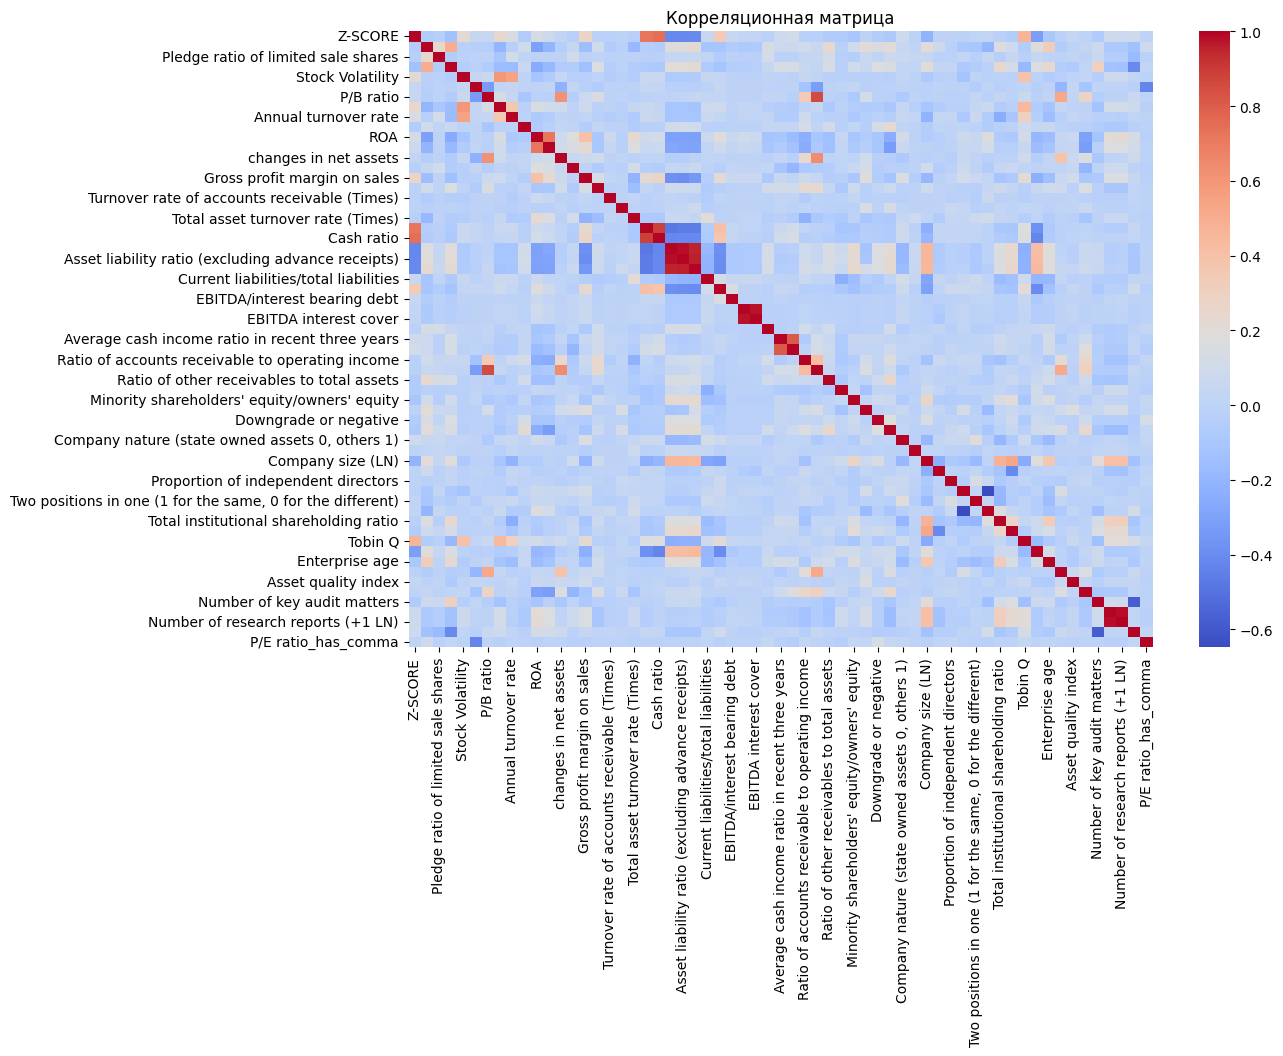


--- Корреляция признака: Tobin Q ---
Z-SCORE                                       0.467031
Stock price rise and fall in the last year    0.450523
Stock Volatility                              0.397211
Annual turnover rate                          0.307196
Gross profit margin on sales                  0.220438
Name: Tobin Q, dtype: float64

--- Корреляция признака: Debt financing costs ---
Asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts)    0.437501
Asset liability ratio (excluding advance receipts)                                                                                                         0.432529
Asset liability ratio                                                                                                                                      0.420371
Company size (LN)                                                                                                 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ПРИЗНАКОВ ==================
print("\nНачинаем анализ корреляции признаков...")

# Список числовых признаков с пропущенными значениями
numeric_features_with_missing = [
    "Tobin Q",
    "Debt financing costs",
    "Enterprise age",
    "Goodwill impairment ratio",
    "Asset quality index",
    "SG&A Expense"
]

# Вычисляем корреляционную матрицу
correlation_matrix = Xtrain.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица")
plt.show()

# Анализ корреляций для каждого признака с пропущенными значениями
for col in numeric_features_with_missing:
    print(f"\n--- Корреляция признака: {col} ---")

    # Корреляция с другими признаками
    correlations = correlation_matrix[col].sort_values(ascending=False)
    print(correlations[correlations != 1.0].head(5))  # Исключаем сам признак (корреляция = 1)

print("\nАнализ корреляций завершен!")

In [ ]:
# ================== ВЫЧИСЛЕНИЕ СРЕДНЕЙ КОРРЕЛЯЦИИ ПО МОДУЛЮ ==================
print("\nВычисление средней корреляции по модулю...")

# Список числовых признаков с пропущенными значениями
numeric_features_with_missing = [
    "Tobin Q",
    "Debt financing costs",
    "Enterprise age",
    "Goodwill impairment ratio",
    "Asset quality index",
    "SG&A Expense"
]

# Исключаем целевую переменную из расчетов
features_for_correlation = Xtrain.columns.tolist()
if target in features_for_correlation:
    features_for_correlation.remove(target)

# Вычисляем корреляционную матрицу
correlation_matrix = Xtrain[features_for_correlation].corr()

# Словарь для хранения средних корреляций по модулю
mean_correlations = {}

# Вычисляем среднюю корреляцию по модулю для каждого признака
for col in numeric_features_with_missing:
    # Исключаем сам признак из расчетов
    correlations = correlation_matrix[col].drop(col)
    mean_corr = correlations.abs().mean()  # Среднее абсолютных значений корреляций
    mean_correlations[col] = mean_corr

# Сортируем признаки по убыванию средней корреляции
sorted_mean_correlations = sorted(mean_correlations.items(), key=lambda x: x[1], reverse=True)

# Выводим результаты
print("\nСредняя корреляция по модулю для признаков с пропусками:")
for col, mean_corr in sorted_mean_correlations:
    print(f"{col}: {mean_corr:.4f}")

print("\nАнализ средней корреляции завершен!")


Вычисление средней корреляции по модулю...

Средняя корреляция по модулю для признаков с пропусками:
Debt financing costs: 0.1047
Tobin Q: 0.1014
Enterprise age: 0.0950
SG&A Expense: 0.0701
Goodwill impairment ratio: 0.0612
Asset quality index: 0.0279

Анализ средней корреляции завершен!


In [ ]:
# ================== АНАЛИЗ КОЛИЧЕСТВА СТРОК И ПРОПУСКОВ ==================
print("\nАнализ количества строк и пропусков в тестовой выборке...")

# Общее количество строк в тестовой выборке
total_rows_test = Xtest.shape[0]
print(f"Общее количество строк в тестовой выборке: {total_rows_test}")

# Количество пропусков для каждого признака
missing_values_test = Xtest.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0]  # Только признаки с пропусками

# Доля пропусков относительно общего количества строк
missing_ratio_test = missing_values_test / total_rows_test

# Вывод результатов
print("\nКоличество пропусков и их доля для каждого признака:")
for col, count in missing_values_test.items():
    ratio = missing_ratio_test[col]
    print(f"{col}: {count} пропусков ({ratio:.2%})")

print("\nАнализ количества строк и пропусков завершен!")


Анализ количества строк и пропусков в тестовой выборке...
Общее количество строк в тестовой выборке: 184

Количество пропусков и их доля для каждого признака:
Tobin Q: 142 пропусков (77.17%)
Debt financing costs: 142 пропусков (77.17%)
Enterprise age: 142 пропусков (77.17%)
Goodwill impairment ratio: 142 пропусков (77.17%)
Asset quality index: 142 пропусков (77.17%)
SG&A Expense: 142 пропусков (77.17%)
Number of key audit matters: 142 пропусков (77.17%)

Анализ количества строк и пропусков завершен!


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ================== ОЦЕНКА ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nОценка важности признаков...")

# Список признаков с пропусками
features_with_missing = [
    "Tobin Q",
    "Debt financing costs",
    "Enterprise age",
    "Goodwill impairment ratio",
    "Asset quality index",
    "SG&A Expense",
    "Number of key audit matters"
]

# Обучаем модель случайного леса на обучающем датасете
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(Xtrain.dropna(), ytrain)

# Получаем важность признаков
feature_importances = pd.Series(rf_model.feature_importances_, index=Xtrain.columns)

# Фильтруем важность только для признаков с пропусками
missing_features_importance = feature_importances[features_with_missing].sort_values(ascending=False)

# Выводим результаты
print("\nВажность признаков с пропусками:")
print(missing_features_importance)

print("\nОценка важности признаков завершена!")


Оценка важности признаков...

Важность признаков с пропусками:
Enterprise age                 0.017549
Debt financing costs           0.015603
Goodwill impairment ratio      0.009322
SG&A Expense                   0.009300
Asset quality index            0.008593
Tobin Q                        0.008422
Number of key audit matters    0.007208
dtype: float64

Оценка важности признаков завершена!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции с целевой переменной...")

# Объединяем обучающий датасет с целевой переменной
train_with_target = Xtrain.copy()
train_with_target[target] = ytrain

# Вычисляем корреляцию с целевой переменной
correlation_with_target = train_with_target.corr()[target].sort_values(ascending=False)

# Фильтруем только признаки с пропусками
features_with_missing = [
    "Tobin Q",
    "Debt financing costs",
    "Enterprise age",
    "Goodwill impairment ratio",
    "Asset quality index",
    "SG&A Expense",
    "Number of key audit matters"
]
missing_features_corr = correlation_with_target[features_with_missing]

# Выводим результаты
print("\nКорреляция признаков с целевой переменной:")
print(missing_features_corr)



Анализ корреляции с целевой переменной...

Корреляция признаков с целевой переменной:
Tobin Q                       -0.030184
Debt financing costs           0.188875
Enterprise age                 0.192258
Goodwill impairment ratio     -0.016841
Asset quality index           -0.008014
SG&A Expense                   0.109690
Number of key audit matters   -0.075426
Name: IsDefault, dtype: float64



Сравнение распределений в обучающем и тестовом датасетах...


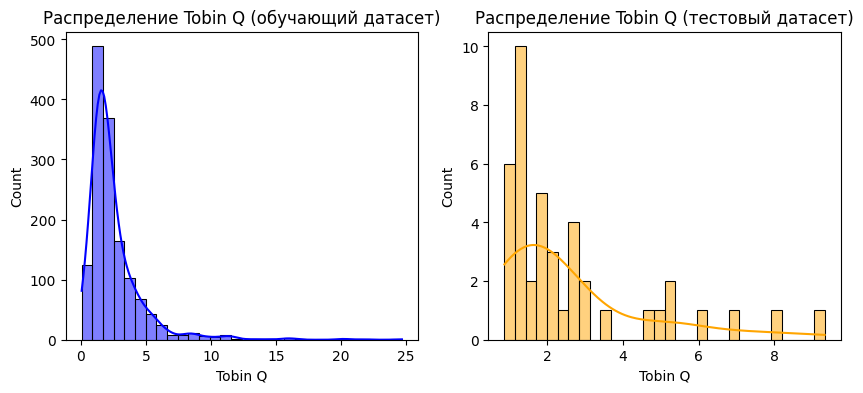

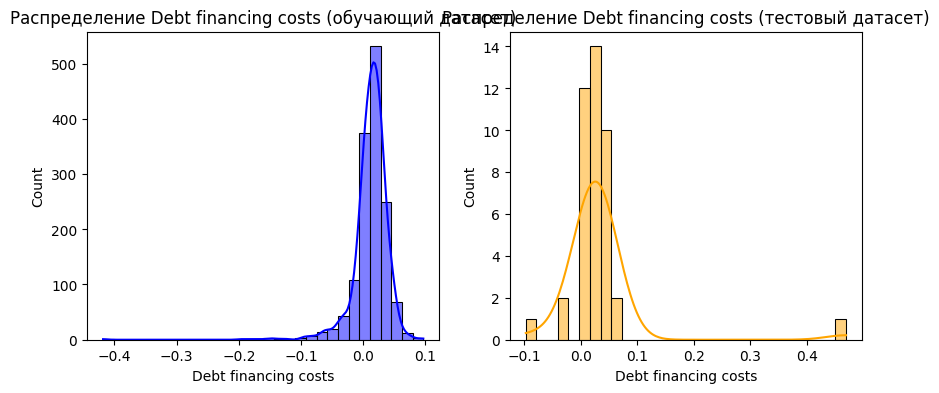

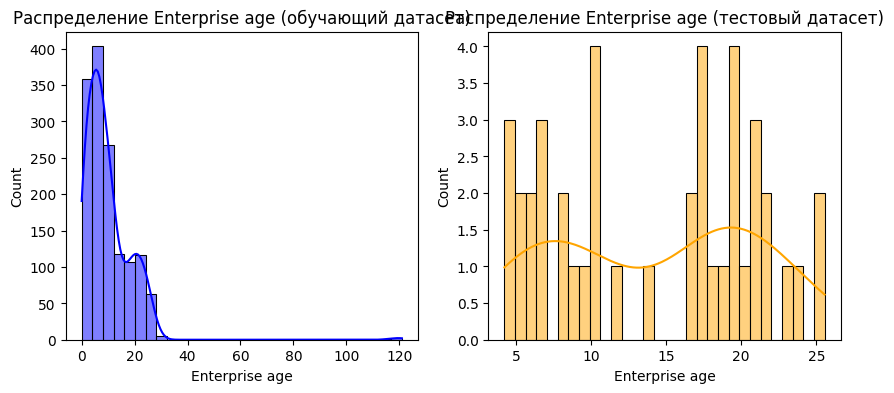

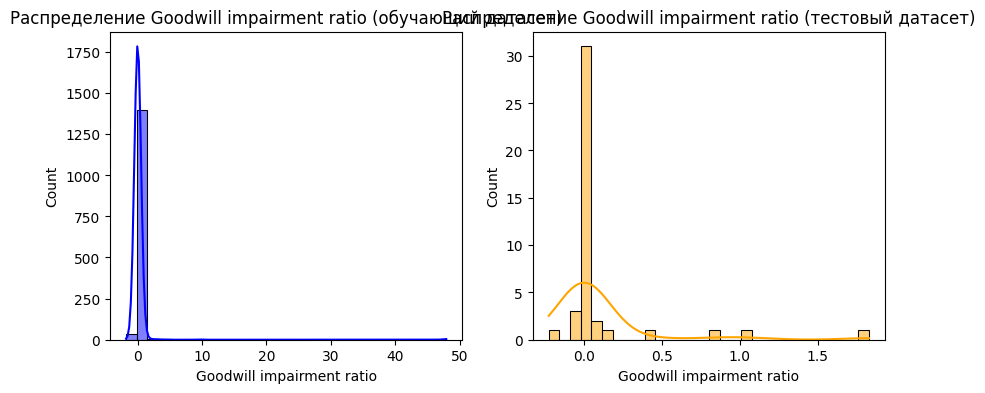

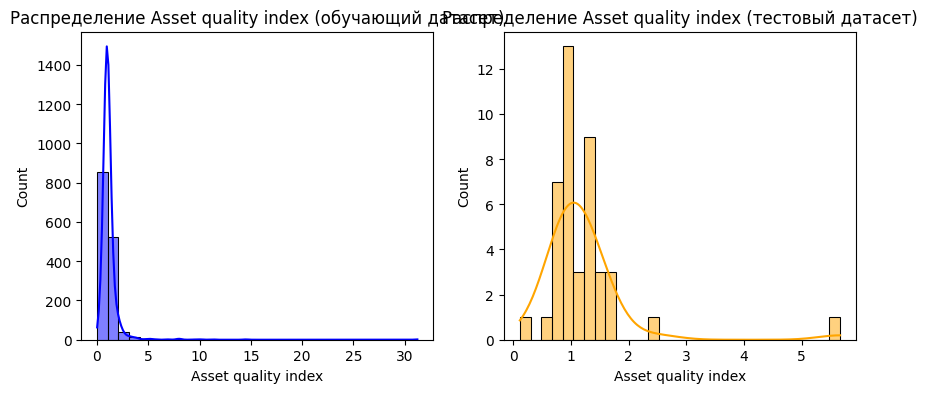

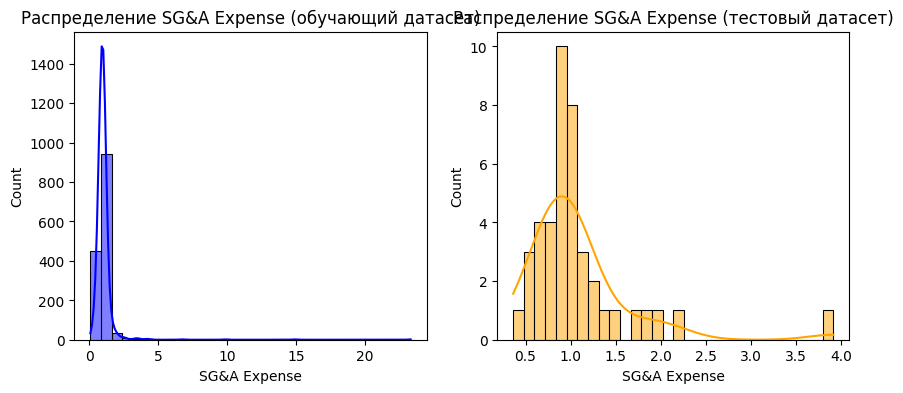

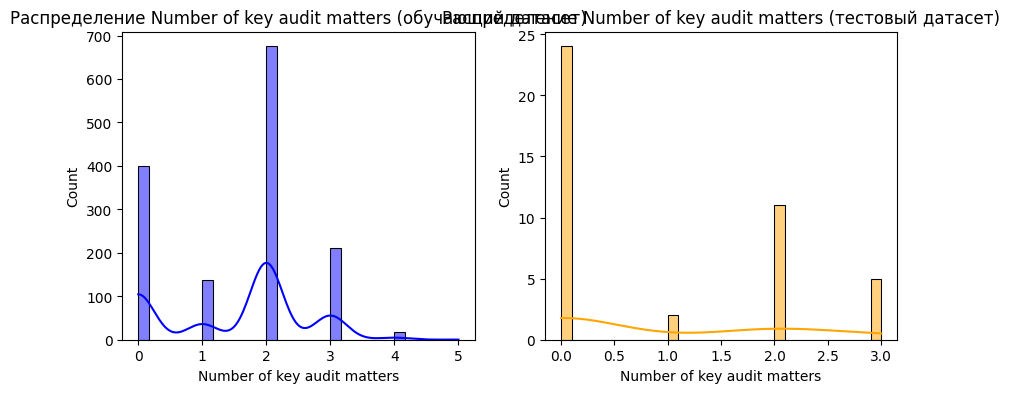


Анализ корреляции и распределений завершен!


In [ ]:
import warnings
import numpy as np
# ================== СРАВНЕНИЕ РАСПРЕДЕЛЕНИЙ В ОБУЧАЮЩЕМ И ТЕСТОВОМ ДАТАСЕТАХ ==================
print("\nСравнение распределений в обучающем и тестовом датасетах...")

# Игнорируем предупреждения
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Визуализация распределений
    for col in features_with_missing:
        plt.figure(figsize=(10, 4))

        # Распределение в обучающем датасете
        plt.subplot(1, 2, 1)
        sns.histplot(Xtrain[col].dropna(), kde=True, color="blue", bins=30)  # Удаляем NaN
        plt.title(f"Распределение {col} (обучающий датасет)")

        # Распределение в тестовом датасете
        plt.subplot(1, 2, 2)
        sns.histplot(Xtest[col].dropna(), kde=True, color="orange", bins=30)  # Удаляем NaN
        plt.title(f"Распределение {col} (тестовый датасет)")

        plt.show()

print("\nАнализ корреляции и распределений завершен!")

In [ ]:
# ================== ПРИСОЕДИНЕНИЕ МЕТОК К ДАННЫМ ==================
print("\nПрисоединение меток к обучающему датасету...")

# Создаем копию обучающего датасета с метками
Xtrain_with_target = Xtrain.copy()
Xtrain_with_target[target] = ytrain

print("Метки присоединены к обучающему датасету.")


Присоединение меток к обучающему датасету...
Метки присоединены к обучающему датасету.


In [ ]:
# ================== СОЗДАНИЕ КОПИЙ СТРОК С ПРОПУСКАМИ ==================
print("\nСоздание копий строк с искусственными пропусками...")

# Создаем копии всех строк
new_rows_with_missing = Xtrain_with_target.copy()

# Для каждой строки выбираем один случайный признак и создаем пропуск
for idx in new_rows_with_missing.index:
    # Выбираем случайный признак для пропуска (только числовые признаки)
    missing_feature = np.random.choice(features_with_missing)
    new_rows_with_missing.at[idx, missing_feature] = np.nan  # Явно изменяем значение по индексу

# Объединяем исходные данные и новые строки
Xtrain_extended = pd.concat([Xtrain_with_target, new_rows_with_missing])

# Перемешиваем данные
Xtrain_extended = Xtrain_extended.sample(frac=1, random_state=42).reset_index(drop=True)

print("Копии строк с искусственными пропусками созданы.")


Создание копий строк с искусственными пропусками...
Копии строк с искусственными пропусками созданы.


In [ ]:
# ================== ПРОВЕРКА НАЛИЧИЯ ПРОПУСКОВ ==================
print("\nПроверка наличия пропусков в копиях строк...")

# Подсчитываем количество пропусков в новых строках
missing_counts = new_rows_with_missing.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]  # Фильтруем только ненулевые значения
print("Количество пропусков в копиях строк:")
print(missing_counts)


Проверка наличия пропусков в копиях строк...
Количество пропусков в копиях строк:
Tobin Q                        196
Debt financing costs           193
Enterprise age                 204
Goodwill impairment ratio      219
Asset quality index            208
SG&A Expense                   209
Number of key audit matters    213
dtype: int64


In [ ]:
# ================== ЗАПОЛНЕНИЕ ПРОПУСКОВ И ДОБАВЛЕНИЕ ФЛАГОВ ==================
print("\nЗаполнение пропусков и добавление флагов...")

# Специальное значение для заполнения пропусков
numeric_fill_value = -999  # Для числовых признаков
categorical_fill_value = "missing"  # Для категориальных признаков

# Создаем копию датасета из Xtrain_extended (с учетом новых пропусков)
Xtrain_processed = Xtrain_extended.copy()
Xtest_processed = Xtest.copy()

# Заполняем пропуски и добавляем флаги
for col in features_with_missing:
    # Добавляем флаг для пропусков
    Xtrain_processed[f"{col}_is_missing"] = Xtrain_processed[col].isnull().astype(int)
    Xtest_processed[f"{col}_is_missing"] = Xtest_processed[col].isnull().astype(int)

    # Определяем тип данных признака
    if Xtrain_processed[col].dtype == 'object':  # Категориальный признак
        Xtrain_processed[col] = Xtrain_processed[col].fillna(categorical_fill_value)
        Xtest_processed[col] = Xtest_processed[col].fillna(categorical_fill_value)
    else:  # Числовой признак
        Xtrain_processed[col] = Xtrain_processed[col].fillna(numeric_fill_value)
        Xtest_processed[col] = Xtest_processed[col].fillna(numeric_fill_value)

print("Пропуски заполнены, флаги добавлены.")


Заполнение пропусков и добавление флагов...
Пропуски заполнены, флаги добавлены.


In [ ]:
# ================== ПРОВЕРКА КОЛИЧЕСТВА ЗНАЧЕНИЙ -999 В ПРИЗНАКАХ ==================
print("\nПроверка количества значений -999 в обучающем датасете...")

# Для обучающего датасета
missing_train_counts = (Xtrain_processed == -999).sum()
missing_train_counts = missing_train_counts[missing_train_counts > 0]  # Фильтруем только ненулевые значения
print("Количество значений -999 в обучающем датасете:")
print(missing_train_counts)


Проверка количества значений -999 в обучающем датасете...
Количество значений -999 в обучающем датасете:
Tobin Q                        196
Debt financing costs           193
Enterprise age                 204
Goodwill impairment ratio      219
Asset quality index            208
SG&A Expense                   209
Number of key audit matters    213
dtype: int64


In [ ]:
# ================== РАЗДЕЛЕНИЕ ДАННЫХ И МЕТОК ==================
print("\nРазделение данных и меток...")

# Разделяем данные и метки
Xtrain_processed = Xtrain_processed.drop(columns=[target])
ytrain_extended = Xtrain_extended[target]

print("Данные и метки разделены.")


Разделение данных и меток...
Данные и метки разделены.


In [ ]:
# Проверка размеров данных
print(f"Xtrain_processed: {Xtrain_processed.shape}")
print(f"ytrain_extended: {ytrain_extended.shape}")
print(f"Xtest_processed: {Xtest_processed.shape}")

Xtrain_processed: (2884, 68)
ytrain_extended: (2884,)
Xtest_processed: (184, 68)


In [ ]:
# ================== ПРОВЕРКА СОВПАДЕНИЯ ПРИЗНАКОВ ==================
print("\nПроверка совпадения признаков...")

# Признаки в обучающем и тестовом датасетах
train_features = set(Xtrain_processed.columns)
test_features = set(Xtest_processed.columns)

# Разница в признаках
missing_in_test = train_features - test_features
missing_in_train = test_features - train_features

print(f"Признаки, отсутствующие в тестовом датасете: {missing_in_test}")
print(f"Признаки, отсутствующие в обучающем датасете: {missing_in_train}")

# Проверяем, что разницы больше нет
assert not missing_in_test and not missing_in_train, "Признаки не совпадают!"
print("Признаки совпадают.")


Проверка совпадения признаков...
Признаки, отсутствующие в тестовом датасете: set()
Признаки, отсутствующие в обучающем датасете: set()
Признаки совпадают.


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 68)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 68)
Размеры датасетов проверены.


In [ ]:
# ================== СОХРАНЕНИЕ ДАТАСЕТОВ В ФАЙЛЫ ==================
print("\nСохранение датасетов в файлы...")

# Путь для сохранения файлов
output_dir = "/kaggle/working/processed_data"  # В Kaggle файлы сохраняются в /kaggle/working
os.makedirs(output_dir, exist_ok=True)

# Сохраняем обучающий датасет
train_file = os.path.join(output_dir, "Xtrain_processed.csv")
Xtrain_processed.to_csv(train_file, index=False)
print(f"Обучающий датасет сохранен в файл: {train_file}")

# Сохраняем метки
labels_file = os.path.join(output_dir, "ytrain_extended.csv")
pd.Series(ytrain_extended).to_csv(labels_file, index=False, header=["target"])
print(f"Метки сохранены в файл: {labels_file}")

# Сохраняем тестовый датасет
test_file = os.path.join(output_dir, "Xtest_processed.csv")
Xtest_processed.to_csv(test_file, index=False)
print(f"Тестовый датасет сохранен в файл: {test_file}")


Сохранение датасетов в файлы...
Обучающий датасет сохранен в файл: /kaggle/working/processed_data/Xtrain_processed.csv
Метки сохранены в файл: /kaggle/working/processed_data/ytrain_extended.csv
Тестовый датасет сохранен в файл: /kaggle/working/processed_data/Xtest_processed.csv


In [ ]:
import shutil

# ================== АРХИВАЦИЯ ФАЙЛОВ ==================
print("\nАрхивация файлов...")
archive_name = "/kaggle/working/processed_data.zip"

# Создаем ZIP-архив
shutil.make_archive(archive_name.replace(".zip", ""), 'zip', output_dir)
print(f"Файлы заархивированы в: {archive_name}")


Архивация файлов...
Файлы заархивированы в: /kaggle/working/processed_data.zip


In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
# ================== ОПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nОпределение категориальных признаков...")

categorical_features = []

for col in Xtrain_processed.columns:
    if Xtrain_processed[col].dtype == 'object' or Xtrain_processed[col].nunique() <= 10:
        categorical_features.append(col)
        print(f"Категориальный признак: {col}, Тип данных: {Xtrain_processed[col].dtype}")

print(f"\nСписок категориальных признаков: {categorical_features}")


Определение категориальных признаков...
Категориальный признак: ST, Тип данных: float64
Категориальный признак: Net cash flow from operations has been negative for three consecutive years, Тип данных: float64
Категориальный признак: Downgrade or negative, Тип данных: float64
Категориальный признак: audit opinion , Тип данных: float64
Категориальный признак: Company nature (state owned assets 0, others 1), Тип данных: int64
Категориальный признак: High deposit and loan of 90p, Тип данных: int64
Категориальный признак: Whether there are four major audits, Тип данных: int64
Категориальный признак: Two positions in one (1 for the same, 0 for the different), Тип данных: int64
Категориальный признак: Number of key audit matters, Тип данных: float64
Категориальный признак: P/E ratio_has_comma, Тип данных: int64
Категориальный признак: Tobin Q_is_missing, Тип данных: int64
Категориальный признак: Debt financing costs_is_missing, Тип данных: int64
Категориальный признак: Enterprise age_is_miss

In [ ]:
# ================== РАЗДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nРазделение категориальных признаков...")

# Список категориальных признаков, которые нужно преобразовать в строки
categorical_features_str = []

# Список бинарных признаков (остаются числовыми)
binary_features = []

for col in categorical_features:
    unique_values = Xtrain_processed[col].unique()
    if len(unique_values) == 2 and set(unique_values) == {0, 1}:  # Бинарный признак
        binary_features.append(col)
        print(f"Бинарный признак: {col}, Уникальные значения: {unique_values}")
    else:  # Преобразуем в строку
        categorical_features_str.append(col)
        print(f"Категориальный признак (строковый): {col}, Уникальные значения: {unique_values}")

print(f"\nБинарные признаки: {binary_features}")
print(f"Категориальные признаки (строковые): {categorical_features_str}")


Разделение категориальных признаков...
Бинарный признак: ST, Уникальные значения: [0. 1.]
Бинарный признак: Net cash flow from operations has been negative for three consecutive years, Уникальные значения: [0. 1.]
Бинарный признак: Downgrade or negative, Уникальные значения: [0. 1.]
Категориальный признак (строковый): audit opinion , Уникальные значения: [0. 2. 1.]
Бинарный признак: Company nature (state owned assets 0, others 1), Уникальные значения: [1 0]
Бинарный признак: High deposit and loan of 90p, Уникальные значения: [0 1]
Бинарный признак: Whether there are four major audits, Уникальные значения: [1 0]
Бинарный признак: Two positions in one (1 for the same, 0 for the different), Уникальные значения: [1 0]
Категориальный признак (строковый): Number of key audit matters, Уникальные значения: [   2.    3.    1.    0. -999.    4.    5.]
Бинарный признак: P/E ratio_has_comma, Уникальные значения: [0 1]
Бинарный признак: Tobin Q_is_missing, Уникальные значения: [0 1]
Бинарный призн

In [ ]:
# ================== ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ В ЦЕЛЫЕ ЧИСЛА, ЗАТЕМ В СТРОКИ ==================
print("\nПреобразование категориальных признаков в целые числа, затем в строки...")

for col in categorical_features_str:
    # Преобразуем в числовой формат, затем в целые числа и строки
    Xtrain_processed[col] = Xtrain_processed[col].astype(float).astype(int).astype(str)
    Xtest_processed[col] = Xtest_processed[col].astype(float).astype(int).astype(str)

print("Категориальные признаки преобразованы.")


Преобразование категориальных признаков в целые числа, затем в строки...
Категориальные признаки преобразованы.


In [ ]:
# ================== ПРОВЕРКА УНИКАЛЬНЫХ ЗНАЧЕНИЙ ==================
print("\nПроверка уникальных значений для категориальных признаков...")

for col in categorical_features_str:
    print(f"Признак: {col}, Уникальные значения: {Xtrain_processed[col].unique()}")


Проверка уникальных значений для категориальных признаков...
Признак: audit opinion , Уникальные значения: ['0' '2' '1']
Признак: Number of key audit matters, Уникальные значения: ['2' '3' '1' '0' '-999' '4' '5']


In [ ]:
from sklearn.model_selection import train_test_split

# ================== РАЗДЕЛЕНИЕ ОБУЧАЮЩЕГО ДАТАСЕТА ==================
print("\nРазделение обучающего датасета на тренировочную и валидационную части...")

# Разделяем данные на тренировочную и валидационную части
X_train, X_val, y_train, y_val = train_test_split(
    Xtrain_processed, ytrain_extended, test_size=0.2, random_state=42
)

# Создаем Pool для тренировочной части
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_str)

# Создаем Pool для валидационной части
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features_str)

print("Обучающий и валидационный датасеты разделены.")


Разделение обучающего датасета на тренировочную и валидационную части...
Обучающий и валидационный датасеты разделены.


In [ ]:
# ================== ПРОВЕРКА БАЛАНСА КЛАССОВ ==================
print("\nБаланс классов в обучающем датасете:")
print(ytrain_extended.value_counts())


Баланс классов в обучающем датасете:
IsDefault
0    2352
1     532
Name: count, dtype: int64


In [ ]:
from catboost import CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ С БАЛАНСИРОВКОЙ КЛАССОВ ==================
print("\nОбучение модели CatBoost с балансировкой классов...")

# Инициализация модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,  # Вывод логов каждые 100 итераций
    eval_metric="F1",  # Метрика для оценки качества
    auto_class_weights="Balanced",  # Автоматическая балансировка весов
    task_type="CPU"  # Используем CPU
)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Обучение модели CatBoost с балансировкой классов...
Learning rate set to 0.038957
0:	learn: 0.8674745	test: 0.8363022	best: 0.8363022 (0)	total: 66.7ms	remaining: 1m 6s
100:	learn: 0.9976108	test: 0.9848464	best: 0.9848464 (96)	total: 1.01s	remaining: 8.98s
200:	learn: 1.0000000	test: 0.9902913	best: 0.9902913 (175)	total: 1.93s	remaining: 7.68s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 2.84s	remaining: 6.6s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 3.77s	remaining: 5.63s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 4.67s	remaining: 4.65s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 5.51s	remaining: 3.66s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 6.34s	remaining: 2.7s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 7.22s	remaining: 1.79s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (249)	total: 8.29s	remaining: 911ms
999:	learn: 1.0000000	t

In [ ]:
from sklearn.metrics import f1_score

# ================== ПРЕДСКАЗАНИЯ ДЛЯ ВАЛИДАЦИОННОЙ ВЫБОРКИ ==================
print("\nПолучение предсказаний для валидационной выборки...")

# Получаем "жесткие" предсказания (0 или 1)
val_predictions = model.predict(val_pool)

# Вычисляем F1-меру
f1 = f1_score(y_val, val_predictions)
print(f"F1-мера на валидационной выборке: {f1:.4f}")


Получение предсказаний для валидационной выборки...
F1-мера на валидационной выборке: 1.0000


In [ ]:
# ================== ПРОВЕРКА ИНДЕКСА ТЕСТОВОГО ДАТАСЕТА ==================
print("\nИндекс тестового датасета:")
print(Xtest_processed.index)


Индекс тестового датасета:
Index(['X01443', 'X01444', 'X01445', 'X01446', 'X01447', 'X01448', 'X01449',
       'X01450', 'X01451', 'X01452',
       ...
       'X01617', 'X01618', 'X01619', 'X01620', 'X01621', 'X01622', 'X01623',
       'X01624', 'X01625', 'X01626'],
      dtype='object', name='Stock code', length=184)


In [ ]:
# ================== ПРЕДСКАЗАНИЯ ДЛЯ ТЕСТОВОГО ДАТАСЕТА ==================
print("\nПолучение предсказаний для тестового датасета...")

# Создаем Pool для тестового датасета
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission.csv")


Получение предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission.csv


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ RANDOM FOREST ==================
print("\nОбучение модели Random Forest для анализа важности признаков...")

# Инициализация модели
rf_model = RandomForestClassifier(
    n_estimators=100,       # Количество деревьев
    max_depth=10,           # Максимальная глубина дерева
    random_state=42,
    class_weight="balanced"  # Учет несбалансированности классов
)

# Обучение модели
rf_model.fit(Xtrain_processed, ytrain_extended)

print("Модель обучена.")


Обучение модели Random Forest для анализа важности признаков...
Модель обучена.


In [ ]:
# ================== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nАнализ важности признаков...")

# Получаем важность признаков
feature_importances = rf_model.feature_importances_

# Создаем DataFrame для удобства анализа
importance_df = pd.DataFrame({
    "Feature": Xtrain_processed.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Выводим топ-20 важных признаков
print("Топ-20 важных признаков:")
print(importance_df.head(20))


Анализ важности признаков...
Топ-20 важных признаков:
                                           Feature  Importance
1   Share pledge ratio of controlling shareholders    0.177859
19                                   Current ratio    0.097603
33        Ratio of prepayments to operating income    0.073493
59                          Financial cycle m2/gdp    0.063183
3                 Pledge ratio of unlimited shares    0.033938
7       Stock price rise and fall in the last year    0.028639
0                                          Z-SCORE    0.025741
52                                  Enterprise age    0.024682
34      Ratio of other receivables to total assets    0.022827
5                                        P/E ratio    0.022491
18               Total asset turnover rate (Times)    0.022341
11                                             ROE    0.019174
20                                      Cash ratio    0.017713
25                Monetary capital/short-term debt    0.014831


In [ ]:
# Сохраняем все признаки в CSV-файл
importance_df.to_csv("/kaggle/working/feature_importances_all.csv", index=False)


Визуализация важности признаков...


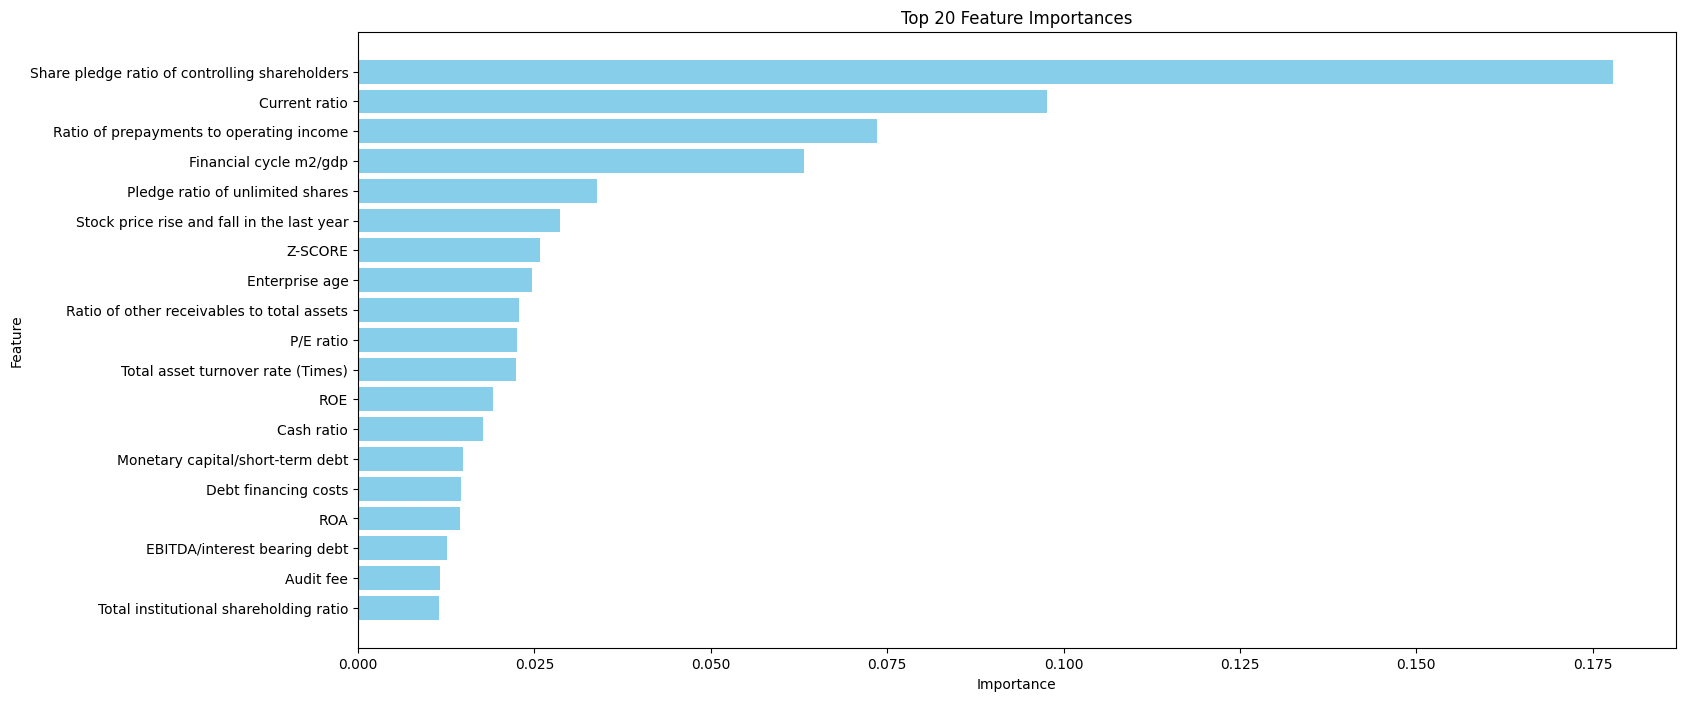

In [ ]:
import matplotlib.pyplot as plt

# ================== ВИЗУАЛИЗАЦИЯ ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nВизуализация важности признаков...")

# Строим график
plt.figure(figsize=(17, 8))
plt.barh(importance_df["Feature"][:19], importance_df["Importance"][:19], color='skyblue')
plt.gca().invert_yaxis()  # Инвертируем ось Y для удобства чтения
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

In [ ]:
# ================== ОБУЧЕНИЕ МОДЕЛИ ISOLATION FOREST ==================
print("\nОбучение модели Isolation Forest...")

# Инициализация модели
iso_forest = IsolationForest(
    n_estimators=100,       # Количество деревьев
    contamination=0.05,     # Ожидаемая доля аномалий (например, 5%)
    random_state=42         # Фиксируем случайность для воспроизводимости
)

# Обучение модели
iso_forest.fit(Xtrain_processed)

print("Модель обучена.")


Обучение модели Isolation Forest...
Модель обучена.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
# ================== ПРЕДСКАЗАНИЯ АНОМАЛИЙ ==================
print("\nПредсказание аномалий...")

# Предсказания для обучающего датасета
train_anomalies = iso_forest.predict(Xtrain_processed)

# Предсказания для тестового датасета
test_anomalies = iso_forest.predict(Xtest_processed)

# Добавляем метки аномалий в данные
Xtrain_processed['Anomaly'] = train_anomalies
Xtest_processed['Anomaly'] = test_anomalies

print("Аномалии предсказаны.")


Предсказание аномалий...
Аномалии предсказаны.


In [ ]:
# ================== АНАЛИЗ АНОМАЛИЙ ==================
print("\nАнализ аномалий...")

# Количество аномалий в обучающем датасете
train_anomaly_count = (train_anomalies == -1).sum()
print(f"Количество аномалий в обучающем датасете: {train_anomaly_count}")

# Количество аномалий в тестовом датасете
test_anomaly_count = (test_anomalies == -1).sum()
print(f"Количество аномалий в тестовом датасете: {test_anomaly_count}")


Анализ аномалий...
Количество аномалий в обучающем датасете: 145
Количество аномалий в тестовом датасете: 143


In [ ]:
# ================== СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ==================
print("\nСохранение результатов анализа аномалий...")

# Сохраняем метки аномалий для обучающего датасета
anomalies_train = pd.DataFrame({
    "Stock code": Xtrain_processed.index,
    "Anomaly": train_anomalies
})
anomalies_train.to_csv("/kaggle/working/anomalies_train.csv", index=False)

# Сохраняем метки аномалий для тестового датасета
anomalies_test = pd.DataFrame({
    "Stock code": Xtest_processed.index,
    "Anomaly": test_anomalies
})
anomalies_test.to_csv("/kaggle/working/anomalies_test.csv", index=False)

print("Результаты анализа аномалий сохранены.")


Сохранение результатов анализа аномалий...
Результаты анализа аномалий сохранены.


In [ ]:
# ================== ПРОВЕРКА ДОБАВЛЕНИЯ ПРИЗНАКА ANOMALY ==================
print("\nПроверка добавления признака Anomaly...")

print("Обучающий датасет:")
print(Xtrain_processed[['Anomaly']].head())

print("\nТестовый датасет:")
print(Xtest_processed[['Anomaly']].head())


Проверка добавления признака Anomaly...
Обучающий датасет:
   Anomaly
0        1
1        1
2        1
3        1
4        1

Тестовый датасет:
            Anomaly
Stock code         
X01443            1
X01444            1
X01445            1
X01446            1
X01447            1


In [ ]:
# ================== ОБНОВЛЕНИЕ СПИСКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nОбновление списка категориальных признаков...")

# Добавляем 'Anomaly' в список категориальных признаков
categorical_features_str.append('Anomaly')

print(f"Обновленный список категориальных признаков: {categorical_features_str}")


Обновление списка категориальных признаков...
Обновленный список категориальных признаков: ['audit opinion ', 'Number of key audit matters', 'Anomaly']


In [ ]:
from catboost import Pool

# ================== СОЗДАНИЕ POOL ДЛЯ CATBOOST ==================
print("\nСоздание Pool для CatBoost...")

# Разделяем данные на тренировочную и валидационную части
X_train, X_val, y_train, y_val = train_test_split(
    Xtrain_processed, ytrain_extended, test_size=0.2, random_state=42
)

# Создаем Pool для тренировочных данных
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_str)

# Создаем Pool для валидационных данных
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features_str)

print("Pool созданы.")


Создание Pool для CatBoost...
Pool созданы.


In [ ]:
from catboost import CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ CATBOOST ==================
print("\nОбучение модели CatBoost с новым признаком Anomaly...")

# Инициализация модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,  # Вывод логов каждые 100 итераций
    eval_metric="F1",  # Метрика для оценки качества
    auto_class_weights="Balanced",  # Автоматическая балансировка весов
    task_type="CPU"  # Используем CPU
)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Обучение модели CatBoost с новым признаком Anomaly...
Learning rate set to 0.038957
0:	learn: 0.8432605	test: 0.8203744	best: 0.8203744 (0)	total: 11.2ms	remaining: 11.2s
100:	learn: 0.9984060	test: 0.9826852	best: 0.9826852 (100)	total: 975ms	remaining: 8.68s
200:	learn: 1.0000000	test: 0.9902913	best: 0.9902913 (142)	total: 1.93s	remaining: 7.68s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 2.9s	remaining: 6.75s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 3.8s	remaining: 5.67s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 4.65s	remaining: 4.63s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 5.49s	remaining: 3.64s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 6.32s	remaining: 2.7s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 7.16s	remaining: 1.78s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 7.98s	remaining: 877ms
999:	learn: 1.0000000

In [ ]:
from sklearn.metrics import f1_score

# ================== ОЦЕНКА F1 НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ ==================
print("\nОценка F1 на валидационной выборке...")

# Получаем "жесткие" предсказания (0 или 1)
val_predictions = model.predict(val_pool)

# Вычисляем F1-меру
f1 = f1_score(y_val, val_predictions)
print(f"F1-мера на валидационной выборке: {f1:.4f}")


Оценка F1 на валидационной выборке...
F1-мера на валидационной выборке: 1.0000


In [ ]:
# ================== ПРЕДСКАЗАНИЯ ДЛЯ ТЕСТОВОГО ДАТАСЕТА ==================
print("\nПолучение предсказаний для тестового датасета...")

# Создаем Pool для тестового датасета
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_anomaly.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_anomaly.csv")


Получение предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_anomaly.csv


In [ ]:
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": Xtrain_processed.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)
print(importance_df.head(10))

                                           Feature  Importance
19                                   Current ratio   36.585753
59                          Financial cycle m2/gdp   33.279201
1   Share pledge ratio of controlling shareholders    8.361009
3                 Pledge ratio of unlimited shares    1.888483
33        Ratio of prepayments to operating income    1.777262
25                Monetary capital/short-term debt    1.001736
36    Minority shareholders' equity/owners' equity    0.770228
34      Ratio of other receivables to total assets    0.752703
51                            Debt financing costs    0.686453
14                    Gross profit margin on sales    0.675036


In [ ]:
# ================== АНАЛИЗ СВЯЗИ АНОМАЛИЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ связи аномалий с целевой переменной...")

# Создаем кросс-таблицу
anomaly_target_table = pd.crosstab(Xtrain_processed['Anomaly'], ytrain_extended)
print(anomaly_target_table)

# Вычисляем процент аномалий среди дефолтов
anomaly_in_defaults = anomaly_target_table.loc[-1, 1] / anomaly_target_table[1].sum()
print(f"Процент аномалий среди дефолтов: {anomaly_in_defaults:.2%}")


Анализ связи аномалий с целевой переменной...
IsDefault     0    1
Anomaly             
-1           87   58
 1         2265  474
Процент аномалий среди дефолтов: 10.90%



Анализ распределения признака 'Share pledge ratio of controlling shareholders'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


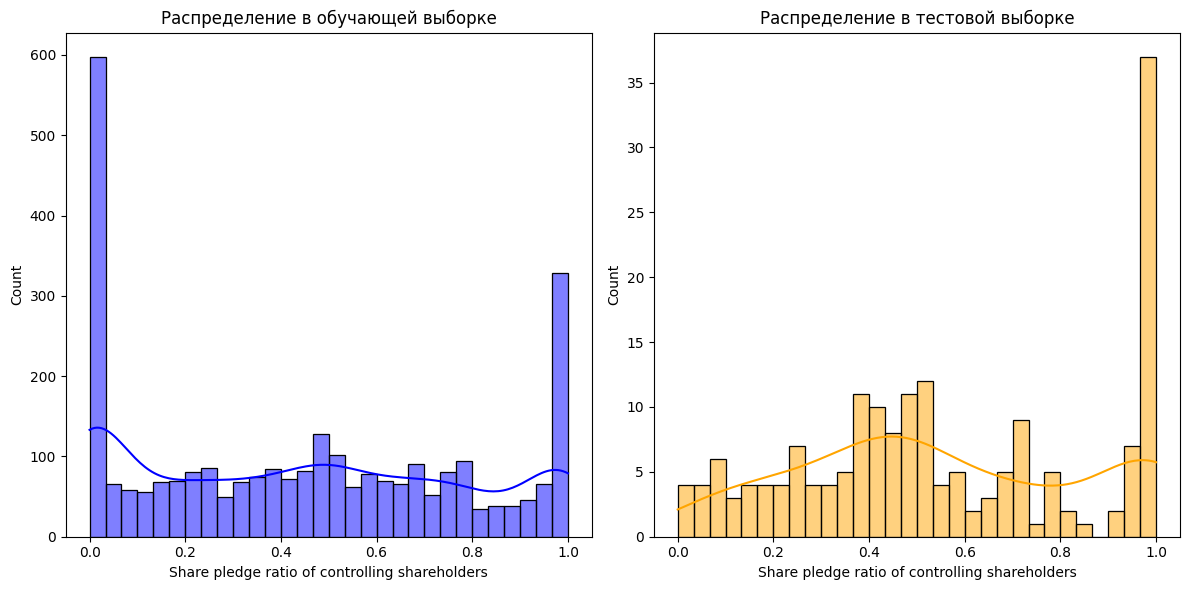

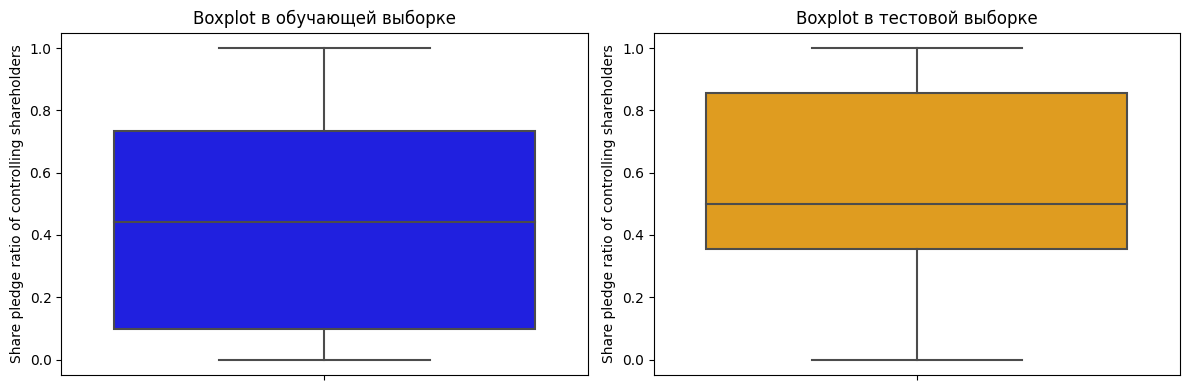

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПРИЗНАКА ==================
print("\nАнализ распределения признака 'Share pledge ratio of controlling shareholders'...")

# Выбираем признак
feature_to_analyze = 'Share pledge ratio of controlling shareholders'

# Гистограммы
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(Xtrain_processed[feature_to_analyze], kde=True, bins=30, color='blue')
plt.title("Распределение в обучающей выборке")
plt.xlabel(feature_to_analyze)

plt.subplot(1, 2, 2)
sns.histplot(Xtest_processed[feature_to_analyze], kde=True, bins=30, color='orange')
plt.title("Распределение в тестовой выборке")
plt.xlabel(feature_to_analyze)

plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=Xtrain_processed[feature_to_analyze], color='blue')
plt.title("Boxplot в обучающей выборке")

plt.subplot(1, 2, 2)
sns.boxplot(y=Xtest_processed[feature_to_analyze], color='orange')
plt.title("Boxplot в тестовой выборке")

plt.tight_layout()
plt.show()

In [ ]:
# ================== СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ ==================
print("\nСтатистические характеристики признака...")

# Для обучающей выборки
train_stats = Xtrain_processed[feature_to_analyze].describe()
print("Обучающая выборка:")
print(train_stats)

# Для тестовой выборки
test_stats = Xtest_processed[feature_to_analyze].describe()
print("\nТестовая выборка:")
print(test_stats)


Статистические характеристики признака...
Обучающая выборка:
count    2884.000000
mean        0.442647
std         0.345080
min         0.000000
25%         0.097593
50%         0.440436
75%         0.734500
max         1.000000
Name: Share pledge ratio of controlling shareholders, dtype: float64

Тестовая выборка:
count    184.000000
mean       0.561388
std        0.305907
min        0.000000
25%        0.353800
50%        0.500000
75%        0.857525
max        1.000000
Name: Share pledge ratio of controlling shareholders, dtype: float64



Анализ плотности распределения...


<ipython-input-59-1b83f747a4e6>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Xtrain_processed[feature_to_analyze], shade=True, label="Обучающая выборка")
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-59-1b83f747a4e6>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Xtest_processed[feature_to_analyze], shade=True, label="Тестовая выборка")
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf valu

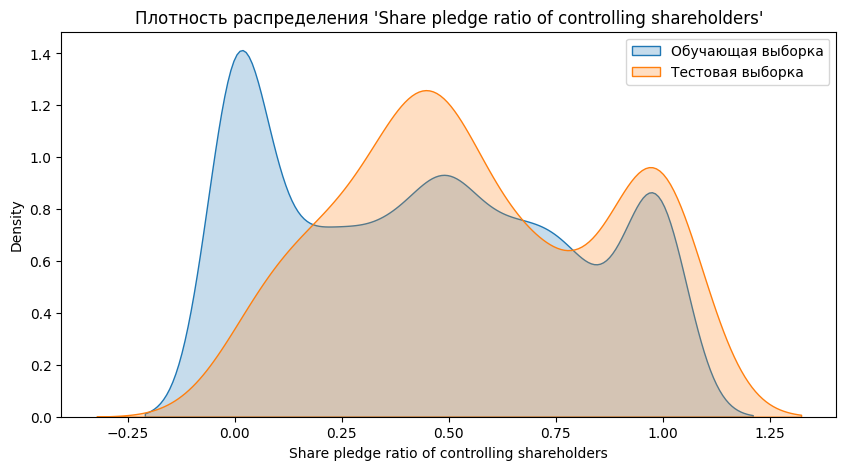

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ ПЛОТНОСТИ РАСПРЕДЕЛЕНИЯ ==================
print("\nАнализ плотности распределения...")

# Выбираем признак
feature_to_analyze = 'Share pledge ratio of controlling shareholders'

# График плотности
plt.figure(figsize=(10, 5))
sns.kdeplot(Xtrain_processed[feature_to_analyze], shade=True, label="Обучающая выборка")
sns.kdeplot(Xtest_processed[feature_to_analyze], shade=True, label="Тестовая выборка")
plt.title(f"Плотность распределения '{feature_to_analyze}'")
plt.xlabel(feature_to_analyze)
plt.legend()
plt.show()

In [ ]:
# ================== АНАЛИЗ УНИКАЛЬНЫХ ЗНАЧЕНИЙ ==================
print("\nАнализ уникальных значений...")

# Выбираем признак
feature_to_analyze = 'Share pledge ratio of controlling shareholders'

# Подсчет уникальных значений и их частот
unique_values = Xtrain_processed[feature_to_analyze].value_counts(normalize=True).sort_values(ascending=False)

# Выводим результаты
print(f"Уникальные значения признака '{feature_to_analyze}' (отсортированы по частоте):")
print(unique_values.head(10))


Анализ уникальных значений...
Уникальные значения признака 'Share pledge ratio of controlling shareholders' (отсортированы по частоте):
Share pledge ratio of controlling shareholders
0.0000    0.199029
1.0000    0.044383
0.5000    0.008322
0.9999    0.003467
0.9538    0.002080
0.9973    0.002080
0.9998    0.002080
0.9978    0.002080
0.9830    0.001387
0.9884    0.001387
Name: proportion, dtype: float64


In [ ]:
# ================== РАЗДЕЛЕНИЕ НА ГРУППЫ ==================
print("\nРазделение данных на три группы...")

# Фильтрация данных по группам
no_pledge = Xtrain_processed[Xtrain_processed['Share pledge ratio of controlling shareholders'] == 0.0]
full_pledge = Xtrain_processed[Xtrain_processed['Share pledge ratio of controlling shareholders'] == 1.0]
near_full_pledge = Xtrain_processed[
    (Xtrain_processed['Share pledge ratio of controlling shareholders'] >= 0.90) &
    (Xtrain_processed['Share pledge ratio of controlling shareholders'] < 1.0)
]

print("Данные разделены на три группы.")


Разделение данных на три группы...
Данные разделены на три группы.


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции с целевой переменной...")

# Расчет вероятности дефолта для каждой группы
def calculate_default_rate(group, ytrain_extended):
    group_indices = group.index
    default_rate = ytrain_extended.loc[group_indices].mean()
    return default_rate

# Вероятность дефолта для каждой группы
no_pledge_default_rate = calculate_default_rate(no_pledge, ytrain_extended)
full_pledge_default_rate = calculate_default_rate(full_pledge, ytrain_extended)
near_full_pledge_default_rate = calculate_default_rate(near_full_pledge, ytrain_extended)

# Вывод результатов
print(f"Вероятность дефолта для No_Pledge (0.0): {no_pledge_default_rate:.2%}")
print(f"Вероятность дефолта для Full_Pledge (1.0): {full_pledge_default_rate:.2%}")
print(f"Вероятность дефолта для Near_Full_Pledge (0.90–0.9999): {near_full_pledge_default_rate:.2%}")


Анализ корреляции с целевой переменной...
Вероятность дефолта для No_Pledge (0.0): 0.00%
Вероятность дефолта для Full_Pledge (1.0): 79.69%
Вероятность дефолта для Near_Full_Pledge (0.90–0.9999): 65.38%



Визуализация распределения...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


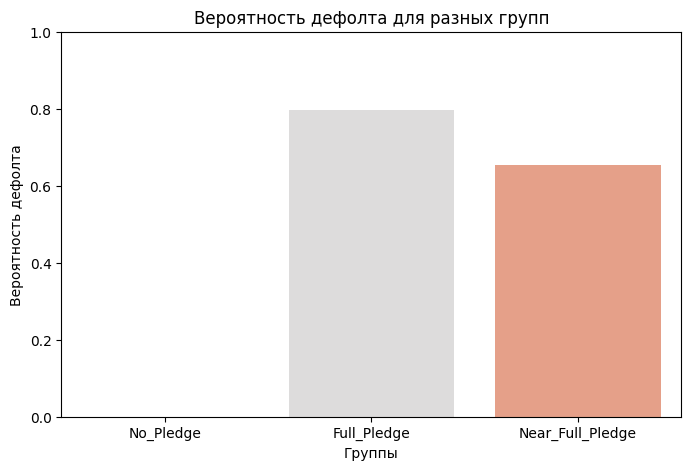

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ==================
print("\nВизуализация распределения...")

# Создаем DataFrame для визуализации
group_labels = ['No_Pledge', 'Full_Pledge', 'Near_Full_Pledge']
default_rates = [no_pledge_default_rate, full_pledge_default_rate, near_full_pledge_default_rate]

# Строим график
plt.figure(figsize=(8, 5))
sns.barplot(x=group_labels, y=default_rates, palette='coolwarm')
plt.title("Вероятность дефолта для разных групп")
plt.ylabel("Вероятность дефолта")
plt.xlabel("Группы")
plt.ylim(0, 1)
plt.show()

In [ ]:
# ================== ПОДСЧЕТ КОЛИЧЕСТВА СТРОК ДЛЯ ЗНАЧЕНИЯ 0.0 ==================
print("\nПодсчет количества строк для значения 0.0...")

# Фильтрация данных для значения 0.0
count_0 = len(Xtrain_processed[Xtrain_processed['Share pledge ratio of controlling shareholders'] == 0.0])
print(f"Количество строк для значения 0.0: {count_0}")


Подсчет количества строк для значения 0.0...
Количество строк для значения 0.0: 574


In [ ]:
# ================== СОЗДАНИЕ ВТОРОЙ КАТЕГОРИИ ==================
print("\nСоздание второй категории (близкие к 1.0)...")

# Сортируем значения от `1.0` к меньшим
sorted_values = Xtrain_processed['Share pledge ratio of controlling shareholders'].sort_values(ascending=False)

# Находим пороговое значение для второй категории
threshold_1 = sorted_values.iloc[count_0 - 1]
print(f"Пороговое значение для второй категории: {threshold_1:.4f}")

# Фильтрация данных для второй категории
category_1 = Xtrain_processed[Xtrain_processed['Share pledge ratio of controlling shareholders'] >= threshold_1]
print(f"Количество строк во второй категории: {len(category_1)}")


Создание второй категории (близкие к 1.0)...
Пороговое значение для второй категории: 0.7926
Количество строк во второй категории: 574


In [ ]:
# ================== ГРУППИРОВКА ОСТАЛЬНЫХ ЗНАЧЕНИЙ ==================
print("\nГруппировка остальных значений...")

# Оставшиеся значения
remaining_values = Xtrain_processed[
    (Xtrain_processed['Share pledge ratio of controlling shareholders'] > 0.0) &
    (Xtrain_processed['Share pledge ratio of controlling shareholders'] < threshold_1)
]

# Сортируем значения
sorted_remaining = remaining_values['Share pledge ratio of controlling shareholders'].sort_values()

# Разделяем на группы
group_size = count_0
groups = []
for i in range(0, len(sorted_remaining), group_size):
    group = sorted_remaining.iloc[i:i + group_size]
    groups.append(group)

print(f"Количество групп: {len(groups)}")


Группировка остальных значений...
Количество групп: 4


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции с целевой переменной...")

# Функция для расчета вероятности дефолта
def calculate_default_rate(group_indices, ytrain_extended):
    default_rate = ytrain_extended.loc[group_indices].mean()
    return default_rate

# Category_0: Значения, равные 0.0
category_0_indices = Xtrain_processed[Xtrain_processed['Share pledge ratio of controlling shareholders'] == 0.0].index
category_0_default_rate = calculate_default_rate(category_0_indices, ytrain_extended)

# Category_1: Значения от 0.7926 до 1.0
category_1_indices = Xtrain_processed[
    Xtrain_processed['Share pledge ratio of controlling shareholders'] >= 0.7926
].index
category_1_default_rate = calculate_default_rate(category_1_indices, ytrain_extended)

# Остальные группы
remaining_values = Xtrain_processed[
    (Xtrain_processed['Share pledge ratio of controlling shareholders'] > 0.0) &
    (Xtrain_processed['Share pledge ratio of controlling shareholders'] < 0.7926)
]
sorted_remaining = remaining_values['Share pledge ratio of controlling shareholders'].sort_values()

group_size = 574
groups = []
default_rates = []

for i in range(0, len(sorted_remaining), group_size):
    group = sorted_remaining.iloc[i:i + group_size]
    group_indices = group.index
    default_rate = calculate_default_rate(group_indices, ytrain_extended)
    groups.append(f"Group_{len(groups) + 2}")  # Нумерация начинается с Group_2
    default_rates.append(default_rate)

# Вывод результатов
print(f"Вероятность дефолта для Category_0 (0.0): {category_0_default_rate:.2%}")
print(f"Вероятность дефолта для Category_1 (>= 0.7926): {category_1_default_rate:.2%}")

for group, rate in zip(groups, default_rates):
    print(f"Вероятность дефолта для {group}: {rate:.2%}")


Анализ корреляции с целевой переменной...
Вероятность дефолта для Category_0 (0.0): 0.00%
Вероятность дефолта для Category_1 (>= 0.7926): 63.41%
Вероятность дефолта для Group_2: 5.23%
Вероятность дефолта для Group_3: 7.67%
Вероятность дефолта для Group_4: 15.68%
Вероятность дефолта для Group_5: 28.57%


In [ ]:
# ================== СОЗДАНИЕ НОВОГО КАТЕГОРИАЛЬНОГО ПРИЗНАКА ==================
print("\nСоздание нового категориального признака с 6 группами...")

# Функция для определения группы
def assign_group(value):
    if value == 0.0:
        return 0  # Category_0
    elif value >= 0.7926:
        return 1  # Category_1
    else:
        # Определяем интервал для промежуточных групп
        thresholds = [0.0, 0.2, 0.4, 0.6, 0.7926]
        for i in range(len(thresholds) - 1):
            if thresholds[i] <= value < thresholds[i + 1]:
                return i + 2  # Group_2, Group_3, Group_4, Group_5
        return 5  # Fallback для крайних случаев

# Добавляем новый признак
Xtrain_processed['Pledge_Group'] = Xtrain_processed['Share pledge ratio of controlling shareholders'].apply(assign_group)
Xtest_processed['Pledge_Group'] = Xtest_processed['Share pledge ratio of controlling shareholders'].apply(assign_group)

print("Новый категориальный признак создан.")


Создание нового категориального признака с 6 группами...
Новый категориальный признак создан.



Анализ корреляции нового признака с целевой переменной...
Распределение IsDefault среди групп:
IsDefault            0         1
Pledge_Group                    
0             1.000000  0.000000
1             0.365854  0.634146
2             0.964912  0.035088
3             0.932127  0.067873
4             0.916031  0.083969
5             0.808411  0.191589


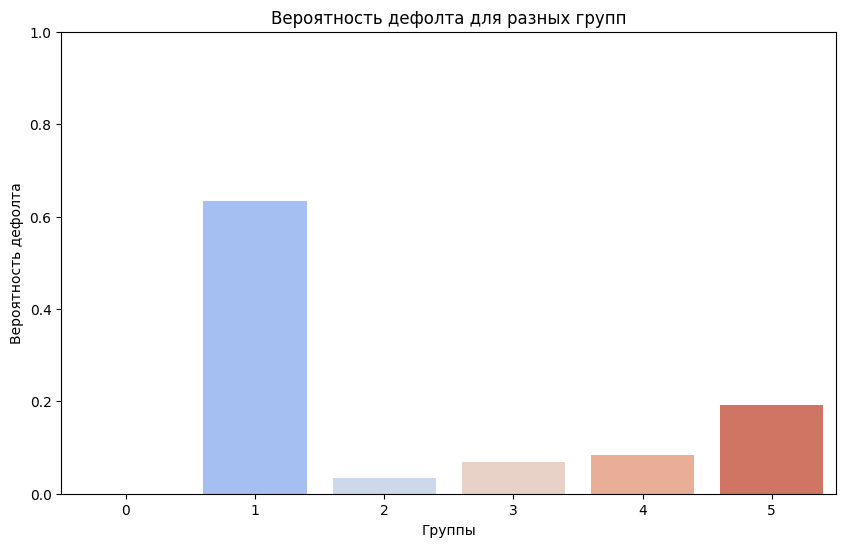

In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции нового признака с целевой переменной...")

# Расчет вероятности дефолта для каждой группы
group_distribution = pd.crosstab(Xtrain_processed['Pledge_Group'], ytrain_extended, normalize='index')
print("Распределение IsDefault среди групп:")
print(group_distribution)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=group_distribution.index, y=group_distribution[1], palette='coolwarm')
plt.title("Вероятность дефолта для разных групп")
plt.ylabel("Вероятность дефолта")
plt.xlabel("Группы")
plt.ylim(0, 1)
plt.show()


Проверка балансировки групп...
Количество строк в каждой группе:
Pledge_Group
0    574
1    574
2    342
3    442
4    524
5    428
Name: count, dtype: int64


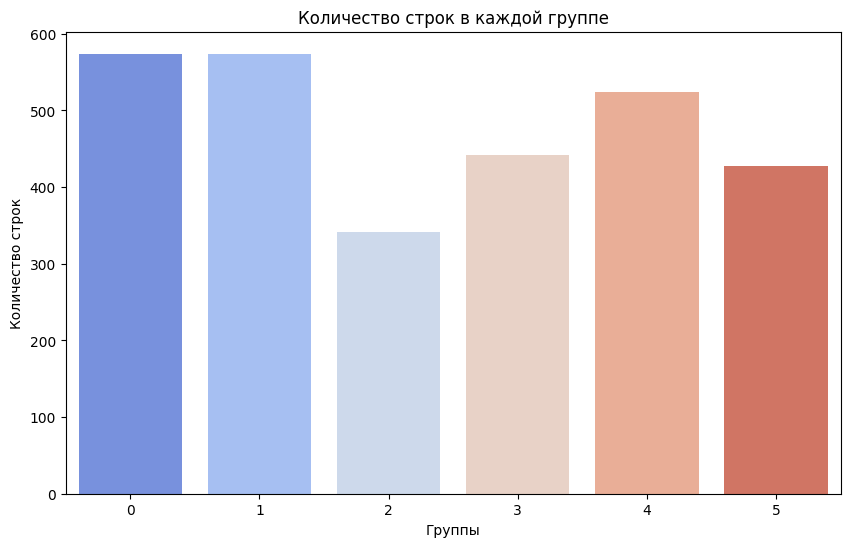

In [ ]:
# ================== ПРОВЕРКА БАЛАНСИРОВКИ ГРУПП ==================
print("\nПроверка балансировки групп...")

# Подсчет количества строк в каждой группе
group_counts = Xtrain_processed['Pledge_Group'].value_counts().sort_index()
print("Количество строк в каждой группе:")
print(group_counts)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=group_counts.index, y=group_counts.values, palette='coolwarm')
plt.title("Количество строк в каждой группе")
plt.ylabel("Количество строк")
plt.xlabel("Группы")
plt.show()

In [ ]:
# ================== СОЗДАНИЕ НОВОГО ПРИЗНАКА ДЛЯ ТЕСТОВЫХ ДАННЫХ ==================
print("\nСоздание нового категориального признака для тестовых данных...")

# Функция для определения группы (уже определена ранее)
def assign_group(value):
    if value == 0.0:
        return 0  # Category_0
    elif value >= 0.7926:
        return 1  # Category_1
    else:
        # Определяем интервал для промежуточных групп
        thresholds = [0.0, 0.2, 0.4, 0.6, 0.7926]
        for i in range(len(thresholds) - 1):
            if thresholds[i] <= value < thresholds[i + 1]:
                return i + 2  # Group_2, Group_3, Group_4, Group_5
        return 5  # Fallback для крайних случаев

# Применяем функцию к тестовым данным
Xtest_processed['Pledge_Group'] = Xtest_processed['Share pledge ratio of controlling shareholders'].apply(assign_group)

print("Новый категориальный признак создан для тестовых данных.")


Создание нового категориального признака для тестовых данных...
Новый категориальный признак создан для тестовых данных.


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 70)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 70)
Размеры датасетов проверены.



Анализ корреляции нового признака с целевой переменной...
Распределение IsDefault среди групп:
IsDefault            0         1
Pledge_Group                    
0             1.000000  0.000000
1             0.365854  0.634146
2             0.964912  0.035088
3             0.932127  0.067873
4             0.916031  0.083969
5             0.808411  0.191589


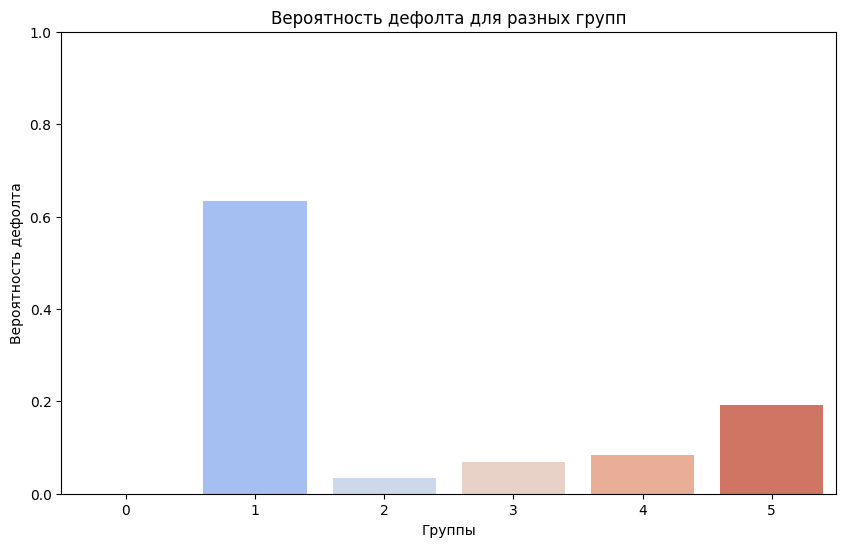

In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции нового признака с целевой переменной...")

# Расчет вероятности дефолта для каждой группы
group_distribution = pd.crosstab(Xtrain_processed['Pledge_Group'], ytrain_extended, normalize='index')
print("Распределение IsDefault среди групп:")
print(group_distribution)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=group_distribution.index, y=group_distribution[1], palette='coolwarm')
plt.title("Вероятность дефолта для разных групп")
plt.ylabel("Вероятность дефолта")
plt.xlabel("Группы")
plt.ylim(0, 1)
plt.show()


Проверка балансировки групп для тестовых данных...
Количество строк в каждой группе (тестовые данные):
Pledge_Group
0     1
1    50
2    24
3    35
4    50
5    24
Name: count, dtype: int64


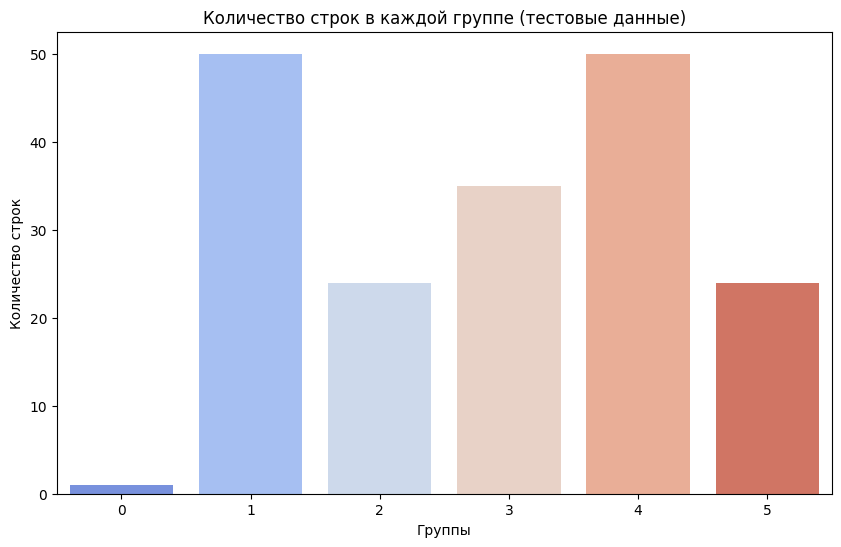

In [ ]:
# ================== ПРОВЕРКА БАЛАНСИРОВКИ ГРУПП ДЛЯ ТЕСТОВЫХ ДАННЫХ ==================
print("\nПроверка балансировки групп для тестовых данных...")

# Подсчет количества строк в каждой группе
group_counts_test = Xtest_processed['Pledge_Group'].value_counts().sort_index()
print("Количество строк в каждой группе (тестовые данные):")
print(group_counts_test)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=group_counts_test.index, y=group_counts_test.values, palette='coolwarm')
plt.title("Количество строк в каждой группе (тестовые данные)")
plt.ylabel("Количество строк")
plt.xlabel("Группы")
plt.show()

In [ ]:
# ================== ОБНОВЛЕНИЕ СПИСКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nОбновление списка категориальных признаков...")

# Добавляем новый признак в список категориальных
categorical_features_str.append('Pledge_Group')

print(f"Обновленный список категориальных признаков: {categorical_features_str}")


Обновление списка категориальных признаков...
Обновленный список категориальных признаков: ['audit opinion ', 'Number of key audit matters', 'Anomaly', 'Pledge_Group']



Анализ корреляции исходного признака с целевой переменной...


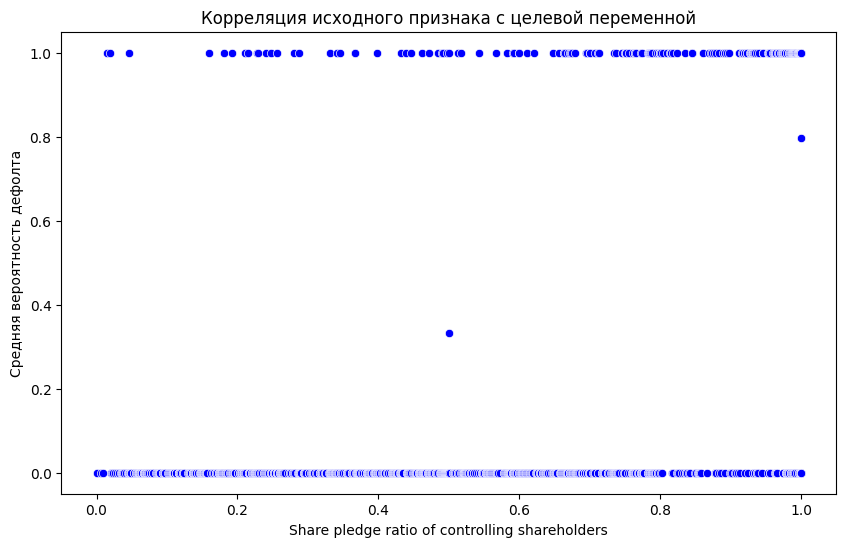

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции исходного признака с целевой переменной...")

# Создаем DataFrame, объединяющий признак и целевую переменную
correlation_data = pd.DataFrame({
    'Share pledge ratio of controlling shareholders': Xtrain_processed['Share pledge ratio of controlling shareholders'],
    'IsDefault': ytrain_extended  # Используем целевую переменную
})

# Расчет средней вероятности дефолта для каждого уникального значения признака
correlation_analysis = correlation_data.groupby('Share pledge ratio of controlling shareholders')['IsDefault'].mean().reset_index()

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(data=correlation_analysis, x='Share pledge ratio of controlling shareholders', y='IsDefault', color='blue')
plt.title("Корреляция исходного признака с целевой переменной")
plt.xlabel("Share pledge ratio of controlling shareholders")
plt.ylabel("Средняя вероятность дефолта")
plt.show()

In [ ]:
# Удаляем новый признак
Xtrain_processed.drop(columns=['Pledge_Group'], inplace=True)
Xtest_processed.drop(columns=['Pledge_Group'], inplace=True)

print("Новый признак удален.")

Новый признак удален.


In [ ]:
# ================== УДАЛЕНИЕ ПРИЗНАКА ИЗ СПИСКА КАТЕГОРИАЛЬНЫХ ==================
print("\nУдаление нового признака из списка категориальных...")

# Удаляем признак из списка категориальных
if 'Pledge_Group' in categorical_features_str:
    categorical_features_str.remove('Pledge_Group')

print(f"Обновленный список категориальных признаков: {categorical_features_str}")


Удаление нового признака из списка категориальных...
Обновленный список категориальных признаков: ['audit opinion ', 'Number of key audit matters', 'Anomaly']


In [ ]:
# ================== УДАЛЕНИЕ ДУБЛИКАТОВ ИЗ СПИСКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nУдаление дубликатов из списка категориальных признаков...")

# Удаляем дубликаты, сохраняя порядок
categorical_features_str = list(dict.fromkeys(categorical_features_str))

print(f"Обновленный список категориальных признаков: {categorical_features_str}")


Удаление дубликатов из списка категориальных признаков...
Обновленный список категориальных признаков: ['audit opinion ', 'Number of key audit matters', 'Anomaly']


In [ ]:
from catboost import Pool, CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ CATBOOST ==================
print("\nОбучение модели CatBoost...")

# Разделяем данные на тренировочную и валидационную части
X_train, X_val, y_train, y_val = train_test_split(
    Xtrain_processed,  # Признаки
    ytrain_extended,   # Целевая переменная
    test_size=0.2,
    random_state=42
)

# Создаем Pool для тренировочных данных
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_str)

# Создаем Pool для валидационных данных
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features_str)

# Обучение модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,
    eval_metric="F1",
    auto_class_weights="Balanced"
)
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Обучение модели CatBoost...
Learning rate set to 0.038957
0:	learn: 0.8432605	test: 0.8203744	best: 0.8203744 (0)	total: 14.1ms	remaining: 14s
100:	learn: 0.9984060	test: 0.9826852	best: 0.9826852 (100)	total: 1.01s	remaining: 8.99s
200:	learn: 1.0000000	test: 0.9902913	best: 0.9902913 (142)	total: 1.95s	remaining: 7.75s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 2.89s	remaining: 6.71s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 3.78s	remaining: 5.65s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 4.65s	remaining: 4.63s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 5.5s	remaining: 3.65s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 6.34s	remaining: 2.71s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 7.19s	remaining: 1.78s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (288)	total: 8.03s	remaining: 882ms
999:	learn: 1.0000000	test: 1.0000000	best: 1.0

In [ ]:
# ================== ПРЕДСКАЗАНИЯ ДЛЯ ТЕСТОВОГО ДАТАСЕТА ==================
print("\nПолучение предсказаний для тестового датасета...")

# Создаем Pool для тестового датасета
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_cleaned.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_cleaned.csv")


Получение предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_cleaned.csv



Анализ распределения значений признака Current ratio...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


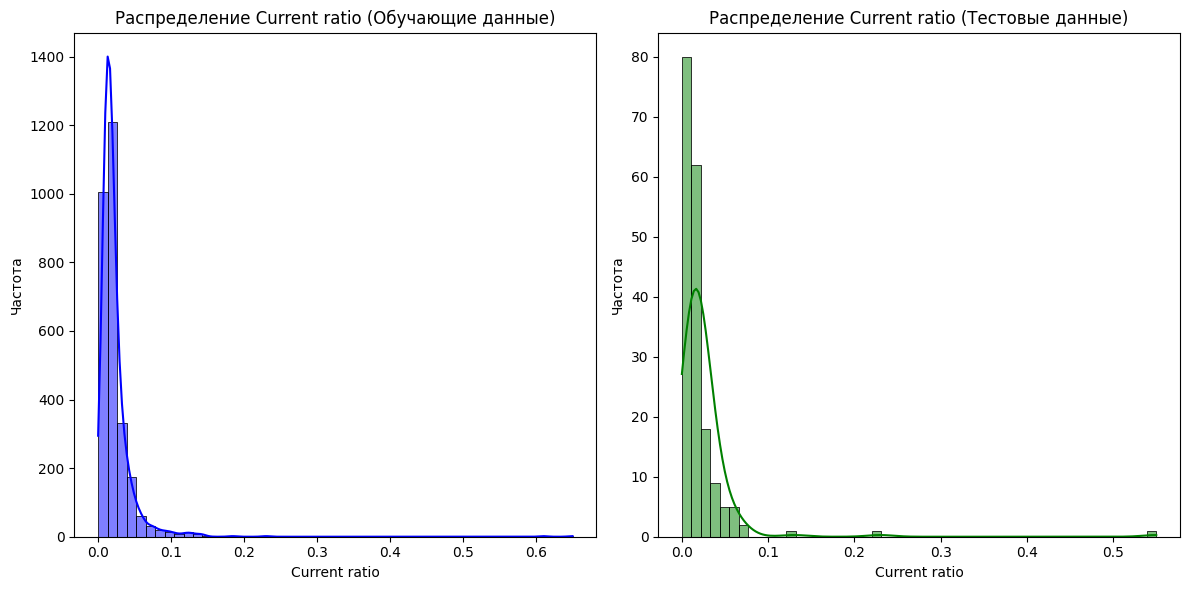


Описательная статистика для Current ratio (Обучающие данные):
count    2884.000000
mean        0.022921
std         0.030073
min         0.000000
25%         0.010936
50%         0.016445
75%         0.025061
max         0.650000
Name: Current ratio, dtype: float64

Описательная статистика для Current ratio (Тестовые данные):
count    184.000000
mean       0.024402
std        0.044717
min        0.000000
25%        0.010000
50%        0.020000
75%        0.020000
max        0.550000
Name: Current ratio, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЗНАЧЕНИЙ ==================
print("\nАнализ распределения значений признака Current ratio...")

# Обучающие данные
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(Xtrain_processed['Current ratio'], bins=50, kde=True, color='blue')
plt.title("Распределение Current ratio (Обучающие данные)")
plt.xlabel("Current ratio")
plt.ylabel("Частота")

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(Xtest_processed['Current ratio'], bins=50, kde=True, color='green')
plt.title("Распределение Current ratio (Тестовые данные)")
plt.xlabel("Current ratio")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Описательная статистика
print("\nОписательная статистика для Current ratio (Обучающие данные):")
print(Xtrain_processed['Current ratio'].describe())

print("\nОписательная статистика для Current ratio (Тестовые данные):")
print(Xtest_processed['Current ratio'].describe())

In [ ]:
# ================== ВЫЧИСЛЕНИЕ 95-ГО ПРОЦЕНТИЛЯ ==================
print("\nВычисление 95-го процентиля для 'Current ratio'...")

# Вычисляем 95-й процентиль
percentile_95 = Xtrain_processed['Current ratio'].quantile(0.95)
print(f"95-й процентиль для 'Current ratio': {percentile_95:.4f}")


Вычисление 95-го процентиля для 'Current ratio'...
95-й процентиль для 'Current ratio': 0.0574


In [ ]:
import numpy as np

# ================== ЛОГАРИФМИРОВАНИЕ ЗНАЧЕНИЙ С МАЛЫМ СМЕЩЕНИЕМ ==================
print("\nПрименение логарифмирования к 'Current ratio' с малым смещением...")

# Применяем логарифмирование (добавляем малое смещение ε)
epsilon = 1e-6
current_ratio_log_train = np.log(Xtrain_processed['Current ratio'] + epsilon)
current_ratio_log_test = np.log(Xtest_processed['Current ratio'] + epsilon)

print("Логарифмирование применено.")


Применение логарифмирования к 'Current ratio' с малым смещением...
Логарифмирование применено.



Анализ распределения логарифмированных значений...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


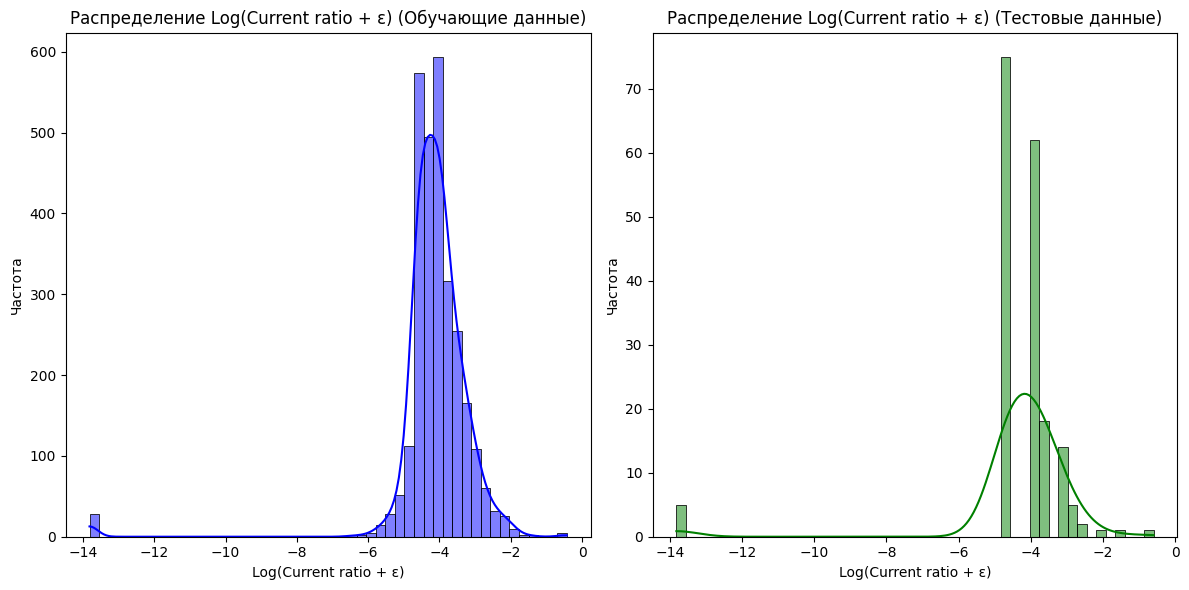


Описательная статистика для логарифмированных значений (Обучающие данные):
count    2884.000000
mean       -4.122837
std         1.155073
min       -13.815511
25%        -4.515604
50%        -4.107673
75%        -3.686403
max        -0.430781
Name: Current ratio, dtype: float64

Описательная статистика для логарифмированных значений (Тестовые данные):
count    184.000000
mean      -4.280212
std        1.721900
min      -13.815511
25%       -4.605070
50%       -3.911973
75%       -3.911973
max       -0.597835
Name: Current ratio, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЛОГАРИФМИРОВАННЫХ ЗНАЧЕНИЙ ==================
print("\nАнализ распределения логарифмированных значений...")

# Обучающие данные
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(current_ratio_log_train, bins=50, kde=True, color='blue')
plt.title("Распределение Log(Current ratio + ε) (Обучающие данные)")
plt.xlabel("Log(Current ratio + ε)")
plt.ylabel("Частота")

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(current_ratio_log_test, bins=50, kde=True, color='green')
plt.title("Распределение Log(Current ratio + ε) (Тестовые данные)")
plt.xlabel("Log(Current ratio + ε)")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Описательная статистика
print("\nОписательная статистика для логарифмированных значений (Обучающие данные):")
print(current_ratio_log_train.describe())

print("\nОписательная статистика для логарифмированных значений (Тестовые данные):")
print(current_ratio_log_test.describe())


Анализ выбросов для 'Current ratio'...
95-й процентиль для 'Current ratio': 0.0574
Количество выбросов в обучающих данных: 144
Количество выбросов в тестовых данных: 10


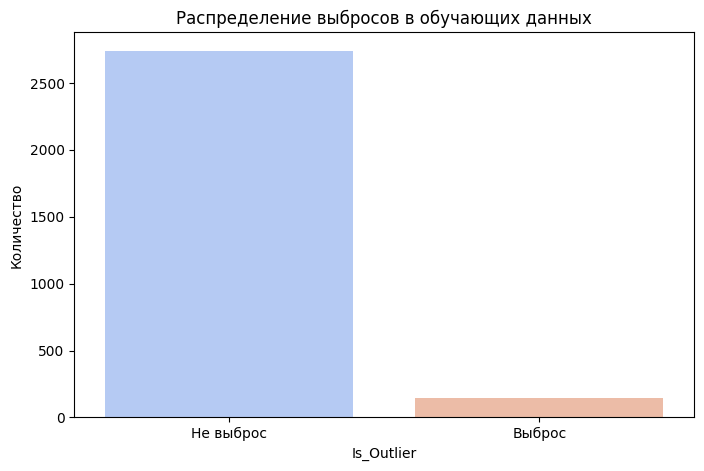

In [ ]:
# ================== АНАЛИЗ ВЫБРОСОВ ==================
print("\nАнализ выбросов для 'Current ratio'...")

# Вычисляем 95-й процентиль
percentile_95 = Xtrain_processed['Current ratio'].quantile(0.95)
print(f"95-й процентиль для 'Current ratio': {percentile_95:.4f}")

# Создаем временный признак для обозначения выбросов
is_outlier_train = (Xtrain_processed['Current ratio'] > percentile_95).astype(int)
is_outlier_test = (Xtest_processed['Current ratio'] > percentile_95).astype(int)

# Подсчет количества выбросов
train_outliers_count = is_outlier_train.sum()
test_outliers_count = is_outlier_test.sum()

print(f"Количество выбросов в обучающих данных: {train_outliers_count}")
print(f"Количество выбросов в тестовых данных: {test_outliers_count}")

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(x=is_outlier_train, palette='coolwarm')
plt.title("Распределение выбросов в обучающих данных")
plt.xlabel("Is_Outlier")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Не выброс', 'Выброс'])
plt.show()


Анализ корреляции выбросов с целевой переменной...
Корреляция выбросов с целевой переменной:
   Is_Outlier  IsDefault
0           0   0.188321
1           1   0.111111


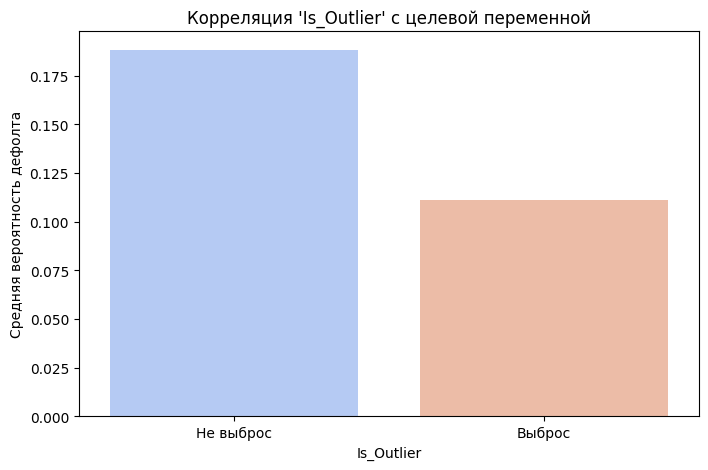

In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ВЫБРОСОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции выбросов с целевой переменной...")

# Создаем DataFrame для анализа
outlier_correlation_data = pd.DataFrame({
    'Is_Outlier': is_outlier_train,
    'IsDefault': ytrain_extended
})

# Группируем данные по значениям Is_Outlier
outlier_correlation_analysis = outlier_correlation_data.groupby('Is_Outlier')['IsDefault'].mean().reset_index()

# Вывод цифровых значений
print("Корреляция выбросов с целевой переменной:")
print(outlier_correlation_analysis)

# Визуализация
plt.figure(figsize=(8, 5))
sns.barplot(data=outlier_correlation_analysis, x='Is_Outlier', y='IsDefault', palette='coolwarm')
plt.title("Корреляция 'Is_Outlier' с целевой переменной")
plt.xlabel("Is_Outlier")
plt.ylabel("Средняя вероятность дефолта")
plt.xticks([0, 1], ['Не выброс', 'Выброс'])
plt.show()


Анализ корреляции логарифмированных значений с целевой переменной...
Корреляция логарифмированных значений с целевой переменной:
    Log_Current_Ratio  IsDefault
0  (-13.829, -12.477]   1.000000
1  (-12.477, -11.139]        NaN
2     (-11.139, -9.8]        NaN
3      (-9.8, -8.462]        NaN
4    (-8.462, -7.123]        NaN
5    (-7.123, -5.785]   0.000000
6    (-5.785, -4.446]   0.356410
7    (-4.446, -3.108]   0.108553
8    (-3.108, -1.769]   0.093220
9    (-1.769, -0.431]   0.750000


<ipython-input-88-88ec825f2dd0>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  log_correlation_analysis = log_correlation_data.groupby(
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The 

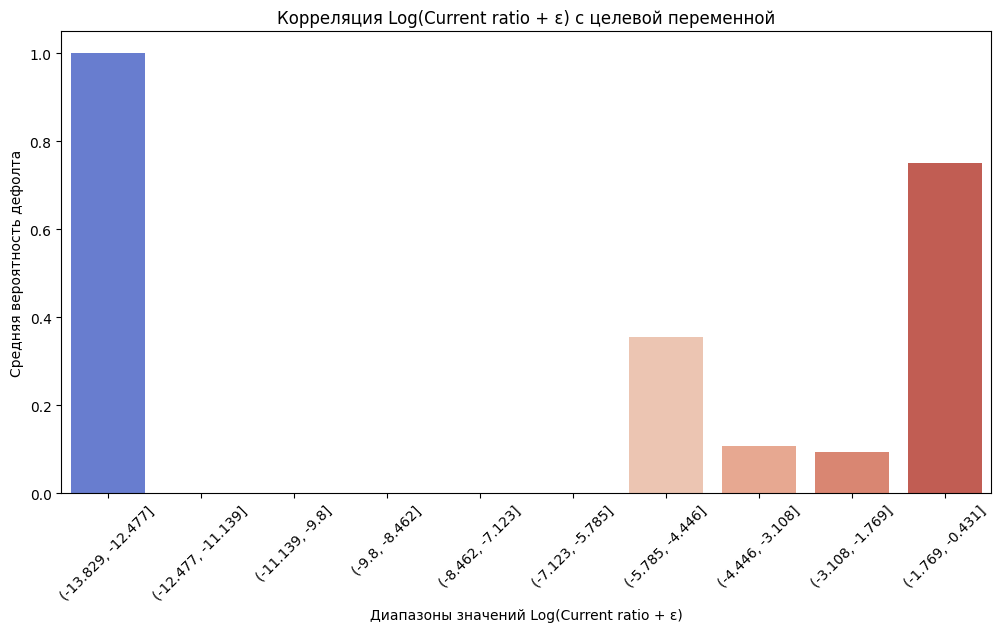

In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ЛОГАРИФМИРОВАННЫХ ЗНАЧЕНИЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции логарифмированных значений с целевой переменной...")

# Создаем DataFrame для анализа
log_correlation_data = pd.DataFrame({
    'Log_Current_Ratio': current_ratio_log_train,
    'IsDefault': ytrain_extended
})

# Группируем данные по диапазонам логарифмированных значений
log_correlation_analysis = log_correlation_data.groupby(
    pd.cut(log_correlation_data['Log_Current_Ratio'], bins=10)
)['IsDefault'].mean().reset_index()

# Вывод цифровых значений
print("Корреляция логарифмированных значений с целевой переменной:")
print(log_correlation_analysis)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(data=log_correlation_analysis, x='Log_Current_Ratio', y='IsDefault', palette='coolwarm')
plt.title("Корреляция Log(Current ratio + ε) с целевой переменной")
plt.xlabel("Диапазоны значений Log(Current ratio + ε)")
plt.ylabel("Средняя вероятность дефолта")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# ================== ВЫЧИСЛЕНИЕ 5-ГО И 95-ГО ПРОЦЕНТИЛЕЙ ДЛЯ ЛОГАРИФМИРОВАННЫХ ЗНАЧЕНИЙ ==================
print("\nВычисление 5-го и 95-го процентилей для логарифмированных значений 'Current ratio'...")

# Вычисляем 5-й и 95-й процентили
log_percentile_5 = current_ratio_log_train.quantile(0.05)
log_percentile_95 = current_ratio_log_train.quantile(0.95)

print(f"5-й процентиль для логарифмированных значений: {log_percentile_5:.4f}")
print(f"95-й процентиль для логарифмированных значений: {log_percentile_95:.4f}")


Вычисление 5-го и 95-го процентилей для логарифмированных значений 'Current ratio'...
5-й процентиль для логарифмированных значений: -4.9373
95-й процентиль для логарифмированных значений: -2.8581



Определение выбросов для логарифмированных значений на основе 5-го и 95-го процентилей...
Количество выбросов в обучающих данных: 288
Количество выбросов в тестовых данных: 15


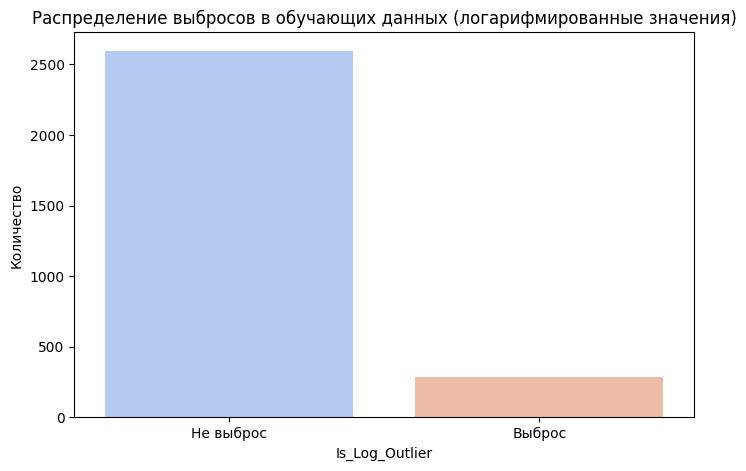

In [ ]:
# ================== ОПРЕДЕЛЕНИЕ ВЫБРОСОВ ДЛЯ ЛОГАРИФМИРОВАННЫХ ЗНАЧЕНИЙ ==================
print("\nОпределение выбросов для логарифмированных значений на основе 5-го и 95-го процентилей...")

# Создаем временный признак для обозначения выбросов
is_log_outlier_train = (
    (current_ratio_log_train < log_percentile_5) |
    (current_ratio_log_train > log_percentile_95)
).astype(int)

is_log_outlier_test = (
    (current_ratio_log_test < log_percentile_5) |
    (current_ratio_log_test > log_percentile_95)
).astype(int)

# Подсчет количества выбросов
train_log_outliers_count = is_log_outlier_train.sum()
test_log_outliers_count = is_log_outlier_test.sum()

print(f"Количество выбросов в обучающих данных: {train_log_outliers_count}")
print(f"Количество выбросов в тестовых данных: {test_log_outliers_count}")

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(x=is_log_outlier_train, palette='coolwarm')
plt.title("Распределение выбросов в обучающих данных (логарифмированные значения)")
plt.xlabel("Is_Log_Outlier")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Не выброс', 'Выброс'])
plt.show()


Анализ логарифмированных значений с учетом новых выбросов...
Корреляция логарифмированных значений с целевой переменной (с учетом новых выбросов):
     Log_Current_Ratio  Is_Log_Outlier  IsDefault
0   (-13.829, -12.477]               0        NaN
1   (-13.829, -12.477]               1   1.000000
2   (-12.477, -11.139]               0        NaN
3   (-12.477, -11.139]               1        NaN
4      (-11.139, -9.8]               0        NaN
5      (-11.139, -9.8]               1        NaN
6       (-9.8, -8.462]               0        NaN
7       (-9.8, -8.462]               1        NaN
8     (-8.462, -7.123]               0        NaN
9     (-8.462, -7.123]               1        NaN
10    (-7.123, -5.785]               0        NaN
11    (-7.123, -5.785]               1   0.000000
12    (-5.785, -4.446]               0   0.413690
13    (-5.785, -4.446]               1   0.000000
14    (-4.446, -3.108]               0   0.108553
15    (-4.446, -3.108]               1        NaN
16

<ipython-input-91-e083afcf5904>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  log_outlier_analysis = log_outlier_data.groupby(
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default 

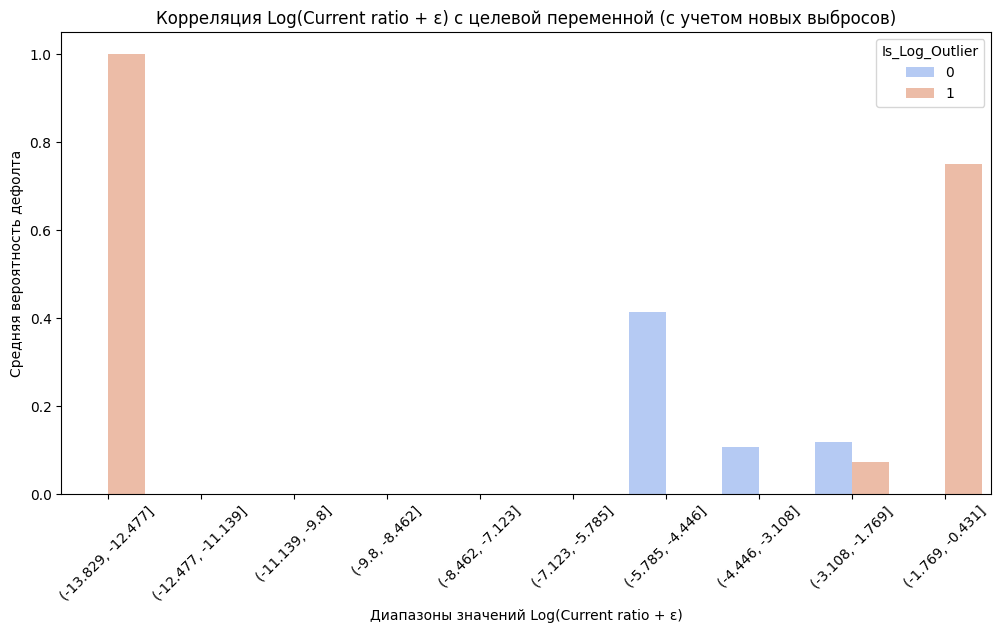

In [ ]:
# ================== АНАЛИЗ ЛОГАРИФМИРОВАННЫХ ЗНАЧЕНИЙ С УЧЕТОМ ВЫБРОСОВ ==================
print("\nАнализ логарифмированных значений с учетом новых выбросов...")

# Добавляем логарифмированные значения и признак Is_Log_Outlier в DataFrame
log_outlier_data = pd.DataFrame({
    'Log_Current_Ratio': current_ratio_log_train,
    'Is_Log_Outlier': is_log_outlier_train,
    'IsDefault': ytrain_extended
})

# Группируем данные по Is_Log_Outlier и диапазонам логарифмированных значений
log_outlier_analysis = log_outlier_data.groupby(
    [pd.cut(log_outlier_data['Log_Current_Ratio'], bins=10), 'Is_Log_Outlier']
)['IsDefault'].mean().reset_index()

# Вывод цифровых значений
print("Корреляция логарифмированных значений с целевой переменной (с учетом новых выбросов):")
print(log_outlier_analysis)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(data=log_outlier_analysis, x='Log_Current_Ratio', y='IsDefault', hue='Is_Log_Outlier', palette='coolwarm')
plt.title("Корреляция Log(Current ratio + ε) с целевой переменной (с учетом новых выбросов)")
plt.xlabel("Диапазоны значений Log(Current ratio + ε)")
plt.ylabel("Средняя вероятность дефолта")
plt.xticks(rotation=45)
plt.legend(title="Is_Log_Outlier")
plt.show()

In [ ]:
# ================== ОГРАНИЧЕНИЕ ЗНАЧЕНИЙ 'CURRENT RATIO' ==================
print("\nОграничение значений 'Current ratio' на уровне 95-го процентиля...")

# Вычисляем 95-й процентиль
percentile_95 = Xtrain_processed['Current ratio'].quantile(0.95)

# Обрезаем значения выше 95-го процентиля
current_ratio_clipped_train = Xtrain_processed['Current ratio'].clip(upper=percentile_95)
current_ratio_clipped_test = Xtest_processed['Current ratio'].clip(upper=percentile_95)

print(f"Значения 'Current ratio' ограничены порогом {percentile_95:.4f}.")


Ограничение значений 'Current ratio' на уровне 95-го процентиля...
Значения 'Current ratio' ограничены порогом 0.0574.



Анализ распределения нового признака 'Current_ratio_clipped'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


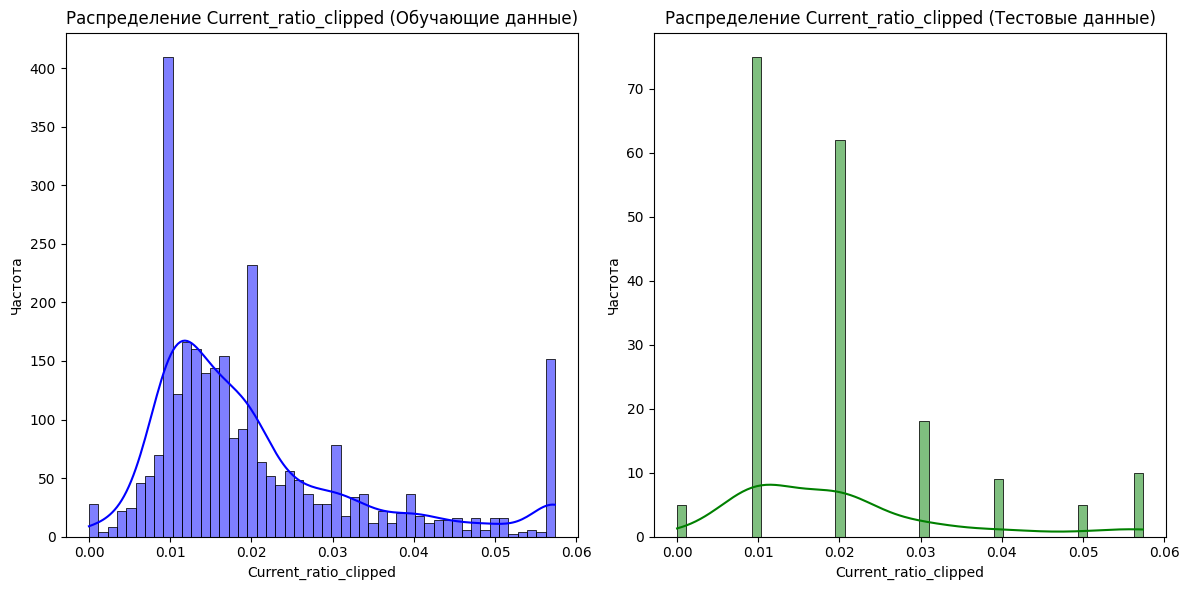


Описательная статистика для 'Current_ratio_clipped' (Обучающие данные):
count    2884.000000
mean        0.020561
std         0.013392
min         0.000000
25%         0.010936
50%         0.016445
75%         0.025061
max         0.057379
Name: Current ratio, dtype: float64

Описательная статистика для 'Current_ratio_clipped' (Тестовые данные):
count    184.000000
mean       0.020184
std        0.013503
min        0.000000
25%        0.010000
50%        0.020000
75%        0.020000
max        0.057379
Name: Current ratio, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ 'CURRENT_RATIO_CLIPPED' ==================
print("\nАнализ распределения нового признака 'Current_ratio_clipped'...")

# Обучающие данные
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(current_ratio_clipped_train, bins=50, kde=True, color='blue')
plt.title("Распределение Current_ratio_clipped (Обучающие данные)")
plt.xlabel("Current_ratio_clipped")
plt.ylabel("Частота")

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(current_ratio_clipped_test, bins=50, kde=True, color='green')
plt.title("Распределение Current_ratio_clipped (Тестовые данные)")
plt.xlabel("Current_ratio_clipped")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Описательная статистика
print("\nОписательная статистика для 'Current_ratio_clipped' (Обучающие данные):")
print(current_ratio_clipped_train.describe())

print("\nОписательная статистика для 'Current_ratio_clipped' (Тестовые данные):")
print(current_ratio_clipped_test.describe())

In [ ]:
# ================== ЛОГАРИФМИРОВАНИЕ ОБРЕЗАННОГО ПРИЗНАКА ==================
print("\nПрименение логарифмирования к 'Current_ratio_clipped'...")

# Применяем логарифмирование с малым смещением ε
epsilon = 1e-6
current_ratio_clipped_log_train = np.log(current_ratio_clipped_train + epsilon)
current_ratio_clipped_log_test = np.log(current_ratio_clipped_test + epsilon)

print("Логарифмирование применено.")


Применение логарифмирования к 'Current_ratio_clipped'...
Логарифмирование применено.



Анализ распределения логарифмированного обрезанного признака...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


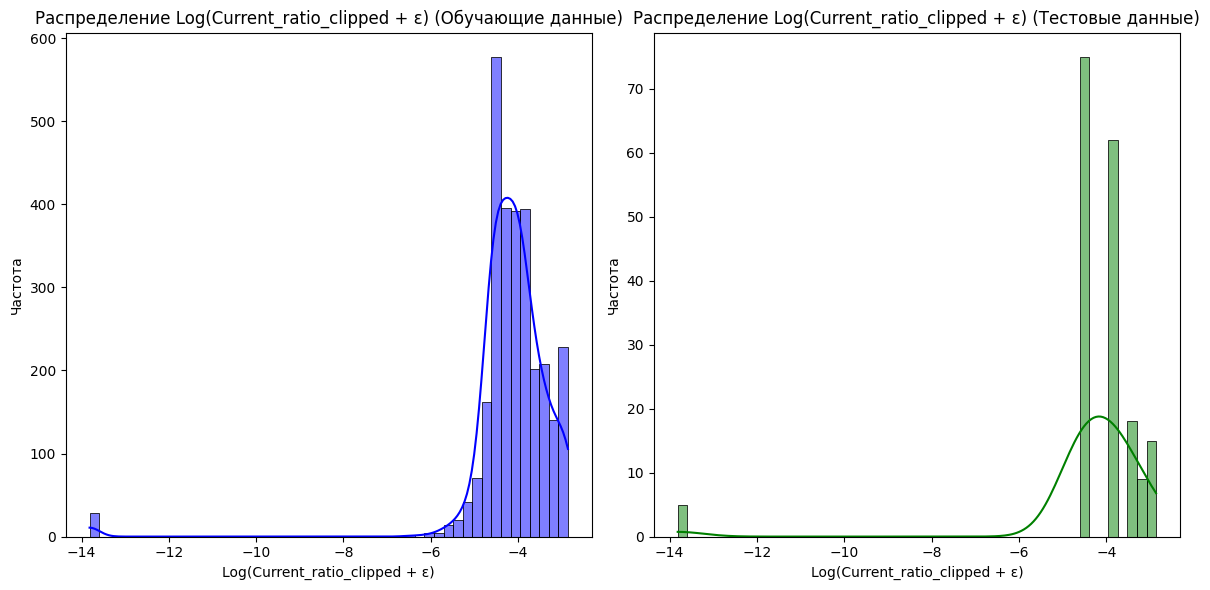


Описательная статистика для логарифмированного обрезанного признака (Обучающие данные):
count    2884.000000
mean       -4.145215
std         1.121082
min       -13.815511
25%        -4.515604
50%        -4.107673
75%        -3.686403
max        -2.858059
Name: Current ratio, dtype: float64

Описательная статистика для логарифмированного обрезанного признака (Тестовые данные):
count    184.000000
mean      -4.307861
std        1.685974
min      -13.815511
25%       -4.605070
50%       -3.911973
75%       -3.911973
max       -2.858059
Name: Current ratio, dtype: float64


In [ ]:
# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ЛОГАРИФМИРОВАННОГО ОБРЕЗАННОГО ПРИЗНАКА ==================
print("\nАнализ распределения логарифмированного обрезанного признака...")

# Обучающие данные
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(current_ratio_clipped_log_train, bins=50, kde=True, color='blue')
plt.title("Распределение Log(Current_ratio_clipped + ε) (Обучающие данные)")
plt.xlabel("Log(Current_ratio_clipped + ε)")
plt.ylabel("Частота")

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(current_ratio_clipped_log_test, bins=50, kde=True, color='green')
plt.title("Распределение Log(Current_ratio_clipped + ε) (Тестовые данные)")
plt.xlabel("Log(Current_ratio_clipped + ε)")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

# Описательная статистика
print("\nОписательная статистика для логарифмированного обрезанного признака (Обучающие данные):")
print(current_ratio_clipped_log_train.describe())

print("\nОписательная статистика для логарифмированного обрезанного признака (Тестовые данные):")
print(current_ratio_clipped_log_test.describe())

In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции с целевой переменной...")

# Создаем DataFrame для анализа
correlation_data = pd.DataFrame({
    'Original': Xtrain_processed['Current ratio'],
    'Clipped': current_ratio_clipped_train,
    'Log_Clipped': current_ratio_clipped_log_train,
    'IsDefault': ytrain_extended
})

# Корреляция с целевой переменной
correlation_analysis = correlation_data.corr()['IsDefault'].reset_index()
correlation_analysis.columns = ['Feature', 'Correlation_with_IsDefault']

# Вывод результатов
print("Корреляция с целевой переменной:")
print(correlation_analysis)


Анализ корреляции с целевой переменной...
Корреляция с целевой переменной:
       Feature  Correlation_with_IsDefault
0     Original                   -0.009932
1      Clipped                   -0.126897
2  Log_Clipped                   -0.229747
3    IsDefault                    1.000000


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 69)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 69)
Размеры датасетов проверены.


In [ ]:
# ================== ДОБАВЛЕНИЕ ЛОГАРИФМИРОВАННОГО ОБРЕЗАННОГО ПРИЗНАКА В ДАННЫЕ ==================
print("\nДобавление логарифмированного обрезанного признака в данные...")

# Добавляем признак в обучающие и тестовые данные
Xtrain_processed['Log_Current_ratio_clipped'] = current_ratio_clipped_log_train
Xtest_processed['Log_Current_ratio_clipped'] = current_ratio_clipped_log_test

print("Логарифмированный обрезанный признак добавлен в данные.")


Добавление логарифмированного обрезанного признака в данные...
Логарифмированный обрезанный признак добавлен в данные.


In [ ]:
# ================== ДОБАВЛЕНИЕ ФЛАГА ДЛЯ ОБРЕЗАННЫХ ЗНАЧЕНИЙ 'CURRENT RATIO' ==================
print("\nДобавление флага для обрезанных значений 'Current ratio'...")

# Вычисляем порог для обрезания (95-й процентиль из обучающих данных)
percentile_95_current_ratio = Xtrain_processed['Current ratio'].quantile(0.95)

# Создаем флаг для обрезанных значений
Xtrain_processed['Is_Clipped_Current_ratio'] = (Xtrain_processed['Current ratio'] > percentile_95_current_ratio).astype(int)
Xtest_processed['Is_Clipped_Current_ratio'] = (Xtest_processed['Current ratio'] > percentile_95_current_ratio).astype(int)

print("Флаг для обрезанных значений 'Current ratio' добавлен в данные.")


Добавление флага для обрезанных значений 'Current ratio'...
Флаг для обрезанных значений 'Current ratio' добавлен в данные.


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 71)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 71)
Размеры датасетов проверены.


In [ ]:
# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ФЛАГА ==================
print("\nАнализ распределения флага для обрезанных значений 'Current ratio'...")

# Распределение флага в обучающих данных
print("Распределение флага в обучающих данных:")
print(Xtrain_processed['Is_Clipped_Current_ratio'].value_counts())

# Распределение флага в тестовых данных
print("\nРаспределение флага в тестовых данных:")
print(Xtest_processed['Is_Clipped_Current_ratio'].value_counts())


Анализ распределения флага для обрезанных значений 'Current ratio'...
Распределение флага в обучающих данных:
Is_Clipped_Current_ratio
0    2740
1     144
Name: count, dtype: int64

Распределение флага в тестовых данных:
Is_Clipped_Current_ratio
0    174
1     10
Name: count, dtype: int64


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ФЛАГА С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции флага с целевой переменной...")

# Корреляция флага с целевой переменной
flag_correlation = Xtrain_processed['Is_Clipped_Current_ratio'].corr(ytrain_extended)

print(f"Корреляция флага с целевой переменной: {flag_correlation:.4f}")


Анализ корреляции флага с целевой переменной...
Корреляция флага с целевой переменной: -0.0434


In [ ]:
# ================== ДОБАВЛЕНИЕ ФЛАГА В СПИСОК КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nДобавление флага 'Is_Clipped_Current_ratio' в список категориальных признаков...")

# Добавляем название флага в список категориальных признаков
categorical_features_str.append('Is_Clipped_Current_ratio')

print(f"Обновленный список категориальных признаков: {categorical_features_str}")


Добавление флага 'Is_Clipped_Current_ratio' в список категориальных признаков...
Обновленный список категориальных признаков: ['audit opinion ', 'Number of key audit matters', 'Anomaly', 'Is_Clipped_Current_ratio']


In [ ]:
from sklearn.model_selection import train_test_split

# ================== РАЗДЕЛЕНИЕ ДАННЫХ НА ТРЕНИРОВОЧНУЮ И ВАЛИДАЦИОННУЮ ЧАСТИ ==================
print("\nРазделение данных на тренировочную и валидационную части...")

# Разделяем данные на тренировочную (80%) и валидационную (20%) части
X_train, X_val, y_train, y_val = train_test_split(
    Xtrain_processed,
    ytrain_extended,
    test_size=0.2,
    random_state=42,
    stratify=ytrain_extended  # Сохраняем баланс классов
)

print("Данные разделены.")


Разделение данных на тренировочную и валидационную части...
Данные разделены.


In [ ]:
from catboost import Pool, CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ CATBOOST ==================
print("\nОбучение модели CatBoost с новым признаком 'Log_Current_ratio_clipped'...")

# Создаем Pool для тренировочных данных
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_str)

# Создаем Pool для валидационных данных
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features_str)

# Настройки модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,               # Вывод логов каждые 100 итераций
    eval_metric="F1",          # Оптимизация F1-score
    auto_class_weights="Balanced"  # Учет дисбаланса классов
)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Обучение модели CatBoost с новым признаком 'Log_Current_ratio_clipped'...
Learning rate set to 0.038957
0:	learn: 0.8836834	test: 0.8785871	best: 0.8785871 (0)	total: 11.4ms	remaining: 11.3s
100:	learn: 0.9986727	test: 0.9957451	best: 0.9957451 (91)	total: 1s	remaining: 8.94s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 2s	remaining: 7.95s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 3.16s	remaining: 7.34s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 4.33s	remaining: 6.47s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 5.26s	remaining: 5.24s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 6.17s	remaining: 4.1s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 7.11s	remaining: 3.03s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 8.03s	remaining: 1.99s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (152)	total: 8.91s	remaining: 979ms
999:	l


Анализ важности признаков...
Важность признаков:
                                           Feature Id  Importances
0                              Financial cycle m2/gdp    25.162446
1                           Log_Current_ratio_clipped    22.075840
2                                       Current ratio    20.294226
3      Share pledge ratio of controlling shareholders     9.482160
4            Ratio of prepayments to operating income     2.285619
5                    Pledge ratio of unlimited shares     2.073369
6                    Monetary capital/short-term debt     1.308575
7                                    Stock Volatility     1.074178
8                        EBITDA/interest bearing debt     1.068457
9                                Debt financing costs     0.884931
10  The proportion of goodwill in total assets exc...     0.829872
11                                            Z-SCORE     0.779960
12                                          Audit fee     0.671667
13         S

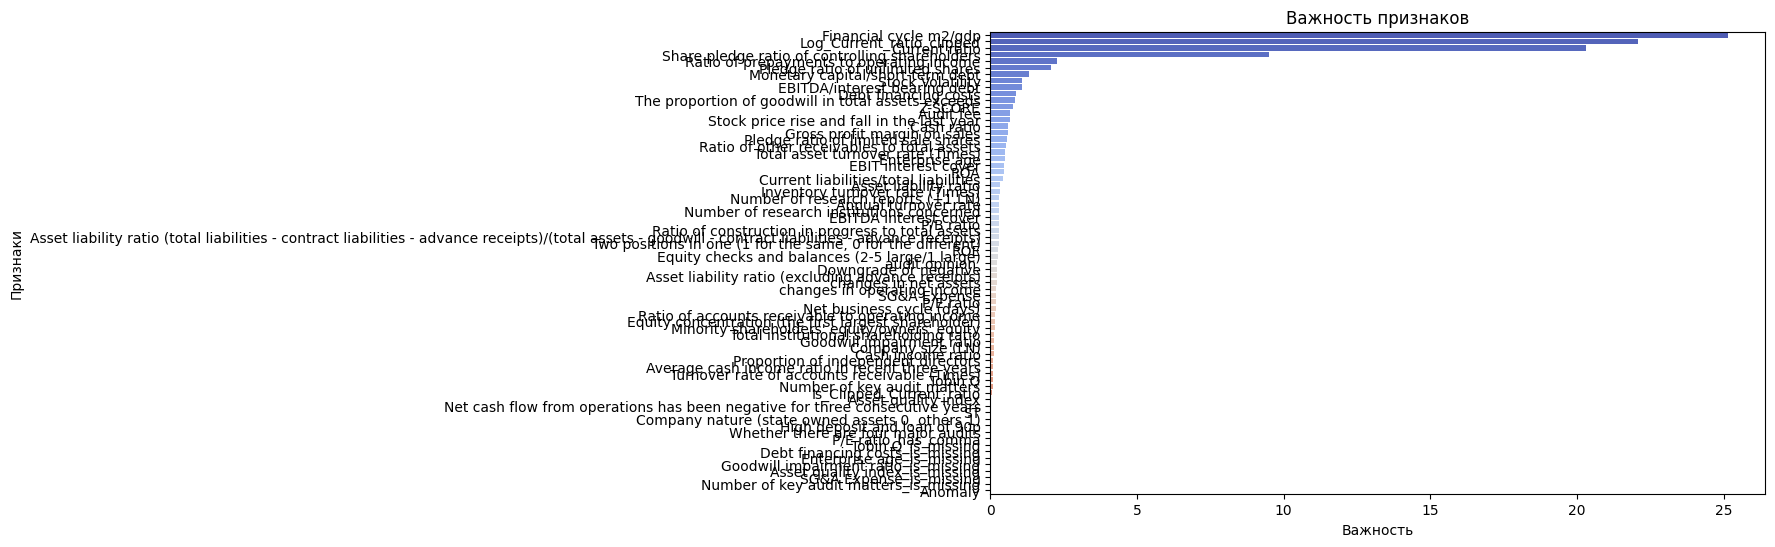

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nАнализ важности признаков...")

# Получаем важность признаков
feature_importance = model.get_feature_importance(prettified=True)
print("Важность признаков:")
print(feature_importance.head(20))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance, palette='coolwarm')
plt.title("Важность признаков")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.show()

In [ ]:
# ================== ПРЕДСКАЗАНИЯ ДЛЯ ТЕСТОВОГО ДАТАСЕТА ==================
print("\nПолучение предсказаний для тестового датасета...")

# Создаем Pool для тестового датасета
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_log_clipped.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_log_clipped.csv")


Получение предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_log_clipped.csv


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ МЕЖДУ 'CURRENT RATIO' И 'LOG_CURRENT_RATIO_CLIPPED' ==================
print("\nАнализ корреляции между 'Current ratio' и 'Log_Current_ratio_clipped'...")

# Создаем DataFrame для анализа
correlation_data = pd.DataFrame({
    'Current_ratio': Xtrain_processed['Current ratio'],
    'Log_Current_ratio_clipped': current_ratio_clipped_log_train
})

# Корреляция между признаками
correlation = correlation_data.corr().iloc[0, 1]

print(f"Корреляция между 'Current ratio' и 'Log_Current_ratio_clipped': {correlation:.4f}")


Анализ корреляции между 'Current ratio' и 'Log_Current_ratio_clipped'...
Корреляция между 'Current ratio' и 'Log_Current_ratio_clipped': 0.3637


In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДЛЯ 'RATIO OF PREPAYMENTS TO OPERATING INCOME' ==================
print("\nОписательная статистика для 'Ratio of prepayments to operating income'...")

# Обучающие данные
print("Обучающие данные:")
print(Xtrain_processed['Ratio of prepayments to operating income'].describe())

# Тестовые данные
print("\nТестовые данные:")
print(Xtest_processed['Ratio of prepayments to operating income'].describe())


Описательная статистика для 'Ratio of prepayments to operating income'...
Обучающие данные:
count    2884.000000
mean        0.054013
std         0.258705
min         0.000000
25%         0.009233
50%         0.019475
75%         0.045400
max         9.021281
Name: Ratio of prepayments to operating income, dtype: float64

Тестовые данные:
count    184.000000
mean       0.085336
std        0.192889
min        0.000900
25%        0.012275
50%        0.029300
75%        0.064800
max        1.586500
Name: Ratio of prepayments to operating income, dtype: float64



Построение гистограмм для 'Ratio of prepayments to operating income'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


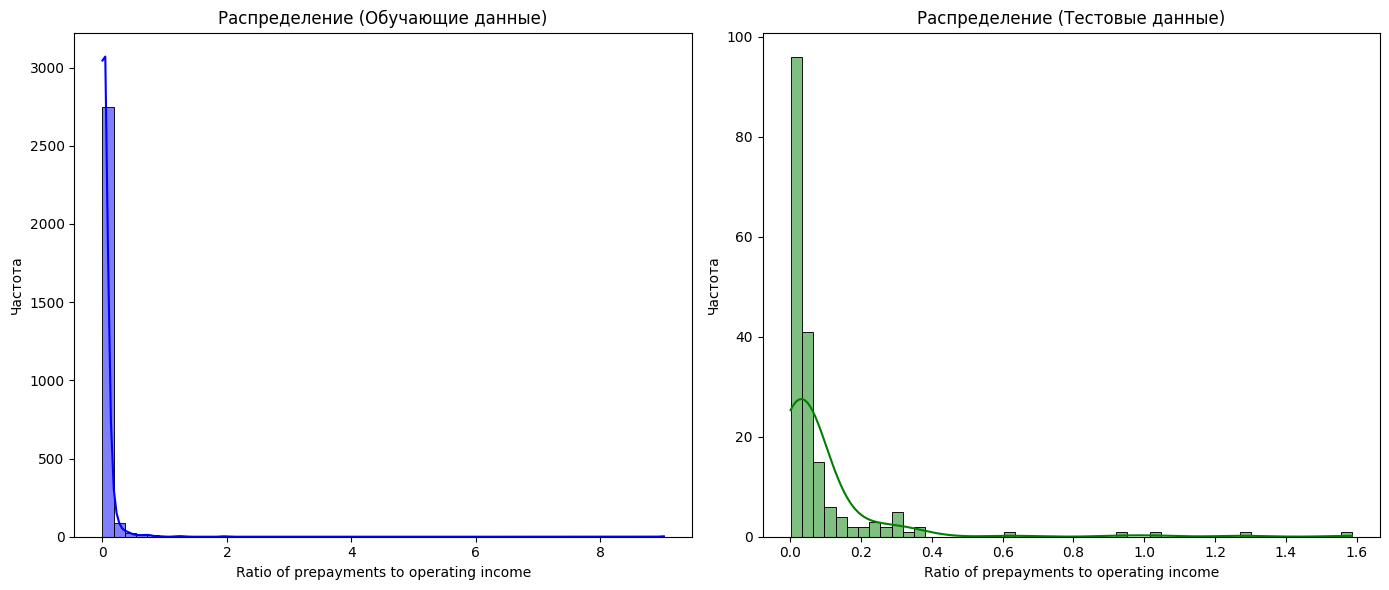

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ НА ОБУЧАЮЩИХ И ТЕСТОВЫХ ДАННЫХ ==================
print("\nПостроение гистограмм для 'Ratio of prepayments to operating income'...")

# Настройка графиков
plt.figure(figsize=(14, 6))

# Гистограмма для обучающих данных
plt.subplot(1, 2, 1)
sns.histplot(Xtrain_processed['Ratio of prepayments to operating income'], bins=50, kde=True, color='blue')
plt.title("Распределение (Обучающие данные)")
plt.xlabel("Ratio of prepayments to operating income")
plt.ylabel("Частота")

# Гистограмма для тестовых данных
plt.subplot(1, 2, 2)
sns.histplot(Xtest_processed['Ratio of prepayments to operating income'], bins=50, kde=True, color='green')
plt.title("Распределение (Тестовые данные)")
plt.xlabel("Ratio of prepayments to operating income")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# ================== АНАЛИЗ ВЫБРОСОВ ==================
print("\nАнализ выбросов для 'Ratio of prepayments to operating income'...")

# Вычисляем 95-й процентиль
percentile_95_train = Xtrain_processed['Ratio of prepayments to operating income'].quantile(0.95)
percentile_95_test = Xtest_processed['Ratio of prepayments to operating income'].quantile(0.95)

print(f"95-й процентиль для обучающих данных: {percentile_95_train:.4f}")
print(f"95-й процентиль для тестовых данных: {percentile_95_test:.4f}")

# Подсчет количества выбросов
train_outliers_count = (Xtrain_processed['Ratio of prepayments to operating income'] > percentile_95_train).sum()
test_outliers_count = (Xtest_processed['Ratio of prepayments to operating income'] > percentile_95_test).sum()

print(f"Количество выбросов в обучающих данных: {train_outliers_count}")
print(f"Количество выбросов в тестовых данных: {test_outliers_count}")


Анализ выбросов для 'Ratio of prepayments to operating income'...
95-й процентиль для обучающих данных: 0.1746
95-й процентиль для тестовых данных: 0.3059
Количество выбросов в обучающих данных: 144
Количество выбросов в тестовых данных: 10


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 71)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 71)
Размеры датасетов проверены.


In [ ]:
# ================== ОГРАНИЧЕНИЕ ЗНАЧЕНИЙ НА УРОВНЕ 95-ГО ПРОЦЕНТИЛЯ ==================
print("\nОграничение значений признака 'Ratio of prepayments to operating income'...")

# Порог для обрезания (95-й процентиль из обучающих данных)
percentile_95_train = Xtrain_processed['Ratio of prepayments to operating income'].quantile(0.95)

# Обрезаем значения выше 95-го процентиля
clipped_ratio_train = Xtrain_processed['Ratio of prepayments to operating income'].clip(upper=percentile_95_train)
clipped_ratio_test = Xtest_processed['Ratio of prepayments to operating income'].clip(upper=percentile_95_train)

print(f"Значения ограничены порогом {percentile_95_train:.4f}.")


Ограничение значений признака 'Ratio of prepayments to operating income'...
Значения ограничены порогом 0.1746.


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 71)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 71)
Размеры датасетов проверены.



Построение гистограмм для обрезанного признака...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


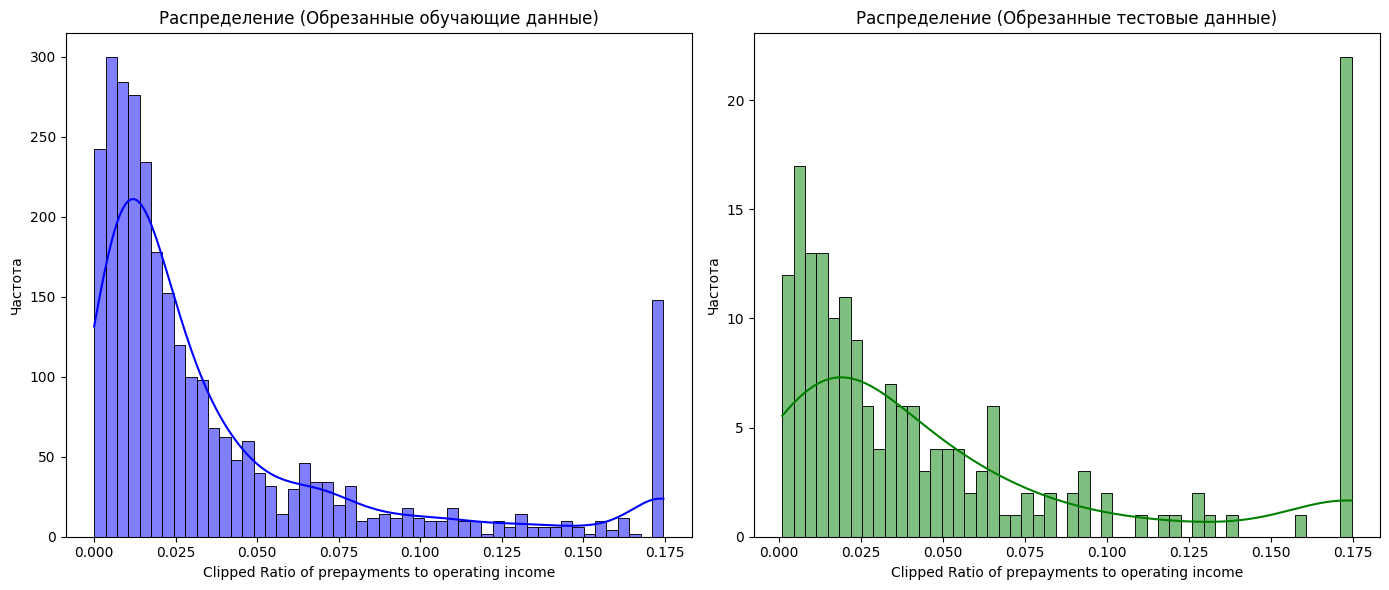

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ПОСЛЕ ОБРЕЗАНИЯ ==================
print("\nПостроение гистограмм для обрезанного признака...")

# Гистограмма и KDE
plt.figure(figsize=(14, 6))

# Обрезанные обучающие данные
plt.subplot(1, 2, 1)
sns.histplot(clipped_ratio_train, bins=50, kde=True, color='blue')
plt.title("Распределение (Обрезанные обучающие данные)")
plt.xlabel("Clipped Ratio of prepayments to operating income")
plt.ylabel("Частота")

# Обрезанные тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(clipped_ratio_test, bins=50, kde=True, color='green')
plt.title("Распределение (Обрезанные тестовые данные)")
plt.xlabel("Clipped Ratio of prepayments to operating income")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДЛЯ ОБРЕЗАННЫХ ДАННЫХ ==================
print("\nОписательная статистика для обрезанного признака...")

# Обрезанные обучающие данные
print("Обрезанные обучающие данные:")
print(clipped_ratio_train.describe())

# Обрезанные тестовые данные
print("\nОбрезанные тестовые данные:")
print(clipped_ratio_test.describe())


Описательная статистика для обрезанного признака...
Обрезанные обучающие данные:
count    2884.000000
mean        0.037760
std         0.045160
min         0.000000
25%         0.009233
50%         0.019475
75%         0.045400
max         0.174600
Name: Ratio of prepayments to operating income, dtype: float64

Обрезанные тестовые данные:
count    184.000000
mean       0.051627
std        0.054646
min        0.000900
25%        0.012275
50%        0.029300
75%        0.064800
max        0.174600
Name: Ratio of prepayments to operating income, dtype: float64


In [ ]:
# ================== УВЕЛИЧЕНИЕ СМЕЩЕНИЯ ПЕРЕД ЛОГАРИФМИРОВАНИЕМ ==================
print("\nУвеличиваем смещение перед логарифмированием...")

# Применяем логарифмирование с новым смещением ε
epsilon_new = 0.001
log_clipped_ratio_train = np.log(clipped_ratio_train + epsilon_new)
log_clipped_ratio_test = np.log(clipped_ratio_test + epsilon_new)

print("Логарифмирование с новым смещением применено.")


Увеличиваем смещение перед логарифмированием...
Логарифмирование с новым смещением применено.



Построение гистограмм для логарифмированного обрезанного признака...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


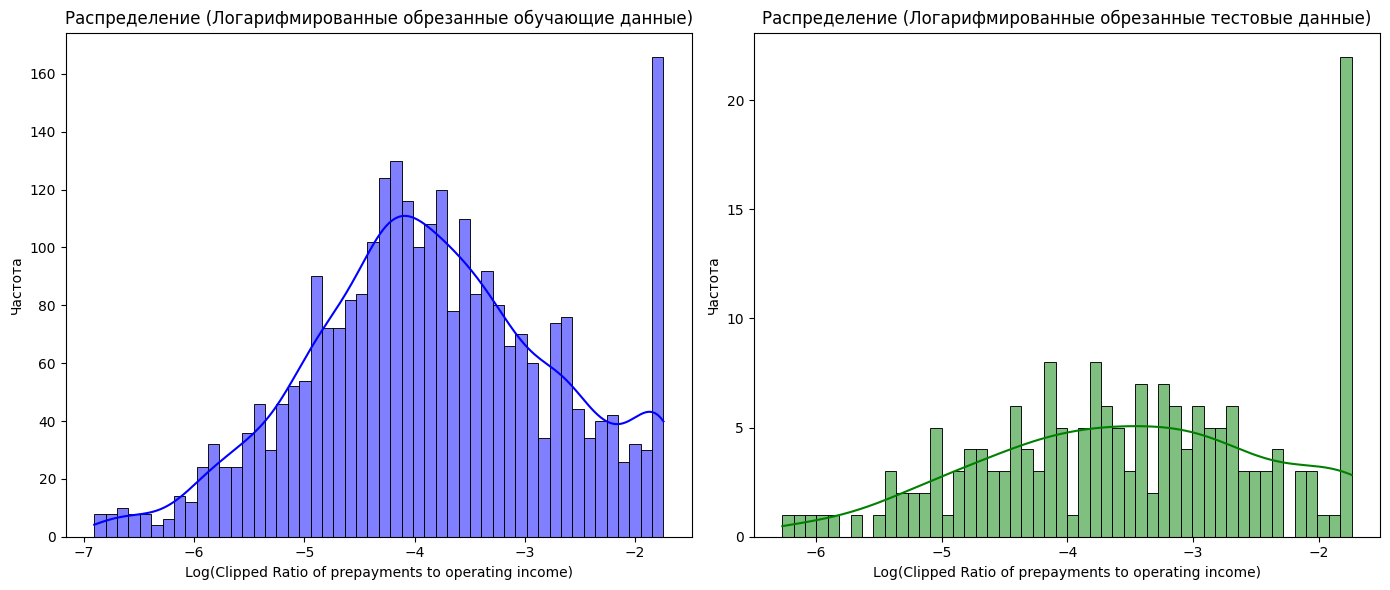

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ВИЗУАЛИЗАЦИЯ ЛОГАРИФМИРОВАННОГО ОБРЕЗАННОГО ПРИЗНАКА ==================
print("\nПостроение гистограмм для логарифмированного обрезанного признака...")

# Гистограмма и KDE
plt.figure(figsize=(14, 6))

# Логарифмированные обучающие данные
plt.subplot(1, 2, 1)
sns.histplot(log_clipped_ratio_train, bins=50, kde=True, color='blue')
plt.title("Распределение (Логарифмированные обрезанные обучающие данные)")
plt.xlabel("Log(Clipped Ratio of prepayments to operating income)")
plt.ylabel("Частота")

# Логарифмированные тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(log_clipped_ratio_test, bins=50, kde=True, color='green')
plt.title("Распределение (Логарифмированные обрезанные тестовые данные)")
plt.xlabel("Log(Clipped Ratio of prepayments to operating income)")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДЛЯ ЛОГАРИФМИРОВАННОГО ОБРЕЗАННОГО ПРИЗНАКА ==================
print("\nОписательная статистика для логарифмированного обрезанного признака...")

# Логарифмированные обучающие данные
print("Логарифмированные обрезанные обучающие данные:")
print(log_clipped_ratio_train.describe())

# Логарифмированные тестовые данные
print("\nЛогарифмированные обрезанные тестовые данные:")
print(log_clipped_ratio_test.describe())


Описательная статистика для логарифмированного обрезанного признака...
Логарифмированные обрезанные обучающие данные:
count    2884.000000
mean       -3.840675
std         1.121073
min        -6.907755
25%        -4.582176
50%        -3.888568
75%        -3.070456
max        -1.739547
Name: Ratio of prepayments to operating income, dtype: float64

Логарифмированные обрезанные тестовые данные:
count    184.000000
mean      -3.511290
std        1.137540
min       -6.265901
25%       -4.321878
50%       -3.496657
75%       -2.721166
max       -1.739547
Name: Ratio of prepayments to operating income, dtype: float64


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции с целевой переменной...")

# Вычисляем корреляцию между новым признаком и целевой переменной
correlation = log_clipped_ratio_train.corr(ytrain_extended)

print(f"Корреляция с целевой переменной (обучающие данные): {correlation:.4f}")


Анализ корреляции с целевой переменной...
Корреляция с целевой переменной (обучающие данные): 0.3546


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ИСХОДНОГО ПРИЗНАКА ==================
print("\nАнализ корреляции исходного признака с целевой переменной...")

# Вычисляем корреляцию между исходным признаком и целевой переменной
original_correlation = Xtrain_processed['Ratio of prepayments to operating income'].corr(ytrain_extended)

print(f"Корреляция исходного признака с целевой переменной: {original_correlation:.4f}")


Анализ корреляции исходного признака с целевой переменной...
Корреляция исходного признака с целевой переменной: 0.1053


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 71)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 71)
Размеры датасетов проверены.


In [ ]:
# ================== ДОБАВЛЕНИЕ ЛОГАРИФМИРОВАННОГО ОБРЕЗАННОГО ПРИЗНАКА В ДАННЫЕ ==================
print("\nДобавление логарифмированного обрезанного признака в данные...")

# Добавляем признак в обучающие и тестовые данные
Xtrain_processed['Log_Clipped_Ratio_prepayments'] = log_clipped_ratio_train
Xtest_processed['Log_Clipped_Ratio_prepayments'] = log_clipped_ratio_test

print("Логарифмированный обрезанный признак добавлен в данные.")


Добавление логарифмированного обрезанного признака в данные...
Логарифмированный обрезанный признак добавлен в данные.


In [ ]:
# ================== ДОБАВЛЕНИЕ ФЛАГА ДЛЯ ОБРЕЗАННЫХ ЗНАЧЕНИЙ ==================
print("\nДобавление флага для обрезанных значений...")

# Вычисляем порог для обрезания (95-й процентиль из обучающих данных)
percentile_95_train = Xtrain_processed['Ratio of prepayments to operating income'].quantile(0.95)

# Создаем флаг для обрезанных значений
Xtrain_processed['Is_Clipped_Ratio_prepayments'] = (Xtrain_processed['Ratio of prepayments to operating income'] > percentile_95_train).astype(int)
Xtest_processed['Is_Clipped_Ratio_prepayments'] = (Xtest_processed['Ratio of prepayments to operating income'] > percentile_95_train).astype(int)

print("Флаг для обрезанных значений добавлен в данные.")


Добавление флага для обрезанных значений...
Флаг для обрезанных значений добавлен в данные.


In [ ]:
# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ФЛАГА ==================
print("\nАнализ распределения флага для обрезанных значений...")

# Распределение флага в обучающих данных
print("Распределение флага в обучающих данных:")
print(Xtrain_processed['Is_Clipped_Ratio_prepayments'].value_counts())

# Распределение флага в тестовых данных
print("\nРаспределение флага в тестовых данных:")
print(Xtest_processed['Is_Clipped_Ratio_prepayments'].value_counts())


Анализ распределения флага для обрезанных значений...
Распределение флага в обучающих данных:
Is_Clipped_Ratio_prepayments
0    2740
1     144
Name: count, dtype: int64

Распределение флага в тестовых данных:
Is_Clipped_Ratio_prepayments
0    163
1     21
Name: count, dtype: int64


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ФЛАГА С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции флага с целевой переменной...")

# Корреляция флага с целевой переменной
flag_correlation = Xtrain_processed['Is_Clipped_Ratio_prepayments'].corr(ytrain_extended)

print(f"Корреляция флага с целевой переменной: {flag_correlation:.4f}")


Анализ корреляции флага с целевой переменной...
Корреляция флага с целевой переменной: 0.3014


In [ ]:
# ================== ДОБАВЛЕНИЕ ФЛАГА В СПИСОК КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nДобавление флага 'Is_Clipped_Ratio_prepayments' в список категориальных признаков...")

# Добавляем название флага в список категориальных признаков
categorical_features_str.append('Is_Clipped_Ratio_prepayments')

print(f"Обновленный список категориальных признаков: {categorical_features_str}")


Добавление флага 'Is_Clipped_Ratio_prepayments' в список категориальных признаков...
Обновленный список категориальных признаков: ['audit opinion ', 'Number of key audit matters', 'Anomaly', 'Is_Clipped_Current_ratio', 'Is_Clipped_Ratio_prepayments']


In [ ]:
from sklearn.model_selection import train_test_split

# ================== РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩИЕ И ВАЛИДАЦИОННЫЕ ==================
print("\nРазделение данных на обучающие и валидационные...")

# Разделяем данные на обучающую и валидационную выборки (например, 80% - обучение, 20% - валидация)
Xtrain, Xval, ytrain, yval = train_test_split(
    Xtrain_processed, ytrain_extended, test_size=0.2, random_state=42, stratify=ytrain_extended
)

print("Данные успешно разделены.")


Разделение данных на обучающие и валидационные...
Данные успешно разделены.


In [ ]:
from catboost import Pool

# ================== СОЗДАНИЕ POOL ДЛЯ CATBOOST ==================
print("\nСоздание Pool для CatBoost...")

# Создаем Pool для тренировочных данных
train_pool = Pool(data=Xtrain, label=ytrain, cat_features=categorical_features_str)

# Создаем Pool для валидационных данных
val_pool = Pool(data=Xval, label=yval, cat_features=categorical_features_str)

print("Pool для CatBoost создан.")


Создание Pool для CatBoost...
Pool для CatBoost создан.


In [ ]:
from catboost import CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ CATBOOST ==================
print("\nОбучение модели CatBoost с новыми признаками...")

# Настройки модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,
    eval_metric="F1",
    auto_class_weights="Balanced"
)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Обучение модели CatBoost с новыми признаками...
Learning rate set to 0.038957
0:	learn: 0.8402421	test: 0.7824607	best: 0.7824607 (0)	total: 11.1ms	remaining: 11s
100:	learn: 0.9978780	test: 0.9957451	best: 0.9957451 (89)	total: 997ms	remaining: 8.88s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 1.99s	remaining: 7.91s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 2.97s	remaining: 6.9s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 3.96s	remaining: 5.91s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 4.9s	remaining: 4.88s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 5.79s	remaining: 3.85s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 6.69s	remaining: 2.85s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 7.61s	remaining: 1.89s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (193)	total: 8.53s	remaining: 937ms
999:	learn: 1.0000000	test: 1

In [ ]:
# ================== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nАнализ важности признаков...")

# Получаем важность признаков
feature_importance = model.get_feature_importance(prettified=True)
print("Важность признаков:")
print(feature_importance.head(20))


Анализ важности признаков...
Важность признаков:
                                           Feature Id  Importances
0                              Financial cycle m2/gdp    26.401972
1                           Log_Current_ratio_clipped    23.138660
2                                       Current ratio    20.102585
3      Share pledge ratio of controlling shareholders     8.162650
4                    Monetary capital/short-term debt     1.756549
5                    Pledge ratio of unlimited shares     1.738243
6            Ratio of prepayments to operating income     1.366431
7                        EBITDA/interest bearing debt     1.248457
8                       Log_Clipped_Ratio_prepayments     1.195531
9                                Debt financing costs     0.800076
10                                          Audit fee     0.799411
11         Stock price rise and fall in the last year     0.788188
12                                         Cash ratio     0.671037
13          

In [ ]:
# ================== ГЕНЕРАЦИЯ ПРЕДСКАЗАНИЙ ДЛЯ ТЕСТОВЫХ ДАННЫХ ==================
print("\nГенерация предсказаний для тестового датасета...")

# Создаем Pool для тестовых данных
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_with_flags.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_with_flags.csv")


Генерация предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_with_flags.csv



Анализ распределения признака 'Financial cycle m2/gdp'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


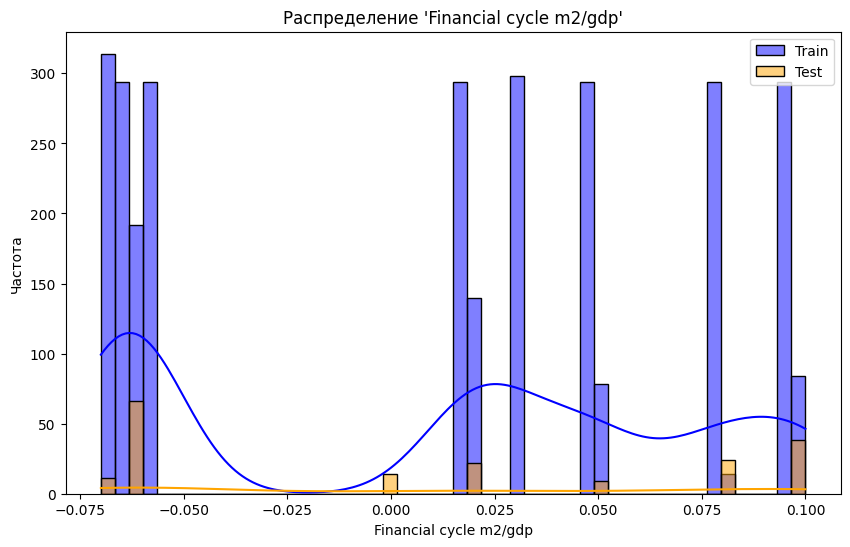


Описательная статистика для 'Financial cycle m2/gdp':
Обучающие данные:
count    2884.000000
mean        0.009073
std         0.061228
min        -0.070000
25%        -0.060000
50%         0.020000
75%         0.050000
max         0.100000
Name: Financial cycle m2/gdp, dtype: float64

Тестовые данные:
count    184.000000
mean       0.010217
std        0.067637
min       -0.070000
25%       -0.060000
50%        0.020000
75%        0.080000
max        0.100000
Name: Financial cycle m2/gdp, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ "FINANCIAL CYCLE M2/GDP" ==================
print("\nАнализ распределения признака 'Financial cycle m2/gdp'...")

# Гистограмма и KDE для обучающих данных
plt.figure(figsize=(10, 6))
sns.histplot(Xtrain_processed['Financial cycle m2/gdp'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(Xtest_processed['Financial cycle m2/gdp'], bins=50, kde=True, color='orange', label='Test')
plt.title("Распределение 'Financial cycle m2/gdp'")
plt.xlabel("Financial cycle m2/gdp")
plt.ylabel("Частота")
plt.legend()
plt.show()

# Описательная статистика
print("\nОписательная статистика для 'Financial cycle m2/gdp':")
print("Обучающие данные:")
print(Xtrain_processed['Financial cycle m2/gdp'].describe())
print("\nТестовые данные:")
print(Xtest_processed['Financial cycle m2/gdp'].describe())

In [ ]:
# ================== АНАЛИЗ УНИКАЛЬНЫХ ЗНАЧЕНИЙ "FINANCIAL CYCLE M2/GDP" ==================
print("\nАнализ уникальных значений 'Financial cycle m2/gdp'...")

# Уникальные значения в обучающих данных
unique_train = Xtrain_processed['Financial cycle m2/gdp'].unique()
print(f"Уникальные значения в обучающих данных ({len(unique_train)}): {sorted(unique_train)}")

# Уникальные значения в тестовых данных
unique_test = Xtest_processed['Financial cycle m2/gdp'].unique()
print(f"\nУникальные значения в тестовых данных ({len(unique_test)}): {sorted(unique_test)}")


Анализ уникальных значений 'Financial cycle m2/gdp'...
Уникальные значения в обучающих данных (15): [-0.07, -0.06737798, -0.064161221, -0.06, -0.059095742, 0.017310869, 0.02, 0.028940562, 0.03, 0.048155337, 0.05, 0.077211433, 0.08, 0.096386832, 0.1]

Уникальные значения в тестовых данных (7): [-0.07, -0.06, 0.0, 0.02, 0.05, 0.08, 0.1]


In [ ]:
# ================== АНАЛИЗ ЧАСТОТ ЗНАЧЕНИЙ "FINANCIAL CYCLE M2/GDP" ==================
print("\nАнализ частот значений 'Financial cycle m2/gdp'...")

# Подсчет частот значений
value_counts = Xtrain_processed['Financial cycle m2/gdp'].value_counts().sort_index()
print("Частоты значений:")
print(value_counts)


Анализ частот значений 'Financial cycle m2/gdp'...
Частоты значений:
Financial cycle m2/gdp
-0.070000     20
-0.067378    294
-0.064161    294
-0.060000    192
-0.059096    294
 0.017311    294
 0.020000    140
 0.028941    294
 0.030000      4
 0.048155    294
 0.050000     78
 0.077211    294
 0.080000     14
 0.096387    294
 0.100000     84
Name: count, dtype: int64


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ЗНАЧЕНИЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции значений 'Financial cycle m2/gdp' с целевой переменной...")

# Группировка данных по значениям признака и вычисление среднего значения целевой переменной
correlation_with_target = (
    Xtrain_processed
    .assign(IsDefault=ytrain_extended)  # Добавляем целевую переменную в DataFrame
    .groupby('Financial cycle m2/gdp')['IsDefault']
    .mean()
    .sort_index()
)

# Объединяем частоты и корреляцию с целевой переменной
analysis_df = pd.DataFrame({
    'Value': value_counts.index,
    'Count': value_counts.values,
    'Default Rate': correlation_with_target.values
}).sort_values(by='Default Rate', ascending=False)

print("Анализ значений 'Financial cycle m2/gdp':")
print(analysis_df)


Анализ корреляции значений 'Financial cycle m2/gdp' с целевой переменной...
Анализ значений 'Financial cycle m2/gdp':
       Value  Count  Default Rate
0  -0.070000     20           1.0
3  -0.060000    192           1.0
6   0.020000    140           1.0
8   0.030000      4           1.0
10  0.050000     78           1.0
12  0.080000     14           1.0
14  0.100000     84           1.0
1  -0.067378    294           0.0
2  -0.064161    294           0.0
4  -0.059096    294           0.0
5   0.017311    294           0.0
7   0.028941    294           0.0
9   0.048155    294           0.0
11  0.077211    294           0.0
13  0.096387    294           0.0


In [ ]:
# ================== КОРРЕЛЯЦИЯ МЕЖДУ ЗНАЧЕНИЯМИ ==================
print("\nКорреляция между значениями 'Financial cycle m2/gdp' и другими признаками...")

# Вычисляем корреляцию с другими признаками
correlation_matrix = Xtrain_processed.corr(numeric_only=True)
print(correlation_matrix['Financial cycle m2/gdp'])


Корреляция между значениями 'Financial cycle m2/gdp' и другими признаками...
Z-SCORE                                           0.080618
Share pledge ratio of controlling shareholders   -0.138218
Pledge ratio of limited sale shares              -0.173059
Pledge ratio of unlimited shares                 -0.409273
Stock Volatility                                  0.009812
                                                    ...   
Anomaly                                          -0.059646
Log_Current_ratio_clipped                         0.067125
Is_Clipped_Current_ratio                          0.044677
Log_Clipped_Ratio_prepayments                     0.030785
Is_Clipped_Ratio_prepayments                      0.051134
Name: Financial cycle m2/gdp, Length: 71, dtype: float64


In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ С "FINANCIAL CYCLE M2/GDP" ==================
print("\nАнализ корреляции между 'Financial cycle m2/gdp' и другими признаками...")

# Вычисляем корреляцию с другими признаками
correlation_matrix = Xtrain_processed.corr(numeric_only=True)

# Извлекаем корреляцию с "Financial cycle m2/gdp"
financial_cycle_correlation = correlation_matrix['Financial cycle m2/gdp']

# Сортируем по модулю корреляции (по убыванию)
top_10_correlations = financial_cycle_correlation.abs().sort_values(ascending=False).head(10)

# Выводим топ-10 корреляций
print("Топ-10 признаков с наибольшей корреляцией (по модулю):")
print(top_10_correlations)


Анализ корреляции между 'Financial cycle m2/gdp' и другими признаками...
Топ-10 признаков с наибольшей корреляцией (по модулю):
Financial cycle m2/gdp                                  1.000000
Pledge ratio of unlimited shares                        0.409273
Pledge ratio of limited sale shares                     0.173059
Share pledge ratio of controlling shareholders          0.138218
ROA                                                     0.130323
Company size (LN)                                       0.127221
Equity concentration (the first largest shareholder)    0.112974
ROE                                                     0.104601
Total institutional shareholding ratio                  0.102123
Asset liability ratio (excluding advance receipts)      0.101555
Name: Financial cycle m2/gdp, dtype: float64


In [ ]:
# ================== СРАВНЕНИЕ УНИКАЛЬНЫХ ЗНАЧЕНИЙ ==================
print("\nСравнение уникальных значений в обучающих и тестовых данных...")

# Уникальные значения в обучающих данных
unique_train = set(Xtrain_processed['Financial cycle m2/gdp'])
# Уникальные значения в тестовых данных
unique_test = set(Xtest_processed['Financial cycle m2/gdp'])

# Значения, которые встречаются только в обучающих данных
only_in_train = unique_train - unique_test
# Значения, которые встречаются только в тестовых данных
only_in_test = unique_test - unique_train

print(f"Значения, которые встречаются только в обучающих данных: {sorted(only_in_train)}")
print(f"Значения, которые встречаются только в тестовых данных: {sorted(only_in_test)}")


Сравнение уникальных значений в обучающих и тестовых данных...
Значения, которые встречаются только в обучающих данных: [-0.06737798, -0.064161221, -0.059095742, 0.017310869, 0.028940562, 0.03, 0.048155337, 0.077211433, 0.096386832]
Значения, которые встречаются только в тестовых данных: [0.0]


In [ ]:
safe_values = [
    -0.06737798, -0.064161221, -0.059095742, 0.017310869, 0.028940562,
    0.048155337, 0.077211433, 0.096386832
]

In [ ]:
# ================== СОЗДАНИЕ ФЛАГА НА ОСНОВЕ ПОЛНЫХ ЗНАЧЕНИЙ ==================
print("\nСоздание флага 'Is_Safe_Financial_Cycle' на основе полных значений...")

# Создаем флаг для обучающих данных
Xtrain_processed['Is_Safe_Financial_Cycle'] = Xtrain_processed['Financial cycle m2/gdp'].isin(safe_values).astype(int)

# Создаем флаг для тестовых данных
Xtest_processed['Is_Safe_Financial_Cycle'] = Xtest_processed['Financial cycle m2/gdp'].isin(safe_values).astype(int)

print("Флаг 'Is_Safe_Financial_Cycle' создан.")


Создание флага 'Is_Safe_Financial_Cycle' на основе полных значений...
Флаг 'Is_Safe_Financial_Cycle' создан.


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 74)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 74)
Размеры датасетов проверены.


In [ ]:
# ================== ПРОВЕРКА ЗНАЧЕНИЙ ФЛАГА ==================
print("\nПроверка значений флага 'Is_Safe_Financial_Cycle'...")

# Значения флага в обучающих данных
flag_train_values = Xtrain_processed['Is_Safe_Financial_Cycle'].value_counts()
print("Значения флага в обучающих данных:")
print(flag_train_values)

# Значения флага в тестовых данных
flag_test_values = Xtest_processed['Is_Safe_Financial_Cycle'].value_counts()
print("\nЗначения флага в тестовых данных:")
print(flag_test_values)


Проверка значений флага 'Is_Safe_Financial_Cycle'...
Значения флага в обучающих данных:
Is_Safe_Financial_Cycle
1    2352
0     532
Name: count, dtype: int64

Значения флага в тестовых данных:
Is_Safe_Financial_Cycle
0    184
Name: count, dtype: int64


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 74)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 74)
Размеры датасетов проверены.


In [ ]:
from sklearn.model_selection import train_test_split

# ================== ВРЕМЕННОЕ РАЗДЕЛЕНИЕ ДАННЫХ ==================
print("\nВременное разделение данных на обучающую и валидационную выборки...")

# Объединяем обучающие данные и метки (временно)
data_with_flag = Xtrain_processed.copy()
data_with_flag['Target'] = ytrain_extended

# Разделяем данные на обучающую и валидационную выборки
train_data, val_data = train_test_split(data_with_flag, test_size=0.2, random_state=42)

# Разделяем признаки и метки (временно)
Xtrain_temp = train_data.drop(columns=['Target'])
ytrain_temp = train_data['Target']

Xval = val_data.drop(columns=['Target'])
yval = val_data['Target']

print("Данные успешно разделены.")


Временное разделение данных на обучающую и валидационную выборки...
Данные успешно разделены.


In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 74)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 74)
Размеры датасетов проверены.


In [ ]:
from catboost import Pool, CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ CATBOOST ==================
print("\nОбучение модели CatBoost с новым флагом...")

# Создаем Pool для тренировочных данных
train_pool = Pool(data=Xtrain_processed, label=ytrain_extended, cat_features=categorical_features_str)

# Создаем Pool для валидационных данных
val_pool = Pool(data=Xval, label=yval, cat_features=categorical_features_str)

# Настройки модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,
    eval_metric="F1",
    auto_class_weights="Balanced"
)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Обучение модели CatBoost с новым флагом...
Learning rate set to 0.041165
0:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 10.4ms	remaining: 10.3s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 1.03s	remaining: 9.19s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 2.02s	remaining: 8.02s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.03s	remaining: 7.04s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.98s	remaining: 5.94s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 4.92s	remaining: 4.9s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 5.85s	remaining: 3.88s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.78s	remaining: 2.89s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 7.71s	remaining: 1.92s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 8.64s	remaining: 949ms
999:	learn: 1.0000000	test: 1.0000000	best: 1.00

In [ ]:
# ================== ГЕНЕРАЦИЯ ПРЕДСКАЗАНИЙ ДЛЯ ТЕСТОВЫХ ДАННЫХ ==================
print("\nГенерация предсказаний для тестового датасета...")

# Создаем Pool для тестовых данных
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_flag.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_flag.csv")


Генерация предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_flag.csv


In [ ]:
# ================== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nАнализ важности признаков...")

# Получаем важность признаков
feature_importance = model.get_feature_importance(prettified=True)
print("Важность признаков:")
print(feature_importance.head(20))


Анализ важности признаков...
Важность признаков:
                                        Feature Id  Importances
0                          Is_Safe_Financial_Cycle    98.367983
1     Minority shareholders' equity/owners' equity     0.780712
2                 Monetary capital/short-term debt     0.343646
3                            changes in net assets     0.325302
4                                     SG&A Expense     0.182356
5                                          Z-SCORE     0.000000
6   Share pledge ratio of controlling shareholders     0.000000
7              Pledge ratio of limited sale shares     0.000000
8                 Pledge ratio of unlimited shares     0.000000
9                                 Stock Volatility     0.000000
10                                       P/E ratio     0.000000
11                                       P/B ratio     0.000000
12      Stock price rise and fall in the last year     0.000000
13                            Annual turnover rate    

In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ==================
print("\nОписательная статистика для признака 'Pledge ratio of unlimited shares'...")

# Обучающие данные
pledge_ratio_train_stats = Xtrain_processed['Pledge ratio of unlimited shares'].describe()
print("Обучающие данные:")
print(pledge_ratio_train_stats)

# Тестовые данные
pledge_ratio_test_stats = Xtest_processed['Pledge ratio of unlimited shares'].describe()
print("\nТестовые данные:")
print(pledge_ratio_test_stats)


Описательная статистика для признака 'Pledge ratio of unlimited shares'...
Обучающие данные:
count    2884.000000
mean        0.108249
std         0.133774
min         0.000000
25%         0.000000
50%         0.054735
75%         0.186422
max         0.706297
Name: Pledge ratio of unlimited shares, dtype: float64

Тестовые данные:
count    184.000000
mean       0.115946
std        0.160547
min        0.000000
25%        0.000000
50%        0.000000
75%        0.225850
max        0.652700
Name: Pledge ratio of unlimited shares, dtype: float64


In [ ]:
# ================== КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nКорреляция признака 'Pledge ratio of unlimited shares' с целевой переменной...")

# Создаем DataFrame с признаком и целевой переменной
correlation_data = pd.DataFrame({
    'Pledge ratio of unlimited shares': Xtrain_processed['Pledge ratio of unlimited shares'],
    'IsDefault': ytrain_extended
})

# Вычисляем корреляцию
correlation = correlation_data.corr().iloc[0, 1]
print(f"Корреляция с целевой переменной: {correlation:.4f}")


Корреляция признака 'Pledge ratio of unlimited shares' с целевой переменной...
Корреляция с целевой переменной: 0.3265



Построение гистограмм для обучающих и тестовых данных...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


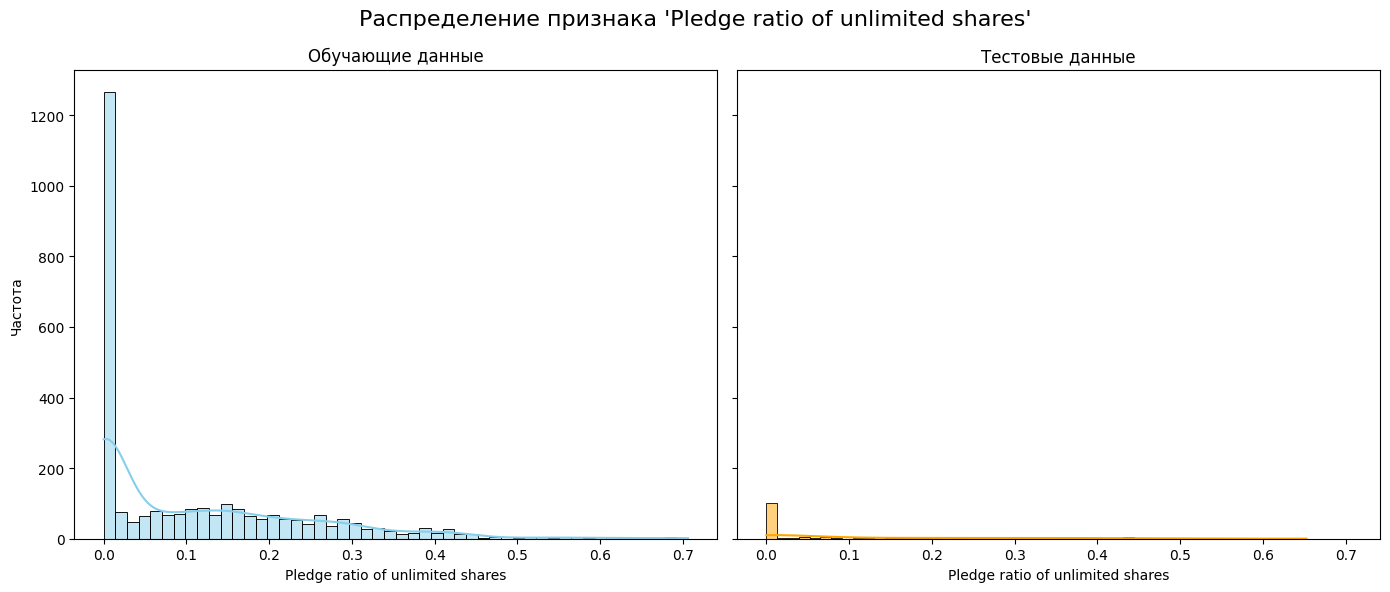

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ГИСТОГРАММА РАСПРЕДЕЛЕНИЯ ДЛЯ ОБУЧАЮЩИХ И ТЕСТОВЫХ ДАННЫХ ==================
print("\nПостроение гистограмм для обучающих и тестовых данных...")

# Создаем подграфики
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Гистограмма для обучающих данных
sns.histplot(Xtrain_processed['Pledge ratio of unlimited shares'], bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title("Обучающие данные")
axes[0].set_xlabel("Pledge ratio of unlimited shares")
axes[0].set_ylabel("Частота")

# Гистограмма для тестовых данных
sns.histplot(Xtest_processed['Pledge ratio of unlimited shares'], bins=50, kde=True, color='orange', ax=axes[1])
axes[1].set_title("Тестовые данные")
axes[1].set_xlabel("Pledge ratio of unlimited shares")
axes[1].set_ylabel("Частота")

# Общий заголовок
fig.suptitle("Распределение признака 'Pledge ratio of unlimited shares'", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ================== РАСЧЕТ ДОЛИ НУЛЕВЫХ ЗНАЧЕНИЙ ==================
print("\nРасчет доли нулевых значений для признака 'Pledge ratio of unlimited shares'...")

# Обучающие данные
zero_ratio_train = (Xtrain_processed['Pledge ratio of unlimited shares'] == 0).mean()
print(f"Доля нулевых значений в обучающих данных: {zero_ratio_train:.2%}")

# Тестовые данные
zero_ratio_test = (Xtest_processed['Pledge ratio of unlimited shares'] == 0).mean()
print(f"Доля нулевых значений в тестовых данных: {zero_ratio_test:.2%}")


Расчет доли нулевых значений для признака 'Pledge ratio of unlimited shares'...
Доля нулевых значений в обучающих данных: 40.22%
Доля нулевых значений в тестовых данных: 51.09%


In [ ]:
# ================== КОРРЕЛЯЦИЯ НУЛЕВЫХ ЗНАЧЕНИЙ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nПроверка корреляции нулевых значений с целевой переменной...")

# Создаем флаг для нулевых значений
Xtrain_processed['Is_Zero_Pledge_Ratio'] = (Xtrain_processed['Pledge ratio of unlimited shares'] == 0).astype(int)

# Создаем DataFrame для анализа
correlation_data = pd.DataFrame({
    'Is_Zero_Pledge_Ratio': Xtrain_processed['Is_Zero_Pledge_Ratio'],
    'IsDefault': ytrain_extended
})

# Вычисляем корреляцию
zero_correlation = correlation_data.corr().iloc[0, 1]
print(f"Корреляция между нулевыми значениями и целевой переменной: {zero_correlation:.4f}")


Проверка корреляции нулевых значений с целевой переменной...
Корреляция между нулевыми значениями и целевой переменной: -0.1458



Анализ распределения признака без нулевых значений...
Обучающие данные (без нулей):
count    1.724000e+03
mean     1.810853e-01
std      1.294076e-01
min      2.418820e-07
25%      8.295383e-02
50%      1.570444e-01
75%      2.599000e-01
max      7.062970e-01
Name: Pledge ratio of unlimited shares, dtype: float64

Тестовые данные (без нулей):
count    90.000000
mean      0.237044
std       0.154823
min       0.000100
25%       0.113150
50%       0.230800
75%       0.347550
max       0.652700
Name: Pledge ratio of unlimited shares, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


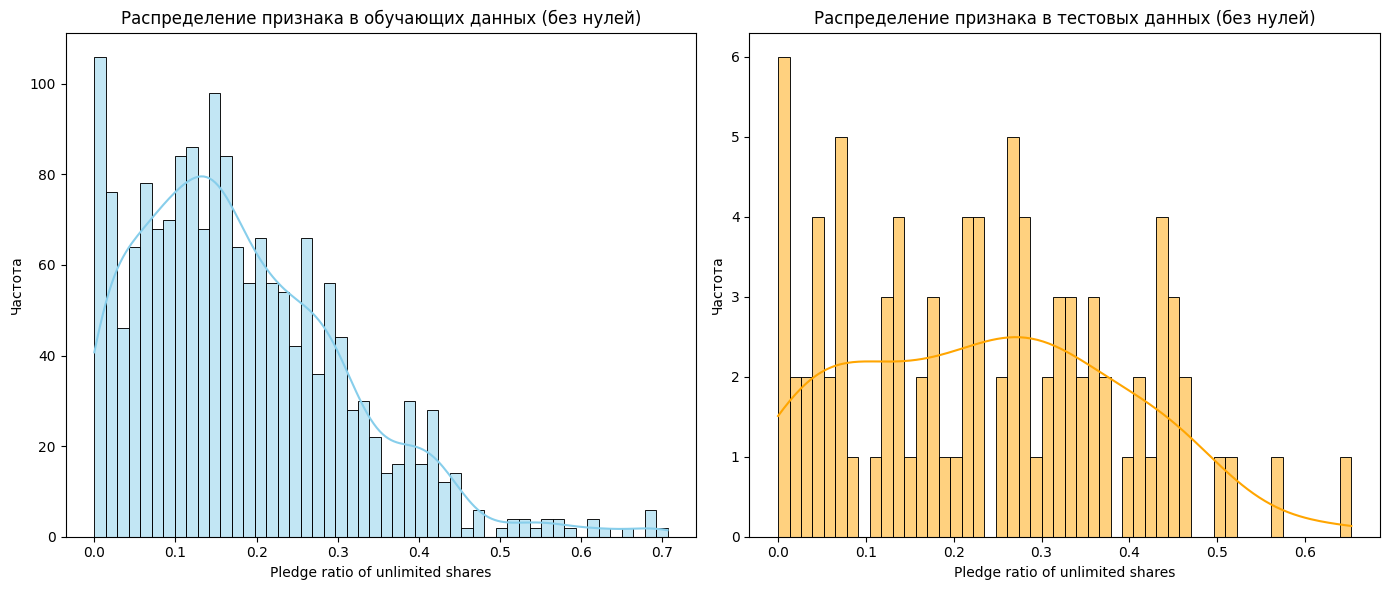

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ БЕЗ НУЛЕВЫХ ЗНАЧЕНИЙ ==================
print("\nАнализ распределения признака без нулевых значений...")

# Исключаем нулевые значения
non_zero_train = Xtrain_processed[Xtrain_processed['Pledge ratio of unlimited shares'] > 0]['Pledge ratio of unlimited shares']
non_zero_test = Xtest_processed[Xtest_processed['Pledge ratio of unlimited shares'] > 0]['Pledge ratio of unlimited shares']

# Описательная статистика
print("Обучающие данные (без нулей):")
print(non_zero_train.describe())

print("\nТестовые данные (без нулей):")
print(non_zero_test.describe())

# Гистограмма распределения
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(non_zero_train, bins=50, kde=True, color='skyblue')
plt.title("Распределение признака в обучающих данных (без нулей)")
plt.xlabel("Pledge ratio of unlimited shares")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(non_zero_test, bins=50, kde=True, color='orange')
plt.title("Распределение признака в тестовых данных (без нулей)")
plt.xlabel("Pledge ratio of unlimited shares")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# ================== ДОБАВЛЕНИЕ ФЛАГА ДЛЯ НУЛЕВЫХ ЗНАЧЕНИЙ ==================
print("\nДобавление флага 'Is_Zero_Pledge_Ratio' в тренировочные и тестовые данные...")

# Создаем флаг для нулевых значений
Xtrain_processed['Is_Zero_Pledge_Ratio'] = (Xtrain_processed['Pledge ratio of unlimited shares'] == 0).astype(int)
Xtest_processed['Is_Zero_Pledge_Ratio'] = (Xtest_processed['Pledge ratio of unlimited shares'] == 0).astype(int)

print("Флаг 'Is_Zero_Pledge_Ratio' успешно добавлен.")


Добавление флага 'Is_Zero_Pledge_Ratio' в тренировочные и тестовые данные...
Флаг 'Is_Zero_Pledge_Ratio' успешно добавлен.


In [ ]:
# ================== ПРОВЕРКА СОСТОЯНИЯ ДАННЫХ ==================
print("\nПроверка состояния данных...")

# Проверяем наличие нового флага
print("Флаг 'Is_Zero_Pledge_Ratio' в тренировочных данных:")
print("Есть" if 'Is_Zero_Pledge_Ratio' in Xtrain_processed.columns else "Нет")

print("Флаг 'Is_Zero_Pledge_Ratio' в тестовых данных:")
print("Есть" if 'Is_Zero_Pledge_Ratio' in Xtest_processed.columns else "Нет")

# Проверяем размеры данных
print(f"\nРазмер тренировочных данных: {Xtrain_processed.shape}")
print(f"Размер тестовых данных: {Xtest_processed.shape}")


Проверка состояния данных...
Флаг 'Is_Zero_Pledge_Ratio' в тренировочных данных:
Есть
Флаг 'Is_Zero_Pledge_Ratio' в тестовых данных:
Есть

Размер тренировочных данных: (2884, 75)
Размер тестовых данных: (184, 75)


In [ ]:
# ================== РАСЧЕТ 95-ГО ПРОЦЕНТИЛЯ ==================
print("\nРасчет 95-го процентиля для признака 'Pledge ratio of unlimited shares'...")

# Вычисляем 95-й процентиль
percentile_95 = Xtrain_processed['Pledge ratio of unlimited shares'].quantile(0.95)
print(f"95-й процентиль: {percentile_95:.4f}")

# ================== ДОБАВЛЕНИЕ ФЛАГА ДЛЯ ВЫСОКИХ ЗНАЧЕНИЙ ==================
print("\nДобавление флага 'Is_High_Pledge_Ratio' в тренировочные и тестовые данные...")

# Создаем флаг для высоких значений
Xtrain_processed['Is_High_Pledge_Ratio'] = (Xtrain_processed['Pledge ratio of unlimited shares'] > percentile_95).astype(int)
Xtest_processed['Is_High_Pledge_Ratio'] = (Xtest_processed['Pledge ratio of unlimited shares'] > percentile_95).astype(int)

print("Флаг 'Is_High_Pledge_Ratio' успешно добавлен.")


Расчет 95-го процентиля для признака 'Pledge ratio of unlimited shares'...
95-й процентиль: 0.3817

Добавление флага 'Is_High_Pledge_Ratio' в тренировочные и тестовые данные...
Флаг 'Is_High_Pledge_Ratio' успешно добавлен.


In [ ]:
# ================== ПРОВЕРКА СОСТОЯНИЯ ДАННЫХ ==================
print("\nПроверка состояния данных...")

# Проверяем наличие нового флага
print("Флаг 'Is_High_Pledge_Ratio' в тренировочных данных:")
print("Есть" if 'Is_High_Pledge_Ratio' in Xtrain_processed.columns else "Нет")

print("Флаг 'Is_High_Pledge_Ratio' в тестовых данных:")
print("Есть" if 'Is_High_Pledge_Ratio' in Xtest_processed.columns else "Нет")

# Проверяем размеры данных
print(f"\nРазмер тренировочных данных: {Xtrain_processed.shape}")
print(f"Размер тестовых данных: {Xtest_processed.shape}")


Проверка состояния данных...
Флаг 'Is_High_Pledge_Ratio' в тренировочных данных:
Есть
Флаг 'Is_High_Pledge_Ratio' в тестовых данных:
Есть

Размер тренировочных данных: (2884, 76)
Размер тестовых данных: (184, 76)


In [ ]:
# ================== ИСПРАВЛЕНИЕ СПИСКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nИсправление списка категориальных признаков...")

# Исходный список категориальных признаков
categorical_features_str = ['audit opinion ', 'Number of key audit matters', 'Anomaly', 'Is_Clipped_Current_ratio', 'Is_Clipped_Ratio_prepayments']

# Удаляем бинарные признаки
binary_features = ['Anomaly', 'Is_Clipped_Current_ratio', 'Is_Clipped_Ratio_prepayments']
categorical_features_str = [feature for feature in categorical_features_str if feature not in binary_features]

print("Обновленный список категориальных признаков:")
print(categorical_features_str)


Исправление списка категориальных признаков...
Обновленный список категориальных признаков:
['audit opinion ', 'Number of key audit matters']


In [ ]:
from catboost import Pool, cv

# ================== ПОДГОТОВКА ДАННЫХ ДЛЯ КРОСС-ВАЛИДАЦИИ ==================
print("\nПодготовка данных для кросс-валидации...")

# Создаем Pool для данных
data_pool = Pool(data=Xtrain_processed, label=ytrain_extended, cat_features=categorical_features_str)

# Параметры модели с регуляризацией
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 42,
    'verbose': False,
    'l2_leaf_reg': 15,  # Увеличиваем L2-регуляризацию
    'rsm': 0.8,        # Используем 80% признаков для каждого дерева
    'learning_rate': 0.03  # Уменьшаем скорость обучения
}

# Кросс-валидация
print("\nЗапуск кросс-валидации...")
cv_results = cv(
    pool=data_pool,
    params=params,
    fold_count=5,  # Количество фолдов
    shuffle=True,
    partition_random_seed=42,
    stratified=True,  # Стратификация для баланса классов
    plot=False  # Отключаем виджеты
)

# Компактификация вывода
print("\nРезультаты кросс-валидации:")
# Оставляем только последнюю строку с финальными метриками
final_metrics = cv_results[['test-F1-mean', 'test-F1-std',
                            'train-F1-mean', 'train-F1-std',
                            'test-Logloss-mean', 'test-Logloss-std',
                            'train-Logloss-mean', 'train-Logloss-std']].iloc[-1]

# Форматируем вывод с повышенной точностью (8 знаков после запятой)
print(f"Тестовая F1-метрика: {final_metrics['test-F1-mean']:.8f} ± {final_metrics['test-F1-std']:.8f}")
print(f"Тренировочная F1-метрика: {final_metrics['train-F1-mean']:.8f} ± {final_metrics['train-F1-std']:.8f}")
print(f"Тестовый Logloss: {final_metrics['test-Logloss-mean']:.8f} ± {final_metrics['test-Logloss-std']:.8f}")
print(f"Тренировочный Logloss: {final_metrics['train-Logloss-mean']:.8f} ± {final_metrics['train-Logloss-std']:.8f}")

# Добавляем сводку
if final_metrics['train-F1-mean'] > 0.999999 and final_metrics['test-F1-mean'] < 0.8:
    print("\nВНИМАНИЕ: Возможное переобучение модели!")
else:
    print("\nМодель показывает стабильные результаты.")


Подготовка данных для кросс-валидации...

Запуск кросс-валидации...
Training on fold [0/5]

bestTest = 1
bestIteration = 0

Training on fold [1/5]

bestTest = 1
bestIteration = 0

Training on fold [2/5]

bestTest = 1
bestIteration = 0

Training on fold [3/5]

bestTest = 1
bestIteration = 1

Training on fold [4/5]

bestTest = 1
bestIteration = 0


Результаты кросс-валидации:
Тестовая F1-метрика: 1.00000000 ± 0.00000000
Тренировочная F1-метрика: 1.00000000 ± 0.00000000
Тестовый Logloss: 0.00090969 ± 0.00005400
Тренировочный Logloss: 0.00087436 ± 0.00002011

Модель показывает стабильные результаты.


In [ ]:
from catboost import Pool, cv

# ================== УДАЛЕНИЕ ФЛАГА Is_Safe_Financial_Cycle ==================
print("\nУдаление флага 'Is_Safe_Financial_Cycle' из данных...")

# Удаляем флаг
Xtrain_processed_no_flag = Xtrain_processed.drop(columns=['Is_Safe_Financial_Cycle'], errors='ignore')

print("Флаг удален.")

# ================== ПОДГОТОВКА ДАННЫХ ДЛЯ КРОСС-ВАЛИДАЦИИ ==================
print("\nПодготовка данных для кросс-валидации...")

# Создаем Pool для данных
data_pool = Pool(data=Xtrain_processed_no_flag, label=ytrain_extended, cat_features=categorical_features_str)

# Параметры модели с регуляризацией
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 42,
    'verbose': False,
    'l2_leaf_reg': 15,  # Увеличиваем L2-регуляризацию
    'rsm': 0.8,        # Используем 80% признаков для каждого дерева
    'learning_rate': 0.03  # Уменьшаем скорость обучения
}

# Кросс-валидация
print("\nЗапуск кросс-валидации...")
cv_results = cv(
    pool=data_pool,
    params=params,
    fold_count=5,  # Количество фолдов
    shuffle=True,
    partition_random_seed=42,
    stratified=True,  # Стратификация для баланса классов
    plot=False  # Отключаем виджеты
)

# Компактификация вывода
print("\nРезультаты кросс-валидации:")
# Оставляем только последнюю строку с финальными метриками
final_metrics = cv_results[['test-F1-mean', 'test-F1-std',
                            'train-F1-mean', 'train-F1-std',
                            'test-Logloss-mean', 'test-Logloss-std',
                            'train-Logloss-mean', 'train-Logloss-std']].iloc[-1]

# Форматируем вывод с повышенной точностью (8 знаков после запятой)
print(f"Тестовая F1-метрика: {final_metrics['test-F1-mean']:.8f} ± {final_metrics['test-F1-std']:.8f}")
print(f"Тренировочная F1-метрика: {final_metrics['train-F1-mean']:.8f} ± {final_metrics['train-F1-std']:.8f}")
print(f"Тестовый Logloss: {final_metrics['test-Logloss-mean']:.8f} ± {final_metrics['test-Logloss-std']:.8f}")
print(f"Тренировочный Logloss: {final_metrics['train-Logloss-mean']:.8f} ± {final_metrics['train-Logloss-std']:.8f}")

# Добавляем сводку
if final_metrics['train-F1-mean'] > 0.999999 and final_metrics['test-F1-mean'] < 0.8:
    print("\nВНИМАНИЕ: Возможное переобучение модели!")
else:
    print("\nМодель показывает стабильные результаты.")


Удаление флага 'Is_Safe_Financial_Cycle' из данных...
Флаг удален.

Подготовка данных для кросс-валидации...

Запуск кросс-валидации...
Training on fold [0/5]

bestTest = 0.9978928267
bestIteration = 420

Training on fold [1/5]

bestTest = 1
bestIteration = 394

Training on fold [2/5]

bestTest = 1
bestIteration = 291

Training on fold [3/5]

bestTest = 1
bestIteration = 168

Training on fold [4/5]

bestTest = 0.9883494165
bestIteration = 271


Результаты кросс-валидации:
Тестовая F1-метрика: 0.99724845 ± 0.00505769
Тренировочная F1-метрика: 1.00000000 ± 0.00000000
Тестовый Logloss: 0.01373609 ± 0.00570434
Тренировочный Logloss: 0.00563599 ± 0.00153772

Модель показывает стабильные результаты.


In [ ]:
# Создаем веса объектов
sample_weights = Xtrain_processed['Is_Safe_Financial_Cycle'].map({1: 0.5, 0: 1.0})  # Искусственные значения имеют меньший вес

# Создаем Pool с весами
train_pool = Pool(data=Xtrain_processed.drop(columns=['Is_Safe_Financial_Cycle']),
                  label=ytrain_extended,
                  cat_features=categorical_features_str,
                  weight=sample_weights)

# Обучение модели
model.fit(train_pool)

print("Модель обучена с использованием весов.")

Learning rate set to 0.016194
0:	learn: 0.9295067	total: 10.9ms	remaining: 10.9s
100:	learn: 0.9921997	total: 1.04s	remaining: 9.31s
200:	learn: 1.0000000	total: 2.13s	remaining: 8.47s
300:	learn: 1.0000000	total: 3.18s	remaining: 7.39s
400:	learn: 1.0000000	total: 4.21s	remaining: 6.3s
500:	learn: 1.0000000	total: 5.24s	remaining: 5.22s
600:	learn: 1.0000000	total: 6.26s	remaining: 4.16s
700:	learn: 1.0000000	total: 7.28s	remaining: 3.1s
800:	learn: 1.0000000	total: 8.26s	remaining: 2.05s
900:	learn: 1.0000000	total: 9.23s	remaining: 1.01s
999:	learn: 1.0000000	total: 10.2s	remaining: 0us
Модель обучена с использованием весов.


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

# ================== ВРЕМЕННОЕ РАЗДЕЛЕНИЕ ДАННЫХ ==================
print("\nВременное разделение данных на обучающую и валидационную выборки...")

# Объединяем обучающие данные и метки (временно)
data_with_flag = Xtrain_processed.copy()
data_with_flag['Target'] = ytrain_extended

# Разделяем данные на обучающую и валидационную выборки
train_data, val_data = train_test_split(data_with_flag, test_size=0.2, random_state=42)

# Разделяем признаки и метки (временно)
Xtrain_temp = train_data.drop(columns=['Target'])
ytrain_temp = train_data['Target']

Xval = val_data.drop(columns=['Target'])
yval = val_data['Target']

print("Данные успешно разделены.")

# ================== ОБУЧЕНИЕ МОДЕЛИ CATBOOST ==================
print("\nОбучение модели CatBoost...")

# Создаем Pool для тренировочных данных
train_pool = Pool(data=Xtrain_temp, label=ytrain_temp, cat_features=categorical_features_str)

# Создаем Pool для валидационных данных
val_pool = Pool(data=Xval, label=yval, cat_features=categorical_features_str)

# Настройки модели
model = CatBoostClassifier(
    random_state=42,
    verbose=100,  # Вывод логов каждые 100 итераций
    eval_metric="F1",
    auto_class_weights="Balanced"
)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

print("Модель обучена.")


Временное разделение данных на обучающую и валидационную выборки...
Данные успешно разделены.

Обучение модели CatBoost...
Learning rate set to 0.038957
0:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 10.3ms	remaining: 10.2s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 1.02s	remaining: 9.11s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 1.99s	remaining: 7.91s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 2.93s	remaining: 6.8s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.84s	remaining: 5.74s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 4.75s	remaining: 4.73s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 5.65s	remaining: 3.75s
700:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.55s	remaining: 2.79s
800:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 7.51s	remaining: 1.87s
900:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0

In [ ]:
# ================== АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ==================
print("\nАнализ важности признаков...")

# Получаем важность признаков
feature_importance = model.get_feature_importance(prettified=True)

# Выводим топ-20 важных признаков
print("\nТоп-20 важных признаков:")
print(feature_importance.head(40))


Анализ важности признаков...

Топ-20 важных признаков:
                                           Feature Id  Importances
0                             Is_Safe_Financial_Cycle    94.632197
1        Minority shareholders' equity/owners' equity     2.085684
2   Ratio of construction in progress to total assets     1.780858
3                     Inventory turnover rate (Times)     1.006546
4                                             Tobin Q     0.264483
5              Total institutional shareholding ratio     0.230232
6                                             Z-SCORE     0.000000
7      Share pledge ratio of controlling shareholders     0.000000
8                 Pledge ratio of limited sale shares     0.000000
9                    Pledge ratio of unlimited shares     0.000000
10                                   Stock Volatility     0.000000
11                                          P/E ratio     0.000000
12                                          P/B ratio     0.000000
13    

In [ ]:
# ================== ПРОВЕРКА РАЗМЕРОВ ДАТАСЕТОВ ==================
print("\nПроверка размеров датасетов...")

# Размеры тренировочного датасета
print(f"Размер Xtrain_processed: {Xtrain_processed.shape}")
print(f"Размер ytrain_extended: {len(ytrain_extended)}")

# Размеры тестового датасета
print(f"Размер Xtest_processed: {Xtest_processed.shape}")

# Проверка совпадения размеров данных и меток
assert Xtrain_processed.shape[0] == len(ytrain_extended), "Размеры данных и меток не совпадают!"
print("Размеры датасетов проверены.")


Проверка размеров датасетов...
Размер Xtrain_processed: (2884, 76)
Размер ytrain_extended: 2884
Размер Xtest_processed: (184, 76)
Размеры датасетов проверены.


In [ ]:
from catboost import Pool

# ================== СОЗДАНИЕ ВЕСОВ ==================
print("\nСоздание весов объектов...")

# Создаем веса для флага Is_Safe_Financial_Cycle
if 'Is_Safe_Financial_Cycle' in Xtrain_processed.columns:
    sample_weights = Xtrain_processed['Is_Safe_Financial_Cycle'].map({1: 0.5, 0: 1.0})  # Искусственные значения имеют меньший вес
    Xtrain_processed_no_flag = Xtrain_processed.drop(columns=['Is_Safe_Financial_Cycle'])  # Удаляем флаг из данных
else:
    sample_weights = None
    Xtrain_processed_no_flag = Xtrain_processed

print("Веса созданы.")

# ================== СОЗДАНИЕ POOL ==================
print("\nСоздание Pool для обучения модели...")

# Создаем Pool с данными и весами
train_pool = Pool(
    data=Xtrain_processed_no_flag,
    label=ytrain_extended,
    cat_features=categorical_features_str,
    weight=sample_weights
)

print("Pool создан.")


Создание весов объектов...
Веса созданы.

Создание Pool для обучения модели...
Pool создан.


In [ ]:
from catboost import CatBoostClassifier

# ================== ОБУЧЕНИЕ МОДЕЛИ НА ВСЕХ ДАННЫХ С ВЕСАМИ ==================
print("\nОбучение модели на всех данных с использованием весов...")

# Настройки модели
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',
    random_state=42,
    verbose=100,  # Вывод логов каждые 100 итераций
    l2_leaf_reg=15,  # Увеличиваем L2-регуляризацию
    rsm=0.8,        # Используем 80% признаков для каждого дерева
    learning_rate=0.03  # Уменьшаем скорость обучения
)

# Обучение модели
model.fit(train_pool)

print("Модель обучена на всех данных с использованием весов.")


Обучение модели на всех данных с использованием весов...
0:	learn: 0.9014689	total: 10.2ms	remaining: 10.2s
100:	learn: 0.9938831	total: 1.14s	remaining: 10.1s
200:	learn: 1.0000000	total: 2.21s	remaining: 8.77s
300:	learn: 1.0000000	total: 3.26s	remaining: 7.58s
400:	learn: 1.0000000	total: 4.34s	remaining: 6.48s
500:	learn: 1.0000000	total: 5.39s	remaining: 5.37s
600:	learn: 1.0000000	total: 6.47s	remaining: 4.29s
700:	learn: 1.0000000	total: 7.53s	remaining: 3.21s
800:	learn: 1.0000000	total: 8.57s	remaining: 2.13s
900:	learn: 1.0000000	total: 9.63s	remaining: 1.06s
999:	learn: 1.0000000	total: 10.6s	remaining: 0us
Модель обучена на всех данных с использованием весов.


In [ ]:
# ================== ГЕНЕРАЦИЯ ПРЕДСКАЗАНИЙ ДЛЯ ТЕСТОВЫХ ДАННЫХ ==================
print("\nГенерация предсказаний для тестового датасета...")

# Создаем Pool для тестовых данных
test_pool = Pool(data=Xtest_processed, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions         # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_final.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_final.csv")


Генерация предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_final.csv


In [ ]:
# ================== УДАЛЕНИЕ ФЛАГА Is_Zero_Pledge_Ratio ==================
print("\nУдаление флага 'Is_Zero_Pledge_Ratio' из данных...")

# Удаляем флаг
if 'Is_Zero_Pledge_Ratio' in Xtrain_processed.columns:
    Xtrain_processed_no_flags = Xtrain_processed.drop(columns=['Is_Zero_Pledge_Ratio'])
else:
    Xtrain_processed_no_flags = Xtrain_processed

print("Флаг 'Is_Zero_Pledge_Ratio' удален.")


Удаление флага 'Is_Zero_Pledge_Ratio' из данных...
Флаг 'Is_Zero_Pledge_Ratio' удален.


In [ ]:
from catboost import Pool, CatBoostClassifier

# ================== СОЗДАНИЕ ВЕСОВ ==================
print("\nСоздание весов объектов...")

# Создаем веса для флага Is_Safe_Financial_Cycle
if 'Is_Safe_Financial_Cycle' in Xtrain_processed_no_flags.columns:
    sample_weights = Xtrain_processed_no_flags['Is_Safe_Financial_Cycle'].map({1: 0.5, 0: 1.0})  # Искусственные значения имеют меньший вес
    Xtrain_processed_final = Xtrain_processed_no_flags.drop(columns=['Is_Safe_Financial_Cycle'])  # Удаляем флаг из данных
else:
    sample_weights = None
    Xtrain_processed_final = Xtrain_processed_no_flags

print("Веса созданы.")

# ================== СОЗДАНИЕ POOL ==================
print("\nСоздание Pool для обучения модели...")

# Создаем Pool с данными и весами
train_pool = Pool(
    data=Xtrain_processed_final,
    label=ytrain_extended,
    cat_features=categorical_features_str,
    weight=sample_weights
)

print("Pool создан.")

# ================== ОБУЧЕНИЕ МОДЕЛИ НА ВСЕХ ДАННЫХ С ВЕСАМИ ==================
print("\nОбучение модели на всех данных с использованием весов...")

# Настройки модели
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',
    random_state=42,
    verbose=100,  # Вывод логов каждые 100 итераций
    l2_leaf_reg=15,  # Увеличиваем L2-регуляризацию
    rsm=0.8,        # Используем 80% признаков для каждого дерева
    learning_rate=0.03  # Уменьшаем скорость обучения
)

# Обучение модели
model.fit(train_pool)

print("Модель обучена на всех данных с использованием весов.")


Создание весов объектов...
Веса созданы.

Создание Pool для обучения модели...
Pool создан.

Обучение модели на всех данных с использованием весов...
0:	learn: 0.8493501	total: 10.1ms	remaining: 10.1s
100:	learn: 0.9961881	total: 1.14s	remaining: 10.1s
200:	learn: 0.9995750	total: 2.21s	remaining: 8.81s
300:	learn: 1.0000000	total: 3.26s	remaining: 7.56s
400:	learn: 1.0000000	total: 4.32s	remaining: 6.46s
500:	learn: 1.0000000	total: 5.37s	remaining: 5.35s
600:	learn: 1.0000000	total: 6.43s	remaining: 4.27s
700:	learn: 1.0000000	total: 7.5s	remaining: 3.2s
800:	learn: 1.0000000	total: 8.56s	remaining: 2.13s
900:	learn: 1.0000000	total: 9.61s	remaining: 1.05s
999:	learn: 1.0000000	total: 10.7s	remaining: 0us
Модель обучена на всех данных с использованием весов.


In [ ]:
# ================== ГЕНЕРАЦИЯ ПРЕДСКАЗАНИЙ ДЛЯ ТЕСТОВЫХ ДАННЫХ ==================
print("\nГенерация предсказаний для тестового датасета...")

# Удаляем флаг Is_Zero_Pledge_Ratio из тестовых данных (если он есть)
if 'Is_Zero_Pledge_Ratio' in Xtest_processed.columns:
    Xtest_processed_final = Xtest_processed.drop(columns=['Is_Zero_Pledge_Ratio'])
else:
    Xtest_processed_final = Xtest_processed

# Создаем Pool для тестовых данных
test_pool = Pool(data=Xtest_processed_final, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = model.predict(test_pool)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_processed_final.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions               # Используем правильное имя столбца
})
submission.to_csv("/kaggle/working/submission_catboost_no_zero_flag.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_no_zero_flag.csv")


Генерация предсказаний для тестового датасета...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_no_zero_flag.csv


In [ ]:
# ================== ШАГ 2: ОПИСАТЕЛЬНАЯ СТАТИСТИКА ==================
print("\nШаг 2: Описательная статистика для Z-SCORE...")

# Тренировочные данные
print("\nОписательная статистика для Z-SCORE (тренировочные данные):")
print(Xtrain_processed_final['Z-SCORE'].describe())

# Тестовые данные
print("\nОписательная статистика для Z-SCORE (тестовые данные):")
print(Xtest_processed_final['Z-SCORE'].describe())


Шаг 2: Описательная статистика для Z-SCORE...

Описательная статистика для Z-SCORE (тренировочные данные):
count    2884.000000
mean        6.387528
std        13.055870
min       -35.719400
25%         1.945142
50%         3.375252
75%         6.509353
max       350.622700
Name: Z-SCORE, dtype: float64

Описательная статистика для Z-SCORE (тестовые данные):
count    184.000000
mean       6.351546
std       11.365770
min       -2.731800
25%        1.699875
50%        3.330350
75%        6.451925
max      119.721400
Name: Z-SCORE, dtype: float64



Шаг 3: Построение гистограмм для Z-SCORE...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


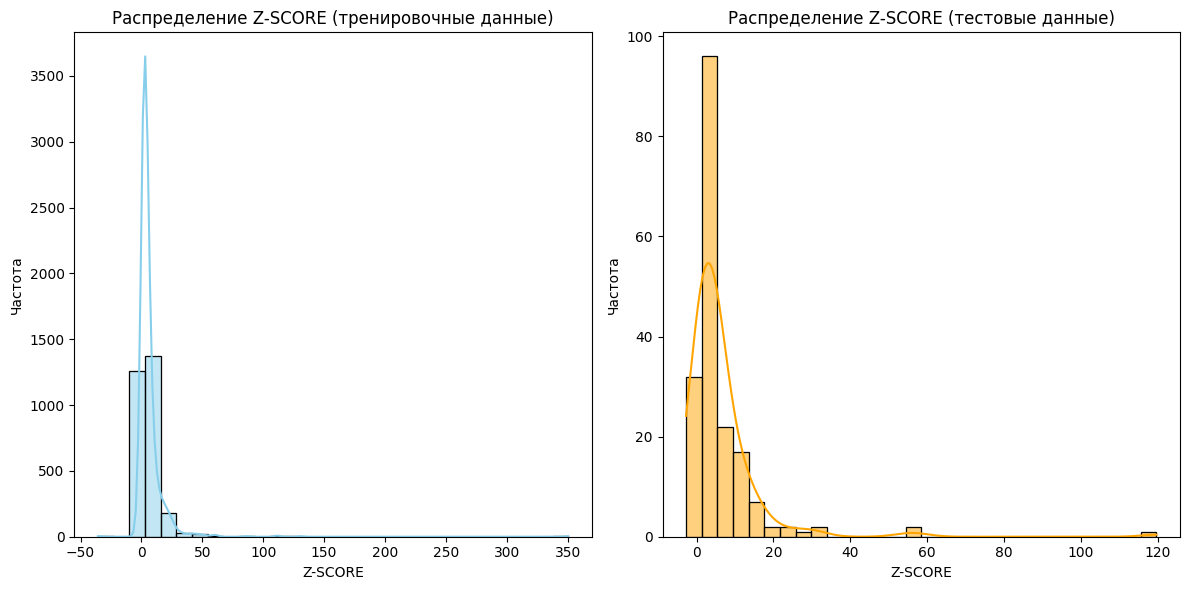

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ШАГ 3: ГРАФИКИ РАСПРЕДЕЛЕНИЯ (ГИСТОГРАММЫ) ==================
print("\nШаг 3: Построение гистограмм для Z-SCORE...")

plt.figure(figsize=(12, 6))

# Тренировочные данные
plt.subplot(1, 2, 1)
sns.histplot(Xtrain_processed_final['Z-SCORE'], kde=True, bins=30, color='skyblue')
plt.title("Распределение Z-SCORE (тренировочные данные)")
plt.xlabel("Z-SCORE")
plt.ylabel("Частота")

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(Xtest_processed_final['Z-SCORE'], kde=True, bins=30, color='orange')
plt.title("Распределение Z-SCORE (тестовые данные)")
plt.xlabel("Z-SCORE")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# Проверка выбросов в тренировочных данных
outliers_train = Xtrain_processed_final[Xtrain_processed_final['Z-SCORE'] > 100]
print(f"Количество выбросов в тренировочных данных (Z-SCORE > 100): {len(outliers_train)}")

# Проверка выбросов в тестовых данных
outliers_test = Xtest_processed_final[Xtest_processed_final['Z-SCORE'] > 100]
print(f"Количество выбросов в тестовых данных (Z-SCORE > 100): {len(outliers_test)}")

Количество выбросов в тренировочных данных (Z-SCORE > 100): 8
Количество выбросов в тестовых данных (Z-SCORE > 100): 1


In [ ]:
# Проверка отрицательных значений в тренировочных данных
negative_train = Xtrain_processed_final[Xtrain_processed_final['Z-SCORE'] < 0]
print(f"Количество объектов с отрицательным Z-SCORE в тренировочных данных: {len(negative_train)}")

# Проверка отрицательных значений в тестовых данных
negative_test = Xtest_processed_final[Xtest_processed_final['Z-SCORE'] < 0]
print(f"Количество объектов с отрицательным Z-SCORE в тестовых данных: {len(negative_test)}")

Количество объектов с отрицательным Z-SCORE в тренировочных данных: 54
Количество объектов с отрицательным Z-SCORE в тестовых данных: 3


In [ ]:
# ================== ВЫЧИСЛЕНИЕ 5-ГО И 95-ГО ПЕРЦЕНТИЛЕЙ ==================
print("\nВычисление 5-го и 95-го процентилей для Z-SCORE...")

# Тренировочные данные
p5_train = Xtrain_processed_final['Z-SCORE'].quantile(0.05)
p95_train = Xtrain_processed_final['Z-SCORE'].quantile(0.95)
print(f"Тренировочные данные: 5-й процентиль = {p5_train:.4f}, 95-й процентиль = {p95_train:.4f}")


Вычисление 5-го и 95-го процентилей для Z-SCORE...
Тренировочные данные: 5-й процентиль = 0.6290, 95-й процентиль = 21.4524


In [ ]:
# ================== СОЗДАНИЕ ВРЕМЕННЫХ ПЕРЕМЕННЫХ ДЛЯ ОБРЕЗАННЫХ ЗНАЧЕНИЙ ==================
print("\nСоздание временных переменных для обрезанных значений Z-SCORE...")

# Обрезка тренировочных данных (временная переменная)
Z_SCORE_Clipped_Train = Xtrain_processed_final['Z-SCORE'].clip(lower=p5_train, upper=p95_train)

# Обрезка тестовых данных (временная переменная)
Z_SCORE_Clipped_Test = Xtest_processed_final['Z-SCORE'].clip(lower=p5_train, upper=p95_train)

print("Временные переменные для обрезанных значений Z-SCORE созданы.")


Создание временных переменных для обрезанных значений Z-SCORE...
Временные переменные для обрезанных значений Z-SCORE созданы.



Построение графиков распределения обрезанного Z-SCORE...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


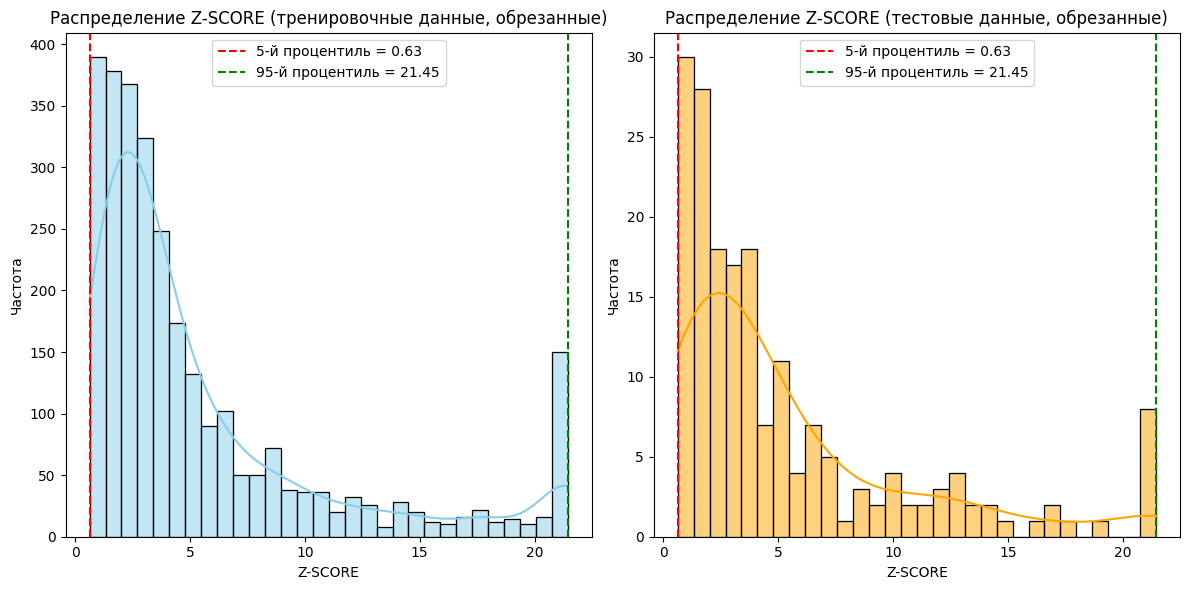

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ГРАФИКИ РАСПРЕДЕЛЕНИЯ ==================
print("\nПостроение графиков распределения обрезанного Z-SCORE...")

plt.figure(figsize=(12, 6))

# Тренировочные данные
plt.subplot(1, 2, 1)
sns.histplot(Z_SCORE_Clipped_Train, kde=True, bins=30, color='skyblue')
plt.title("Распределение Z-SCORE (тренировочные данные, обрезанные)")
plt.xlabel("Z-SCORE")
plt.ylabel("Частота")
plt.axvline(p5_train, color='red', linestyle='--', label=f'5-й процентиль = {p5_train:.2f}')
plt.axvline(p95_train, color='green', linestyle='--', label=f'95-й процентиль = {p95_train:.2f}')
plt.legend()

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(Z_SCORE_Clipped_Test, kde=True, bins=30, color='orange')
plt.title("Распределение Z-SCORE (тестовые данные, обрезанные)")
plt.xlabel("Z-SCORE")
plt.ylabel("Частота")
plt.axvline(p5_train, color='red', linestyle='--', label=f'5-й процентиль = {p5_train:.2f}')
plt.axvline(p95_train, color='green', linestyle='--', label=f'95-й процентиль = {p95_train:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ДЛЯ ОБРЕЗАННЫХ ЗНАЧЕНИЙ Z-SCORE ==================
print("\nОписательная статистика для обрезанных значений Z-SCORE...")

# Тренировочные данные
print("\nОписательная статистика для тренировочных данных (обрезанные значения):")
print(Z_SCORE_Clipped_Train.describe())

# Тестовые данные
print("\nОписательная статистика для тестовых данных (обрезанные значения):")
print(Z_SCORE_Clipped_Test.describe())


Описательная статистика для обрезанных значений Z-SCORE...

Описательная статистика для тренировочных данных (обрезанные значения):
count    2884.000000
mean        5.486013
std         5.523474
min         0.629026
25%         1.945142
50%         3.375252
75%         6.509353
max        21.452399
Name: Z-SCORE, dtype: float64

Описательная статистика для тестовых данных (обрезанные значения):
count    184.000000
mean       5.321377
std        5.309590
min        0.629026
25%        1.699875
50%        3.330350
75%        6.451925
max       21.452399
Name: Z-SCORE, dtype: float64


In [ ]:
# ================== ВЫЧИСЛЕНИЕ 5-ГО И 95-ГО ПЕРЦЕНТИЛЕЙ ==================
print("\nВычисление 5-го и 95-го процентилей для Z-SCORE...")

# Тренировочные данные
p5_train = Xtrain_processed_final['Z-SCORE'].quantile(0.05)
p95_train = Xtrain_processed_final['Z-SCORE'].quantile(0.95)
print(f"Тренировочные данные: 5-й процентиль = {p5_train:.4f}, 95-й процентиль = {p95_train:.4f}")

# ================== СОЗДАНИЕ БИНАРНЫХ ФЛАГОВ ==================
print("\nСоздание бинарных флагов для 5-го и 95-го процентилей...")

# Тренировочные данные
Xtrain_processed_final['Is_Low_Z_SCORE'] = (Xtrain_processed_final['Z-SCORE'] < p5_train).astype(int)
Xtrain_processed_final['Is_High_Z_SCORE'] = (Xtrain_processed_final['Z-SCORE'] > p95_train).astype(int)

# Тестовые данные
Xtest_processed_final['Is_Low_Z_SCORE'] = (Xtest_processed_final['Z-SCORE'] < p5_train).astype(int)
Xtest_processed_final['Is_High_Z_SCORE'] = (Xtest_processed_final['Z-SCORE'] > p95_train).astype(int)

print("Бинарные флаги для 5-го и 95-го процентилей созданы.")


Вычисление 5-го и 95-го процентилей для Z-SCORE...
Тренировочные данные: 5-й процентиль = 0.6290, 95-й процентиль = 21.4524

Создание бинарных флагов для 5-го и 95-го процентилей...
Бинарные флаги для 5-го и 95-го процентилей созданы.


In [ ]:
# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ ФЛАГОВ ==================
print("\nАнализ распределения бинарных флагов...")

# Тренировочные данные
print("\nРаспределение флагов в тренировочных данных:")
print(Xtrain_processed_final[['Is_Low_Z_SCORE', 'Is_High_Z_SCORE']].sum())

# Тестовые данные
print("\nРаспределение флагов в тестовых данных:")
print(Xtest_processed_final[['Is_Low_Z_SCORE', 'Is_High_Z_SCORE']].sum())


Анализ распределения бинарных флагов...

Распределение флагов в тренировочных данных:
Is_Low_Z_SCORE     144
Is_High_Z_SCORE    144
dtype: int64

Распределение флагов в тестовых данных:
Is_Low_Z_SCORE     11
Is_High_Z_SCORE     8
dtype: int64


In [ ]:
# ================== КОРРЕЛЯЦИЯ ФЛАГОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nКорреляция флагов с целевой переменной...")

# Создаем временный DataFrame
temp_df = Xtrain_processed_final[['Is_Low_Z_SCORE', 'Is_High_Z_SCORE']].copy()
temp_df['Target'] = ytrain_extended

# Корреляция с целевой переменной
correlation = temp_df.corr()['Target']
print(correlation)


Корреляция флагов с целевой переменной...
Is_Low_Z_SCORE     0.219334
Is_High_Z_SCORE   -0.018729
Target             1.000000
Name: Target, dtype: float64


In [ ]:
# ================== ГРУППИРОВКА ДАННЫХ ПО ФЛАГАМ ==================
print("\nГруппировка данных по флагам...")

# Для Is_Low_Z_SCORE
low_z_score_group = temp_df.groupby('Is_Low_Z_SCORE')['Target'].mean()
print("\nДоля дефолтов для Is_Low_Z_SCORE:")
print(low_z_score_group)

# Для Is_High_Z_SCORE
high_z_score_group = temp_df.groupby('Is_High_Z_SCORE')['Target'].mean()
print("\nДоля дефолтов для Is_High_Z_SCORE:")
print(high_z_score_group)


Группировка данных по флагам...

Доля дефолтов для Is_Low_Z_SCORE:
Is_Low_Z_SCORE
0    0.164964
1    0.555556
Name: Target, dtype: float64

Доля дефолтов для Is_High_Z_SCORE:
Is_High_Z_SCORE
0    0.186131
1    0.152778
Name: Target, dtype: float64


In [ ]:
from catboost import Pool, cv
import numpy as np

# ================== ПОДГОТОВКА ДАННЫХ ==================
print("\nПодготовка данных для кросс-валидации...")

# Создаем веса объектов
if 'Is_Safe_Financial_Cycle' in Xtrain_processed_final.columns:
    sample_weights = Xtrain_processed_final['Is_Safe_Financial_Cycle'].map({1: 0.5, 0: 1.0})  # Искусственные значения имеют меньший вес
    Xtrain_final = Xtrain_processed_final.drop(columns=['Is_Safe_Financial_Cycle'])  # Удаляем флаг из данных
else:
    sample_weights = None
    Xtrain_final = Xtrain_processed_final

# Определяем категориальные признаки
categorical_features_str = [col for col in Xtrain_final.columns if Xtrain_final[col].dtype == 'object']

# ================== НАСТРОЙКА ПАРАМЕТРОВ МОДЕЛИ ==================
print("\nНастройка параметров модели для кросс-валидации...")

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 42,
    'l2_leaf_reg': 15,      # Увеличиваем L2-регуляризацию
    'rsm': 0.8,             # Используем 80% признаков для каждого дерева
    'learning_rate': 0.03   # Уменьшаем скорость обучения
}

# ================== КРОСС-ВАЛИДАЦИЯ ==================
print("\nВыполнение кросс-валидации...")

# Создаем Pool для данных
train_pool = Pool(data=Xtrain_final, label=ytrain_extended, cat_features=categorical_features_str, weight=sample_weights)

# Настройки кросс-валидации
cv_params = {
    'iterations': 1000,
    'early_stopping_rounds': 50,
    'fold_count': 5,        # Количество фолдов
    'stratified': True,     # Стратификация
    'partition_random_seed': 42,
    'verbose': False        # Отключаем вывод логов
}

# Выполняем кросс-валидацию
cv_results = cv(train_pool, params, **cv_params)

# ================== АНАЛИЗ РЕЗУЛЬТАТОВ ==================
print("\nРезультаты кросс-валидации:")

# Оставляем только последнюю строку с финальными метриками
final_metrics = cv_results[['test-F1-mean', 'test-F1-std',
                            'train-F1-mean', 'train-F1-std',
                            'test-Logloss-mean', 'test-Logloss-std',
                            'train-Logloss-mean', 'train-Logloss-std']].iloc[-1]

# Форматируем вывод с повышенной точностью (8 знаков после запятой)
print(f"Тестовая F1-метрика: {final_metrics['test-F1-mean']:.8f} ± {final_metrics['test-F1-std']:.8f}")
print(f"Тренировочная F1-метрика: {final_metrics['train-F1-mean']:.8f} ± {final_metrics['train-F1-std']:.8f}")
print(f"Тестовый Logloss: {final_metrics['test-Logloss-mean']:.8f} ± {final_metrics['test-Logloss-std']:.8f}")
print(f"Тренировочный Logloss: {final_metrics['train-Logloss-mean']:.8f} ± {final_metrics['train-Logloss-std']:.8f}")

# Добавляем сводку
if final_metrics['train-F1-mean'] > 0.999999 and final_metrics['test-F1-mean'] < 0.8:
    print("\nВНИМАНИЕ: Возможное переобучение модели!")
else:
    print("\nМодель показывает стабильные результаты.")


Подготовка данных для кросс-валидации...

Настройка параметров модели для кросс-валидации...

Выполнение кросс-валидации...
Training on fold [0/5]

bestTest = 0.9853154301
bestIteration = 188

Training on fold [1/5]

bestTest = 0.9853154301
bestIteration = 174

Training on fold [2/5]

bestTest = 0.9883494165
bestIteration = 183

Training on fold [3/5]

bestTest = 1
bestIteration = 167

Training on fold [4/5]

bestTest = 0.9883494165
bestIteration = 269


Результаты кросс-валидации:
Тестовая F1-метрика: 0.98946594 ± 0.00608098
Тренировочная F1-метрика: 0.99936333 ± 0.00040215
Тестовый Logloss: 0.05736077 ± 0.00520689
Тренировочный Logloss: 0.03773956 ± 0.00942504

Модель показывает стабильные результаты.


In [ ]:
from catboost import CatBoostClassifier, Pool

# ================== ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С УЧЕТОМ ВЕСОВ ==================
print("\nОбучение финальной модели с учетом весов...")

# Создаем Pool для данных с весами
train_pool = Pool(data=Xtrain_final, label=ytrain_extended, cat_features=categorical_features_str, weight=sample_weights)

# Настройка модели
final_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',  # Автоматическая балансировка классов
    random_state=42,
    verbose=100,       # Вывод логов каждые 100 итераций
    l2_leaf_reg=15,    # Увеличиваем L2-регуляризацию
    rsm=0.8,           # Используем 80% признаков для каждого дерева
    learning_rate=0.03 # Уменьшаем скорость обучения
)

# Обучение модели
final_model.fit(train_pool, use_best_model=True)

print("\nФинальная модель обучена с учетом весов.")


Обучение финальной модели с учетом весов...
0:	learn: 0.8746924	total: 10.7ms	remaining: 10.7s


You should provide test set for use best model. use_best_model parameter has been switched to false value.


100:	learn: 0.9892603	total: 1.1s	remaining: 9.82s
200:	learn: 0.9987261	total: 2.18s	remaining: 8.66s
300:	learn: 1.0000000	total: 3.28s	remaining: 7.63s
400:	learn: 1.0000000	total: 4.38s	remaining: 6.54s
500:	learn: 1.0000000	total: 5.46s	remaining: 5.44s
600:	learn: 1.0000000	total: 6.52s	remaining: 4.33s
700:	learn: 1.0000000	total: 7.59s	remaining: 3.24s
800:	learn: 1.0000000	total: 8.62s	remaining: 2.14s
900:	learn: 1.0000000	total: 9.66s	remaining: 1.06s
999:	learn: 1.0000000	total: 10.7s	remaining: 0us

Финальная модель обучена с учетом весов.


In [ ]:
# Важность признаков
feature_importance = final_model.get_feature_importance(prettified=True)
print("\nВажность признаков:")
print(feature_importance.head(20))


Важность признаков:
                                           Feature Id  Importances
0                           Log_Current_ratio_clipped    26.776048
1                                       Current ratio    24.109872
2                              Financial cycle m2/gdp    22.856467
3      Share pledge ratio of controlling shareholders     8.117956
4                    Pledge ratio of unlimited shares     1.908095
5                    Monetary capital/short-term debt     1.759914
6                       Log_Clipped_Ratio_prepayments     1.324978
7            Ratio of prepayments to operating income     0.992803
8   The proportion of goodwill in total assets exc...     0.795586
9                        EBITDA/interest bearing debt     0.789870
10         Stock price rise and fall in the last year     0.509526
11                                          Audit fee     0.450618
12                       Gross profit margin on sales     0.439584
13                                       

In [ ]:
import pandas as pd
from catboost import Pool

# ================== ВЫПОЛНЕНИЕ ПРЕДСКАЗАНИЙ С УЧЕТОМ ВЕСОВ ==================
print("\nВыполнение предсказаний на тестовых данных...")

# Создаем Pool для тестовых данных
test_pool = Pool(data=Xtest_processed_final, cat_features=categorical_features_str)

# Получаем "жесткие" предсказания (0 или 1)
test_predictions = final_model.predict(test_pool)

# ================== ФОРМИРОВАНИЕ ФАЙЛА ДЛЯ САБМИТА ==================
print("\nФормирование файла для сабмита...")

# Сохраняем предсказания в DataFrame
submission = pd.DataFrame({
    "Stock code": Xtest_processed_final.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions               # Используем правильное имя столбца
})

# Сохраняем файл в CSV
submission.to_csv("/kaggle/working/submission_catboost_z_score.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_catboost_z_score.csv")


Выполнение предсказаний на тестовых данных...

Формирование файла для сабмита...
Предсказания сохранены в файл: /kaggle/working/submission_catboost_z_score.csv



Построение гистограммы распределения для 'Stock price rise and fall in the last year'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


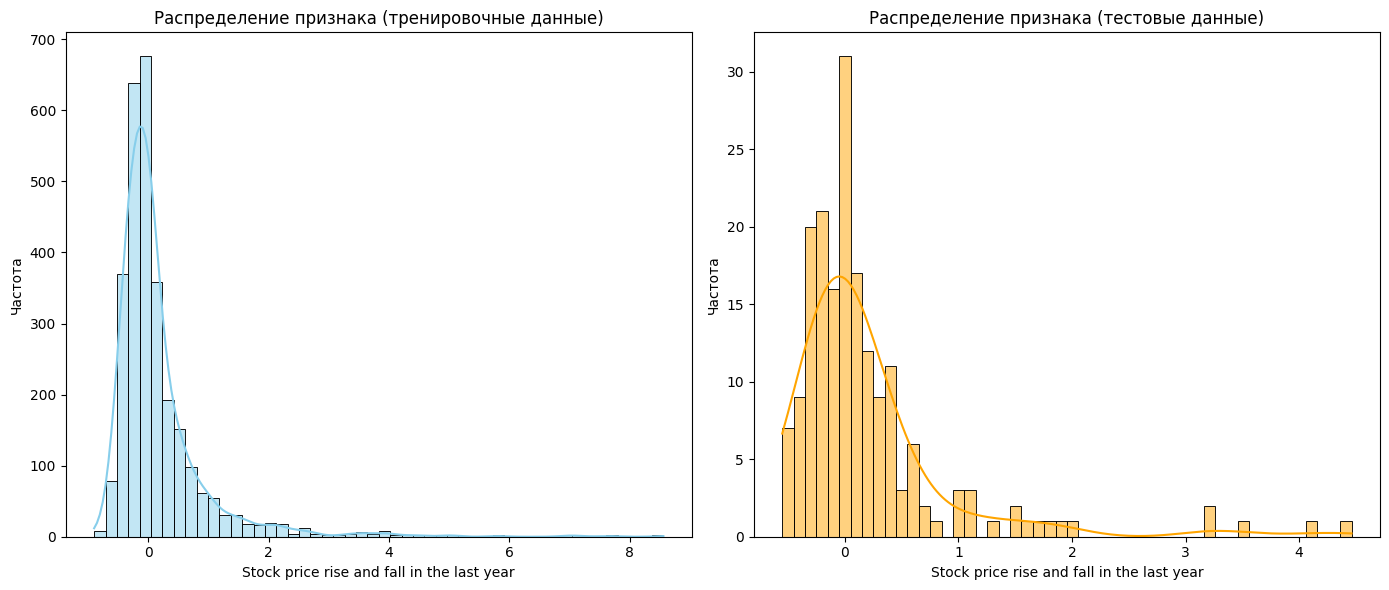

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ГИСТОГРАММА РАСПРЕДЕЛЕНИЯ ==================
print("\nПостроение гистограммы распределения для 'Stock price rise and fall in the last year'...")

plt.figure(figsize=(14, 6))

# Тренировочные данные
plt.subplot(1, 2, 1)
sns.histplot(Xtrain_processed_final['Stock price rise and fall in the last year'], bins=50, color='skyblue', kde=True)
plt.title("Распределение признака (тренировочные данные)")
plt.xlabel("Stock price rise and fall in the last year")
plt.ylabel("Частота")

# Тестовые данные
plt.subplot(1, 2, 2)
sns.histplot(Xtest_processed_final['Stock price rise and fall in the last year'], bins=50, color='orange', kde=True)
plt.title("Распределение признака (тестовые данные)")
plt.xlabel("Stock price rise and fall in the last year")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()

In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ==================
print("\nОписательная статистика для 'Stock price rise and fall in the last year'...")

# Тренировочные данные
print("\nТренировочные данные:")
print(Xtrain_processed_final['Stock price rise and fall in the last year'].describe())

# Тестовые данные
print("\nТестовые данные:")
print(Xtest_processed_final['Stock price rise and fall in the last year'].describe())


Описательная статистика для 'Stock price rise and fall in the last year'...

Тренировочные данные:
count    2884.000000
mean        0.166598
std         0.810820
min        -0.897934
25%        -0.251341
50%        -0.000876
75%         0.265147
max         8.561111
Name: Stock price rise and fall in the last year, dtype: float64

Тестовые данные:
count    184.000000
mean       0.206215
std        0.756773
min       -0.550700
25%       -0.187100
50%        0.000000
75%        0.309975
max        4.460900
Name: Stock price rise and fall in the last year, dtype: float64


In [ ]:
import pandas as pd

# ================== РАСПРЕДЕЛЕНИЕ КАТЕГОРИЙ ==================
print("\nАнализ распределения категорий в тренировочных и тестовых данных...")

for feature in categorical_features_str:
    print(f"\nПризнак: {feature}")

    # Распределение в тренировочных данных
    train_distribution = Xtrain_processed_final[feature].value_counts(normalize=True).sort_index()
    print("Тренировочные данные:")
    print(train_distribution)

    # Распределение в тестовых данных
    test_distribution = Xtest_processed_final[feature].value_counts(normalize=True).sort_index()
    print("Тестовые данные:")
    print(test_distribution)


Анализ распределения категорий в тренировочных и тестовых данных...

Признак: audit opinion 
Тренировочные данные:
audit opinion 
0    0.949376
1    0.021498
2    0.029126
Name: proportion, dtype: float64
Тестовые данные:
audit opinion 
0    0.940217
1    0.043478
2    0.016304
Name: proportion, dtype: float64

Признак: Number of key audit matters
Тренировочные данные:
Number of key audit matters
-999    0.073856
0       0.257975
1       0.087379
2       0.435506
3       0.132455
4       0.012136
5       0.000693
Name: proportion, dtype: float64
Тестовые данные:
Number of key audit matters
-999    0.771739
0       0.130435
1       0.010870
2       0.059783
3       0.027174
Name: proportion, dtype: float64


In [ ]:
# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА ==================
print("\nОписательная статистика для категориальных признаков...")

for feature in categorical_features_str:
    print(f"\nПризнак: {feature}")

    # Тренировочные данные
    train_stats = {
        "Unique values": Xtrain_processed_final[feature].nunique(),
        "Most frequent category": Xtrain_processed_final[feature].mode()[0],
        "Frequency of most frequent": Xtrain_processed_final[feature].value_counts(normalize=True).iloc[0]
    }
    print("Тренировочные данные:")
    print(pd.Series(train_stats))

    # Тестовые данные
    test_stats = {
        "Unique values": Xtest_processed_final[feature].nunique(),
        "Most frequent category": Xtest_processed_final[feature].mode()[0],
        "Frequency of most frequent": Xtest_processed_final[feature].value_counts(normalize=True).iloc[0]
    }
    print("Тестовые данные:")
    print(pd.Series(test_stats))


Описательная статистика для категориальных признаков...

Признак: audit opinion 
Тренировочные данные:
Unique values                        3
Most frequent category               0
Frequency of most frequent    0.949376
dtype: object
Тестовые данные:
Unique values                        3
Most frequent category               0
Frequency of most frequent    0.940217
dtype: object

Признак: Number of key audit matters
Тренировочные данные:
Unique values                        7
Most frequent category               2
Frequency of most frequent    0.435506
dtype: object
Тестовые данные:
Unique values                        5
Most frequent category            -999
Frequency of most frequent    0.771739
dtype: object


In [ ]:
# ================== ВЫВОД КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ (ТИП object) ==================
print("\nКатегориальные признаки (тип object):")

# Тренировочные данные
categorical_features_train = Xtrain_processed_final.select_dtypes(include=['object']).columns.tolist()
print("Тренировочные данные:")
print(categorical_features_train)

# Тестовые данные
categorical_features_test = Xtest_processed_final.select_dtypes(include=['object']).columns.tolist()
print("\nТестовые данные:")
print(categorical_features_test)


Категориальные признаки (тип object):
Тренировочные данные:
['audit opinion ', 'Number of key audit matters']

Тестовые данные:
['audit opinion ', 'Number of key audit matters']


In [ ]:
# ================== УДАЛЕНИЕ ЛИШНИХ ПРОБЕЛОВ И ПРИВЕДЕНИЕ К НИЖНЕМУ РЕГИСТРУ ==================
print("\nУдаление лишних пробелов и приведение имен признаков к нижнему регистру...")

# Тренировочные данные
Xtrain_processed_final.columns = Xtrain_processed_final.columns.str.strip().str.lower()
print("Тренировочные данные:")
print(Xtrain_processed_final.columns)

# Тестовые данные
Xtest_processed_final.columns = Xtest_processed_final.columns.str.strip().str.lower()
print("\nТестовые данные:")
print(Xtest_processed_final.columns)


Удаление лишних пробелов и приведение имен признаков к нижнему регистру...
Тренировочные данные:
Index(['z-score', 'share pledge ratio of controlling shareholders',
       'pledge ratio of limited sale shares',
       'pledge ratio of unlimited shares', 'stock volatility', 'p/e ratio',
       'p/b ratio', 'stock price rise and fall in the last year',
       'annual turnover rate', 'st', 'roa', 'roe', 'changes in net assets',
       'changes in operating income', 'gross profit margin on sales',
       'net business cycle (days)',
       'turnover rate of accounts receivable (times)',
       'inventory turnover rate (times)', 'total asset turnover rate (times)',
       'current ratio', 'cash ratio', 'asset liability ratio',
       'asset liability ratio (excluding advance receipts)',
       'asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts)',
       'current liabilities/total liabilitie

In [ ]:
# Обновляем список категориальных признаков
categorical_features_str = [col.strip().lower() for col in categorical_features_str]

print("Категориальные признаки после обработки:")
print(categorical_features_str)

Категориальные признаки после обработки:
['audit opinion', 'number of key audit matters']


In [ ]:
# Проверяем наличие признаков
for feature in categorical_features_str:
    if feature not in Xtrain_processed_final.columns or feature not in Xtest_processed_final.columns:
        print(f"Признак '{feature}' отсутствует в данных.")
    else:
        print(f"Признак '{feature}' найден.")

Признак 'audit opinion' найден.
Признак 'number of key audit matters' найден.


In [ ]:
if 'audit opinion' in Xtrain_processed_final.columns and 'audit opinion' in Xtest_processed_final.columns:
    Xtrain_processed_final['audit opinion'] = Xtrain_processed_final['audit opinion'].apply(lambda x: 'Other' if x in ['1', '2'] else x)
    Xtest_processed_final['audit opinion'] = Xtest_processed_final['audit opinion'].apply(lambda x: 'Other' if x in ['1', '2'] else x)
    print("Редкие категории объединены.")
else:
    print("Признак 'audit opinion' отсутствует в данных.")

Редкие категории объединены.


In [ ]:
# Проверяем распределение категорий после обработки
for feature in categorical_features_str:
    print(f"\nПризнак: {feature}")

    # Тренировочные данные
    train_distribution = Xtrain_processed_final[feature].value_counts(normalize=True).sort_index()
    print("Тренировочные данные:")
    print(train_distribution)

    # Тестовые данные
    test_distribution = Xtest_processed_final[feature].value_counts(normalize=True).sort_index()
    print("Тестовые данные:")
    print(test_distribution)


Признак: audit opinion
Тренировочные данные:
audit opinion
0        0.949376
Other    0.050624
Name: proportion, dtype: float64
Тестовые данные:
audit opinion
0        0.940217
Other    0.059783
Name: proportion, dtype: float64

Признак: number of key audit matters
Тренировочные данные:
number of key audit matters
-999    0.073856
0       0.257975
1       0.087379
2       0.435506
3       0.132455
4       0.012136
5       0.000693
Name: proportion, dtype: float64
Тестовые данные:
number of key audit matters
-999    0.771739
0       0.130435
1       0.010870
2       0.059783
3       0.027174
Name: proportion, dtype: float64



Анализ корреляции для 'audit opinion'...
Средняя доля дефолтов для каждой категории 'audit opinion':
audit opinion
Other    0.726027
0        0.155588
Name: Target, dtype: float64


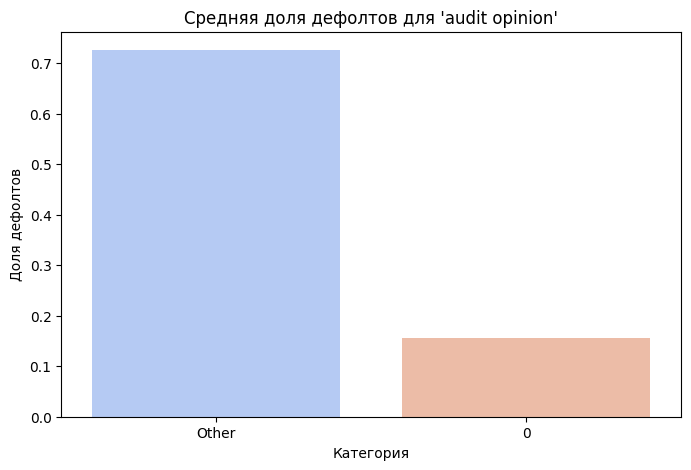

In [ ]:
import pandas as pd

# ================== АНАЛИЗ КОРРЕЛЯЦИИ ДЛЯ 'audit opinion' ==================
print("\nАнализ корреляции для 'audit opinion'...")

# Создаем временный DataFrame
temp_df = Xtrain_processed_final[['audit opinion']].copy()
temp_df['Target'] = ytrain_extended

# Группировка данных по 'audit opinion'
correlation_audit_opinion = temp_df.groupby('audit opinion')['Target'].mean().sort_values(ascending=False)
print("Средняя доля дефолтов для каждой категории 'audit opinion':")
print(correlation_audit_opinion)

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x=correlation_audit_opinion.index, y=correlation_audit_opinion.values, palette='coolwarm')
plt.title("Средняя доля дефолтов для 'audit opinion'")
plt.xlabel("Категория")
plt.ylabel("Доля дефолтов")
plt.show()


Анализ корреляции для 'number of key audit matters'...
Средняя доля дефолтов для каждой категории 'number of key audit matters':
number of key audit matters
0       0.266129
4       0.228571
3       0.217277
-999    0.197183
2       0.134554
1       0.126984
5       0.000000
Name: Target, dtype: float64


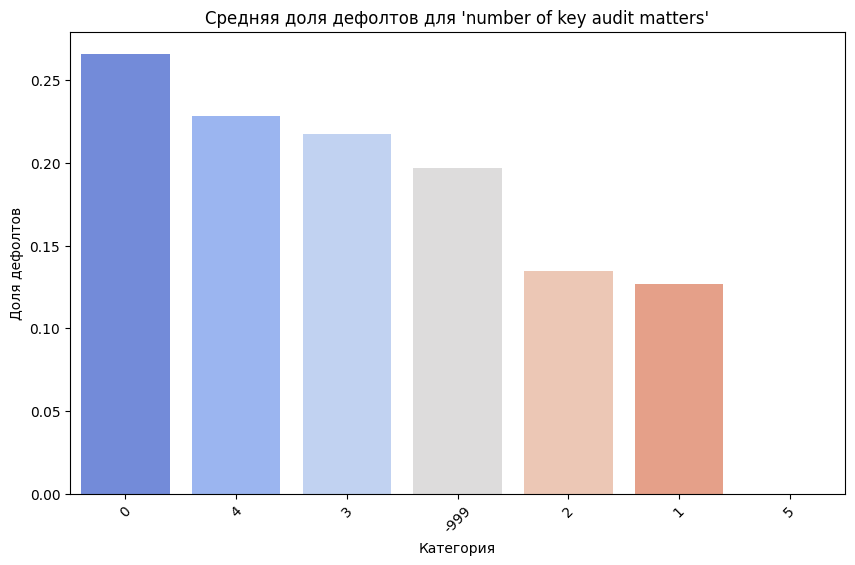

In [ ]:
# ================== АНАЛИЗ КОРРЕЛЯЦИИ ДЛЯ 'number of key audit matters' ==================
print("\nАнализ корреляции для 'number of key audit matters'...")

# Создаем временный DataFrame
temp_df = Xtrain_processed_final[['number of key audit matters']].copy()
temp_df['Target'] = ytrain_extended

# Группировка данных по 'number of key audit matters'
correlation_key_audit_matters = temp_df.groupby('number of key audit matters')['Target'].mean().sort_values(ascending=False)
print("Средняя доля дефолтов для каждой категории 'number of key audit matters':")
print(correlation_key_audit_matters)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_key_audit_matters.index.astype(str), y=correlation_key_audit_matters.values, palette='coolwarm')
plt.title("Средняя доля дефолтов для 'number of key audit matters'")
plt.xlabel("Категория")
plt.ylabel("Доля дефолтов")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

# ================== ПРИМЕНЕНИЕ ONE-HOT ENCODING ==================
print("\nПрименение One-Hot Encoding к категориальным признакам...")

# Список категориальных признаков
categorical_features = ['audit opinion', 'number of key audit matters']

# One-Hot Encoding для тренировочных данных
Xtrain_encoded = pd.get_dummies(Xtrain_processed_final, columns=categorical_features, drop_first=False)

# One-Hot Encoding для тестовых данных
Xtest_encoded = pd.get_dummies(Xtest_processed_final, columns=categorical_features, drop_first=False)

# Проверяем, что все категории присутствуют в тестовых данных
missing_cols = set(Xtrain_encoded.columns) - set(Xtest_encoded.columns)
for col in missing_cols:
    Xtest_encoded[col] = 0  # Добавляем недостающие столбцы с нулями

# Убедимся, что порядок столбцов одинаковый
Xtest_encoded = Xtest_encoded[Xtrain_encoded.columns]

print("One-Hot Encoding применен.")


Применение One-Hot Encoding к категориальным признакам...
One-Hot Encoding применен.


In [ ]:
# ================== ВЫВОД СОЗДАННЫХ ПРИЗНАКОВ ==================
print("\nСозданные признаки после One-Hot Encoding:")

# Фильтруем столбцы, начинающиеся с префиксов категориальных признаков
created_features_train = [col for col in Xtrain_encoded.columns if col.startswith('audit opinion_') or col.startswith('number of key audit matters_')]
created_features_test = [col for col in Xtest_encoded.columns if col.startswith('audit opinion_') or col.startswith('number of key audit matters_')]

# Выводим первые строки только для созданных признаков
print("\nПервые строки созданных признаков в тренировочных данных:")
print(Xtrain_encoded[created_features_train].head())

print("\nПервые строки созданных признаков в тестовых данных:")
print(Xtest_encoded[created_features_test].head())


Созданные признаки после One-Hot Encoding:

Первые строки созданных признаков в тренировочных данных:
   number of key audit matters_is_missing  audit opinion_0  \
0                                       0             True   
1                                       0             True   
2                                       0             True   
3                                       0             True   
4                                       0             True   

   audit opinion_Other  number of key audit matters_-999  \
0                False                             False   
1                False                             False   
2                False                             False   
3                False                             False   
4                False                             False   

   number of key audit matters_0  number of key audit matters_1  \
0                          False                          False   
1                          Fa

In [ ]:
print(Xtrain_encoded.dtypes)

z-score                                           float64
share pledge ratio of controlling shareholders    float64
pledge ratio of limited sale shares               float64
pledge ratio of unlimited shares                  float64
stock volatility                                  float64
                                                   ...   
number of key audit matters_1                        bool
number of key audit matters_2                        bool
number of key audit matters_3                        bool
number of key audit matters_4                        bool
number of key audit matters_5                        bool
Length: 83, dtype: object


In [ ]:
# ================== УДАЛЕНИЕ ИСХОДНЫХ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ==================
print("\nУдаление исходных категориальных признаков...")

# Список исходных категориальных признаков
original_categorical_features = ['audit opinion', 'number of key audit matters']

# Удаляем исходные признаки из тренировочных данных
Xtrain_final = Xtrain_encoded.drop(columns=original_categorical_features, errors='ignore')

# Удаляем исходные признаки из тестовых данных
Xtest_final = Xtest_encoded.drop(columns=original_categorical_features, errors='ignore')

print("Исходные категориальные признаки удалены.")


Удаление исходных категориальных признаков...
Исходные категориальные признаки удалены.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ КОЭФФИЦИЕНТА ВАРИАЦИИ ==================
print("\nАнализ коэффициента вариации для числовых признаков...")

# Определяем числовые признаки
numeric_features = [col for col in Xtrain_final.columns if Xtrain_final[col].dtype != 'bool']

# Создаем DataFrame для хранения результатов
variation_analysis = pd.DataFrame(index=numeric_features, columns=['Mean', 'Std', 'Variation', 'Unique Values'])

# Вычисляем среднее, стандартное отклонение, коэффициент вариации и количество уникальных значений
for feature in numeric_features:
    mean_value = Xtrain_final[feature].mean()
    std_value = Xtrain_final[feature].std()
    variation = std_value / mean_value if mean_value != 0 else 0  # Защита от деления на ноль
    unique_values = Xtrain_final[feature].nunique()
    variation_analysis.loc[feature] = [mean_value, std_value, variation, unique_values]

# Сортируем по убыванию коэффициента вариации
variation_analysis = variation_analysis.sort_values(by='Variation', ascending=False)

# Выводим первые 10 признаков
print("Первые 10 признаков с наибольшим коэффициентом вариации:")
print(variation_analysis.head(10))


Анализ коэффициента вариации для числовых признаков...
Первые 10 признаков с наибольшим коэффициентом вариации:
                                                   Mean          Std  \
inventory turnover rate (times)               96.871723  2138.071981   
high deposit and loan of 90p                   0.002774     0.052604   
p/e ratio_has_comma                            0.004854     0.069516   
turnover rate of accounts receivable (times)  48.888059   662.776983   
st                                             0.006241     0.078769   
ebitda/interest bearing debt                   9.754615   119.164613   
p/e ratio                                     41.151896   426.328716   
ebit interest cover                           53.780748    500.29854   
ebitda interest cover                         71.840433   636.330952   
p/b ratio                                      4.996093    37.631469   

                                              Variation Unique Values  
inventory turnover rat


Визуализация распределения для топ-10 признаков с наибольшим коэффициентом вариации...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

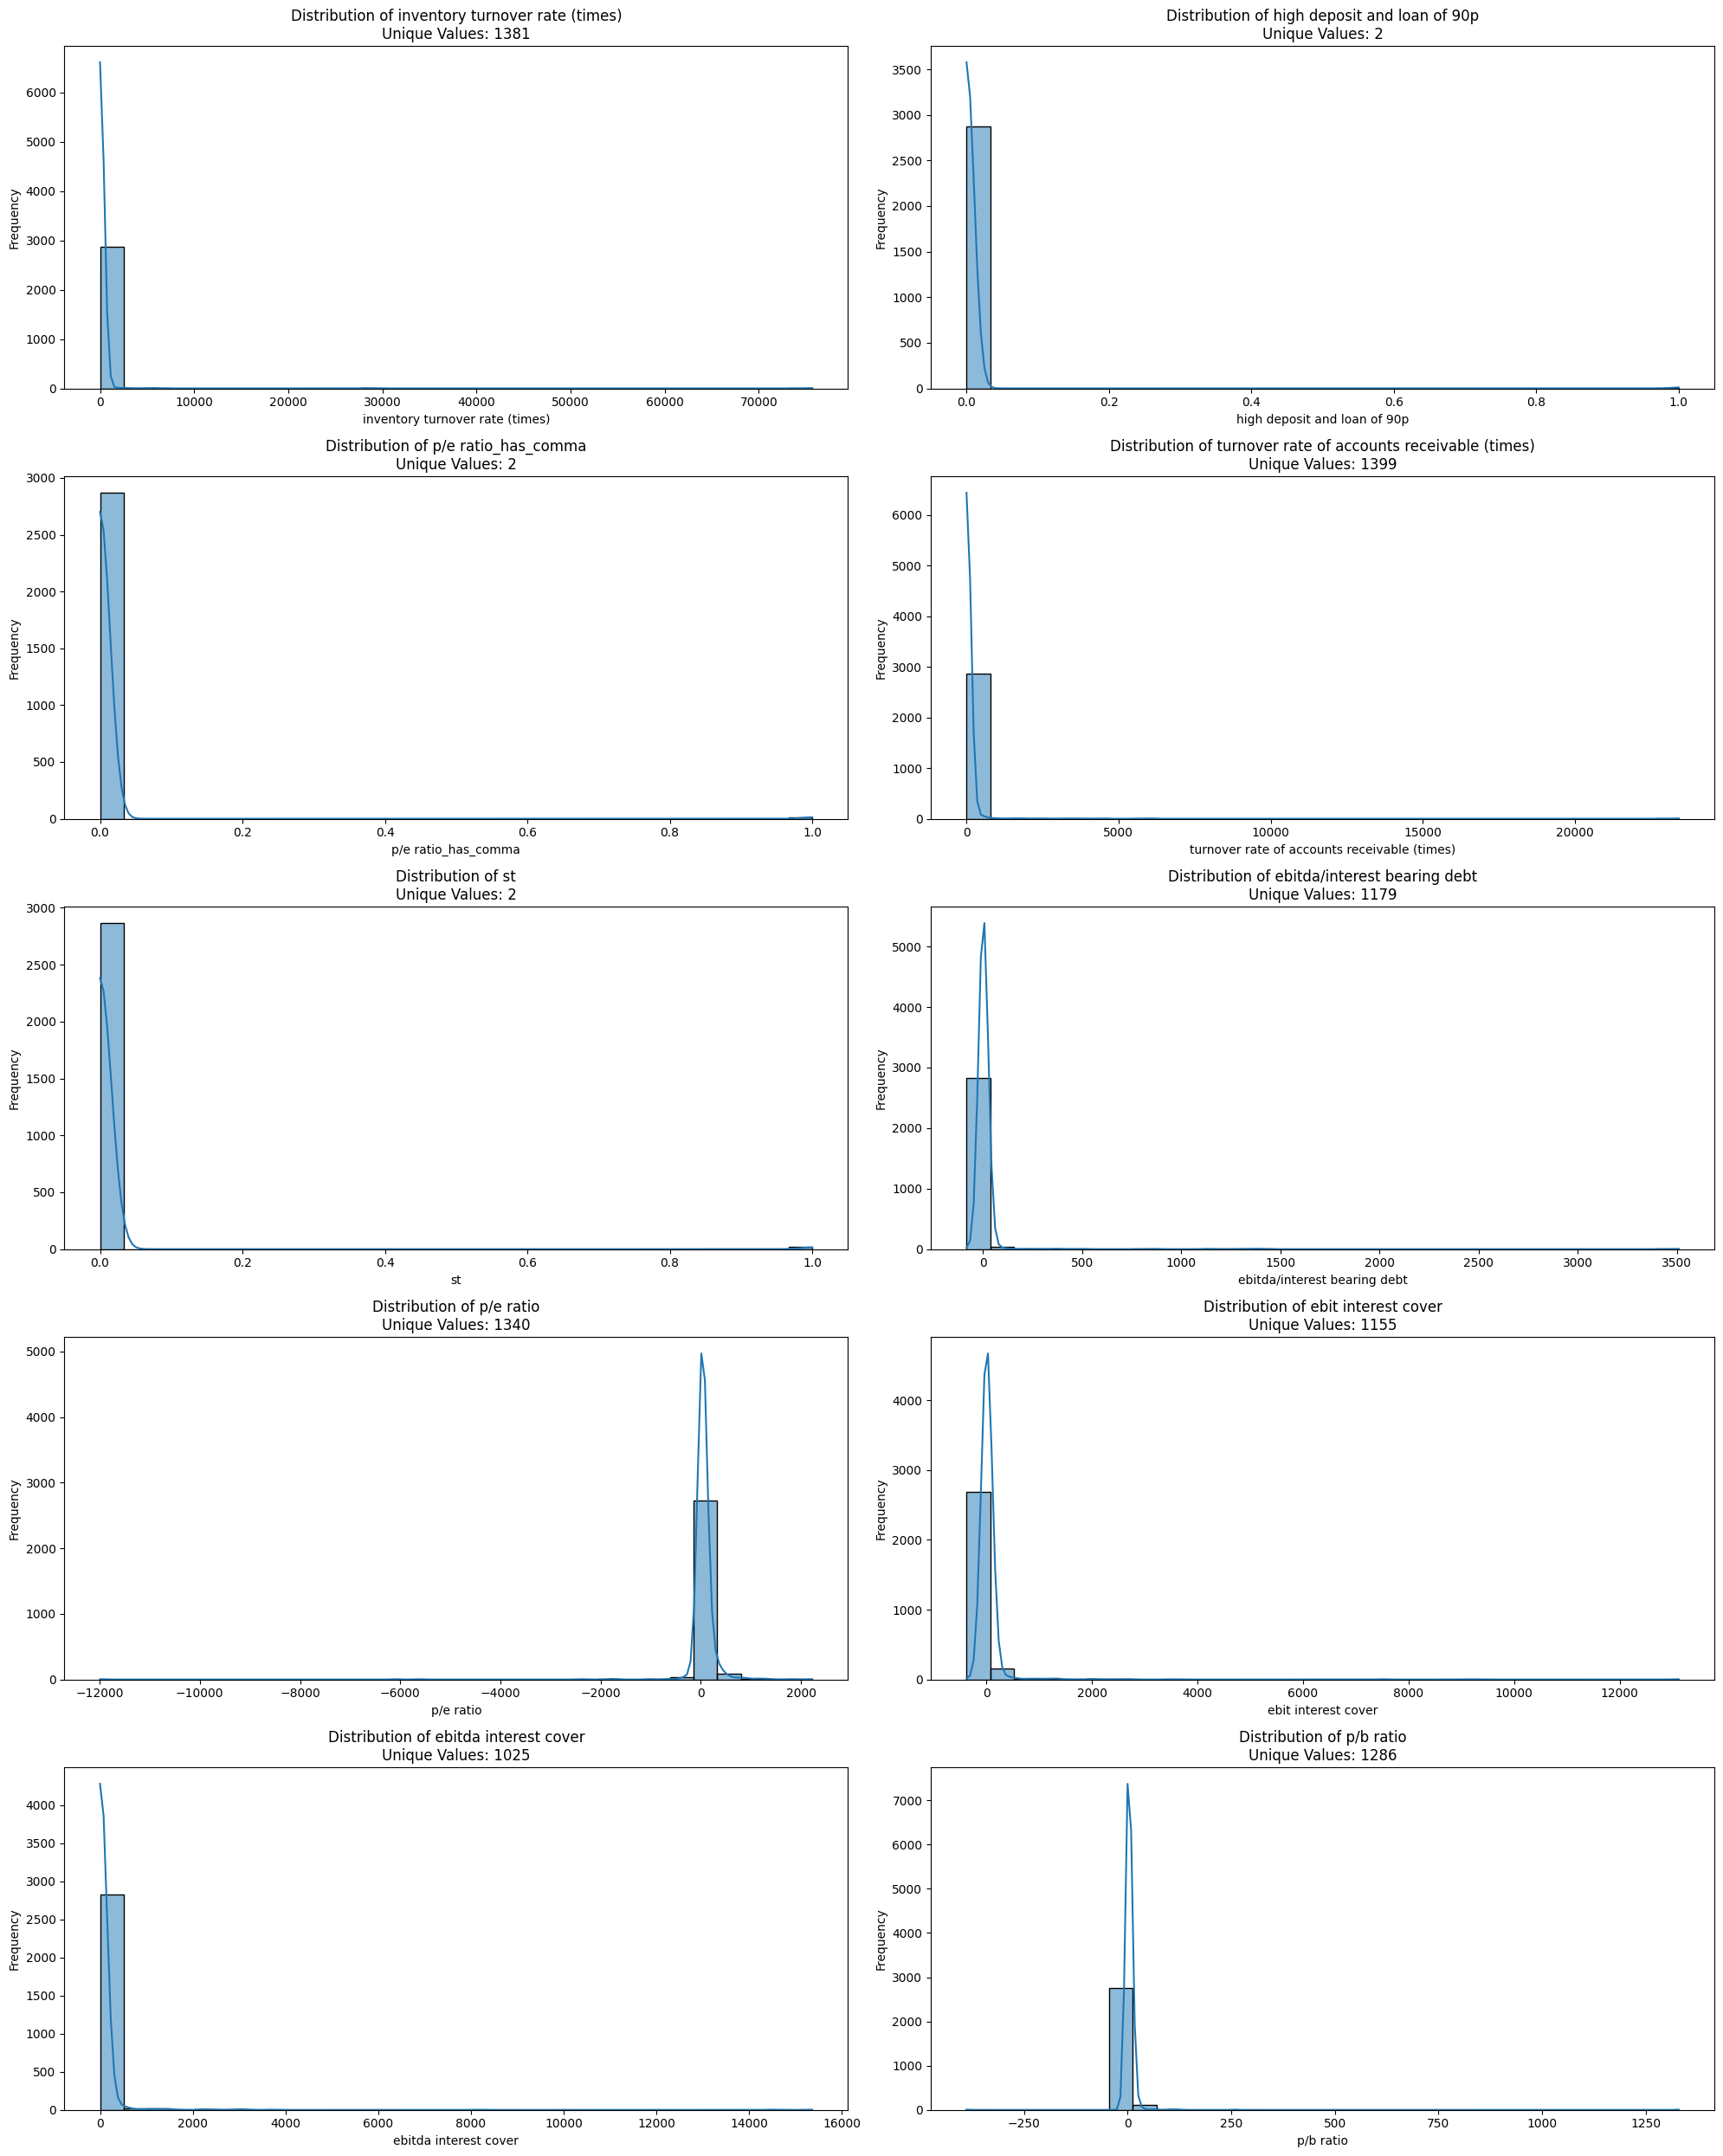

In [ ]:
# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ==================
print("\nВизуализация распределения для топ-10 признаков с наибольшим коэффициентом вариации...")

# Выбираем топ-10 признаков
top_features = variation_analysis.index[:10]

# Строим графики
plt.figure(figsize=(20, 25))
for i, feature in enumerate(top_features):
    plt.subplot(5, 2, i + 1)  # 5 строк, 2 столбца
    sns.histplot(Xtrain_final[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}\nUnique Values: {variation_analysis.loc[feature, 'Unique Values']}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
# ================== ПРОВЕРКА ПРИЗНАКОВ С "time" ИЛИ "times" ==================
print("\nПроверка признаков с 'time' или 'times' в названии...")

# Фильтруем признаки, содержащие 'time' или 'times'
time_related_features = [col for col in Xtrain_final.columns if 'time' in col.lower() or 'times' in col.lower()]

# Выводим список таких признаков
print("Признаки с 'time' или 'times' в названии:")
for feature in time_related_features:
    print(f"- {feature}")


Проверка признаков с 'time' или 'times' в названии...
Признаки с 'time' или 'times' в названии:
- turnover rate of accounts receivable (times)
- inventory turnover rate (times)
- total asset turnover rate (times)



Визуализация распределения для признаков с 'time' или 'times'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


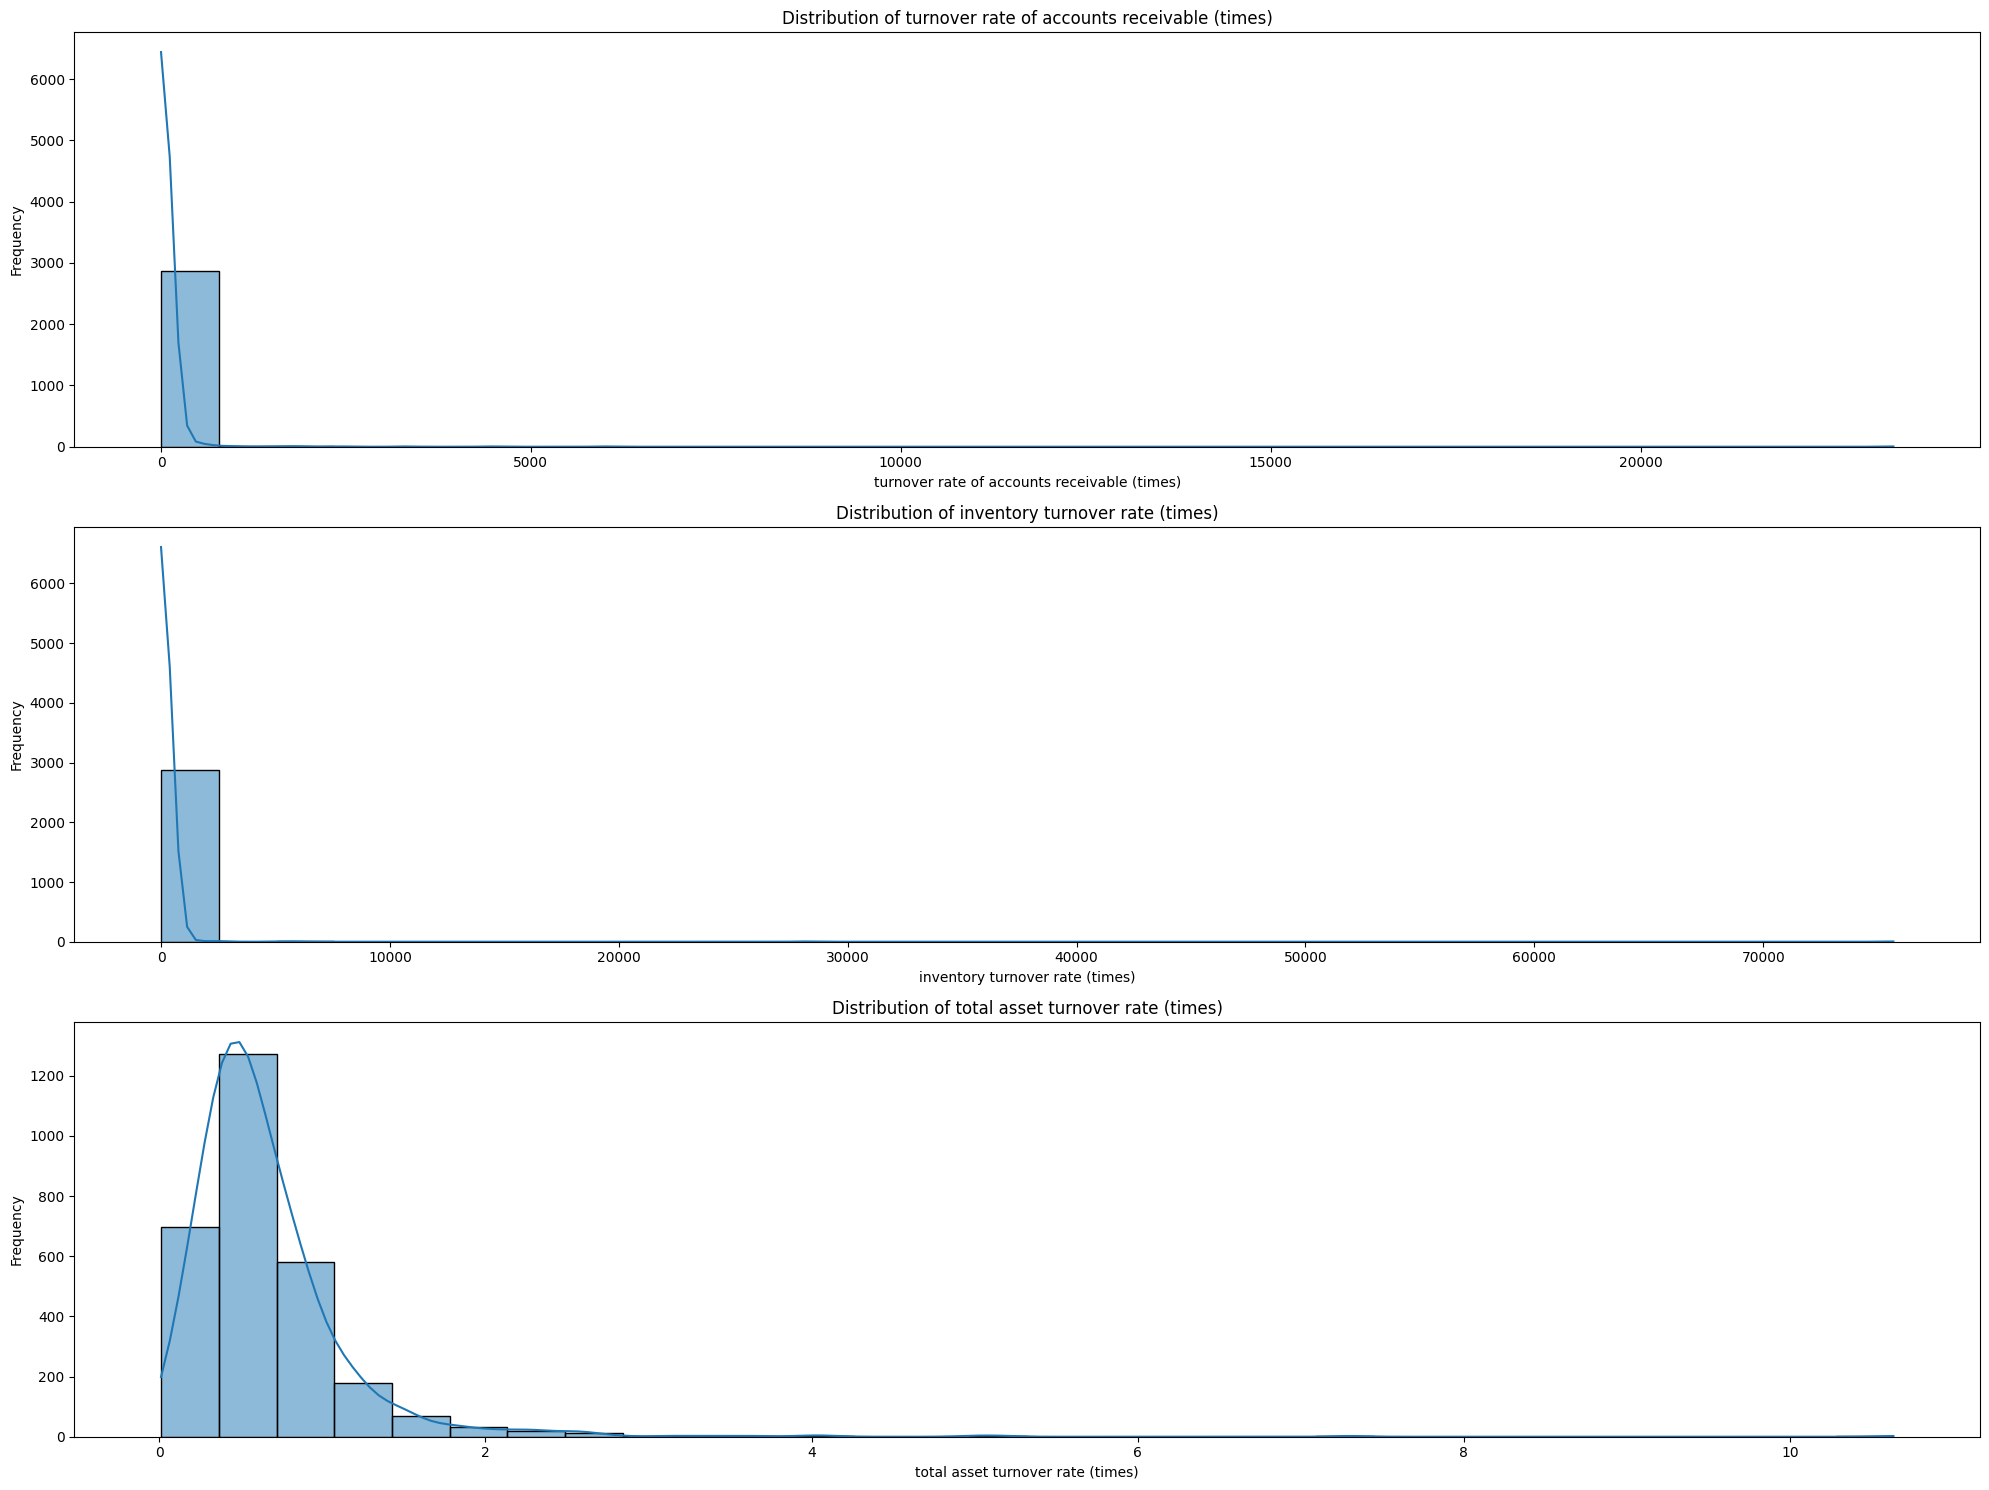

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ==================
print("\nВизуализация распределения для признаков с 'time' или 'times'...")

# Строим графики
plt.figure(figsize=(20, 5 * len(time_related_features)))
for i, feature in enumerate(time_related_features):
    plt.subplot(len(time_related_features), 1, i + 1)  # По одному графику на признак
    sns.histplot(Xtrain_final[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# ================== ОПИСАТЕЛЬНАЯ СТАТИСТИКА И КОРРЕЛЯЦИЯ ==================
print("\nОписательная статистика и корреляция с целевой переменной...")

# Выбираем признаки с 'time' или 'times'
time_related_features = [
    'turnover rate of accounts receivable (times)',
    'inventory turnover rate (times)',
    'total asset turnover rate (times)'
]

# Создаем DataFrame для хранения результатов
stats_and_correlation = pd.DataFrame(index=time_related_features, columns=['Mean', 'Std', 'Min', 'Max', 'Correlation'])

# Вычисляем описательную статистику и корреляцию
for feature in time_related_features:
    mean_value = Xtrain_final[feature].mean()
    std_value = Xtrain_final[feature].std()
    min_value = Xtrain_final[feature].min()
    max_value = Xtrain_final[feature].max()
    correlation = Xtrain_final[feature].corr(ytrain_extended)  # Корреляция с целевой переменной
    stats_and_correlation.loc[feature] = [mean_value, std_value, min_value, max_value, correlation]

# Выводим результаты
print("Описательная статистика и корреляция с целевой переменной:")
print(stats_and_correlation)


Описательная статистика и корреляция с целевой переменной...
Описательная статистика и корреляция с целевой переменной:
                                                   Mean          Std   Min  \
turnover rate of accounts receivable (times)  48.888059   662.776983   0.0   
inventory turnover rate (times)               96.871723  2138.071981   0.0   
total asset turnover rate (times)              0.659166     0.564181  0.01   

                                                     Max Correlation  
turnover rate of accounts receivable (times)  23415.9145   -0.021961  
inventory turnover rate (times)                 75684.53    0.069004  
total asset turnover rate (times)                10.6354   -0.124467  


In [ ]:
Xtrain_final['turnover rate of accounts receivable (times)'] = Xtrain_final['turnover rate of accounts receivable (times)'].apply(lambda x: np.log1p(x))
Xtest_final['turnover rate of accounts receivable (times)'] = Xtest_final['turnover rate of accounts receivable (times)'].apply(lambda x: np.log1p(x))

Xtrain_final['inventory turnover rate (times)'] = Xtrain_final['inventory turnover rate (times)'].apply(lambda x: np.log1p(x))
Xtest_final['inventory turnover rate (times)'] = Xtest_final['inventory turnover rate (times)'].apply(lambda x: np.log1p(x))


Описательная статистика и корреляция с целевой переменной после логарифмического преобразования:
                                                  Mean       Std  Min  \
turnover rate of accounts receivable (times)  1.967527  1.140158  0.0   
inventory turnover rate (times)               1.683333  1.075204  0.0   

                                                    Max Correlation  
turnover rate of accounts receivable (times)  10.061214   -0.061948  
inventory turnover rate (times)               11.234342   -0.012877  

Визуализация распределения для преобразованных признаков...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


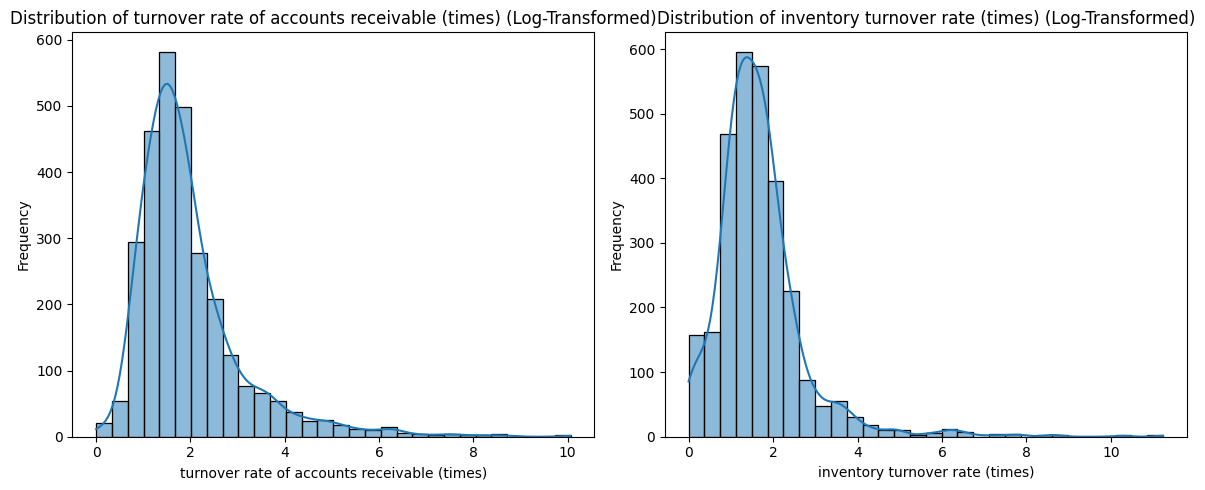

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ ПОСЛЕ ЛОГАРИФМИЧЕСКОГО ПРЕОБРАЗОВАНИЯ ==================

# Выбираем признаки, которые были преобразованы
transformed_features = [
    'turnover rate of accounts receivable (times)',
    'inventory turnover rate (times)'
]

# Создаем DataFrame для хранения результатов
stats_and_correlation_transformed = pd.DataFrame(index=transformed_features, columns=['Mean', 'Std', 'Min', 'Max', 'Correlation'])

# Вычисляем описательную статистику и корреляцию
for feature in transformed_features:
    mean_value = Xtrain_final[feature].mean()
    std_value = Xtrain_final[feature].std()
    min_value = Xtrain_final[feature].min()
    max_value = Xtrain_final[feature].max()
    correlation = Xtrain_final[feature].corr(ytrain_extended)  # Корреляция с целевой переменной
    stats_and_correlation_transformed.loc[feature] = [mean_value, std_value, min_value, max_value, correlation]

# Выводим результаты
print("\nОписательная статистика и корреляция с целевой переменной после логарифмического преобразования:")
print(stats_and_correlation_transformed)

# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ==================
print("\nВизуализация распределения для преобразованных признаков...")

# Строим графики
plt.figure(figsize=(12, 5))
for i, feature in enumerate(transformed_features):
    plt.subplot(1, len(transformed_features), i + 1)
    sns.histplot(Xtrain_final[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature} (Log-Transformed)")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ КОЭФФИЦИЕНТА ВАРИАЦИИ И КОРРЕЛЯЦИИ ==================
print("\nАнализ коэффициента вариации и корреляции для числовых признаков...")

# Определяем числовые признаки
numeric_features = [col for col in Xtrain_final.columns if Xtrain_final[col].dtype != 'bool']

# Создаем DataFrame для хранения результатов
variation_analysis = pd.DataFrame(index=numeric_features, columns=['Mean', 'Std', 'Variation', 'Unique Values', 'Correlation'])

# Вычисляем среднее, стандартное отклонение, коэффициент вариации, количество уникальных значений и корреляцию
for feature in numeric_features:
    mean_value = Xtrain_final[feature].mean()
    std_value = Xtrain_final[feature].std()
    variation = std_value / mean_value if mean_value != 0 else 0  # Защита от деления на ноль
    unique_values = Xtrain_final[feature].nunique()
    correlation = Xtrain_final[feature].corr(ytrain_extended)  # Корреляция с целевой переменной
    variation_analysis.loc[feature] = [mean_value, std_value, variation, unique_values, correlation]

# Сортируем по убыванию коэффициента вариации
variation_analysis = variation_analysis.sort_values(by='Variation', ascending=False)

# Выводим первые 10 признаков
print("Первые 10 признаков с наибольшим коэффициентом вариации:")
print(variation_analysis.head(10))


Анализ коэффициента вариации и корреляции для числовых признаков...
Первые 10 признаков с наибольшим коэффициентом вариации:
                                   Mean         Std  Variation Unique Values  \
high deposit and loan of 90p   0.002774    0.052604  18.963773             2   
p/e ratio_has_comma            0.004854    0.069516  14.320304             2   
st                             0.006241    0.078769  12.620517             2   
ebitda/interest bearing debt   9.754615  119.164613  12.216229          1179   
p/e ratio                     41.151896  426.328716   10.35988          1340   
ebit interest cover           53.780748   500.29854   9.302558          1155   
ebitda interest cover         71.840433  636.330952    8.85756          1025   
p/b ratio                      4.996093   37.631469    7.53218          1286   
downgrade or negative          0.020111    0.140404   6.981478             2   
financial cycle m2/gdp         0.009073    0.061228   6.748285            


Визуализация распределения для топ-10 признаков с наибольшим коэффициентом вариации...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

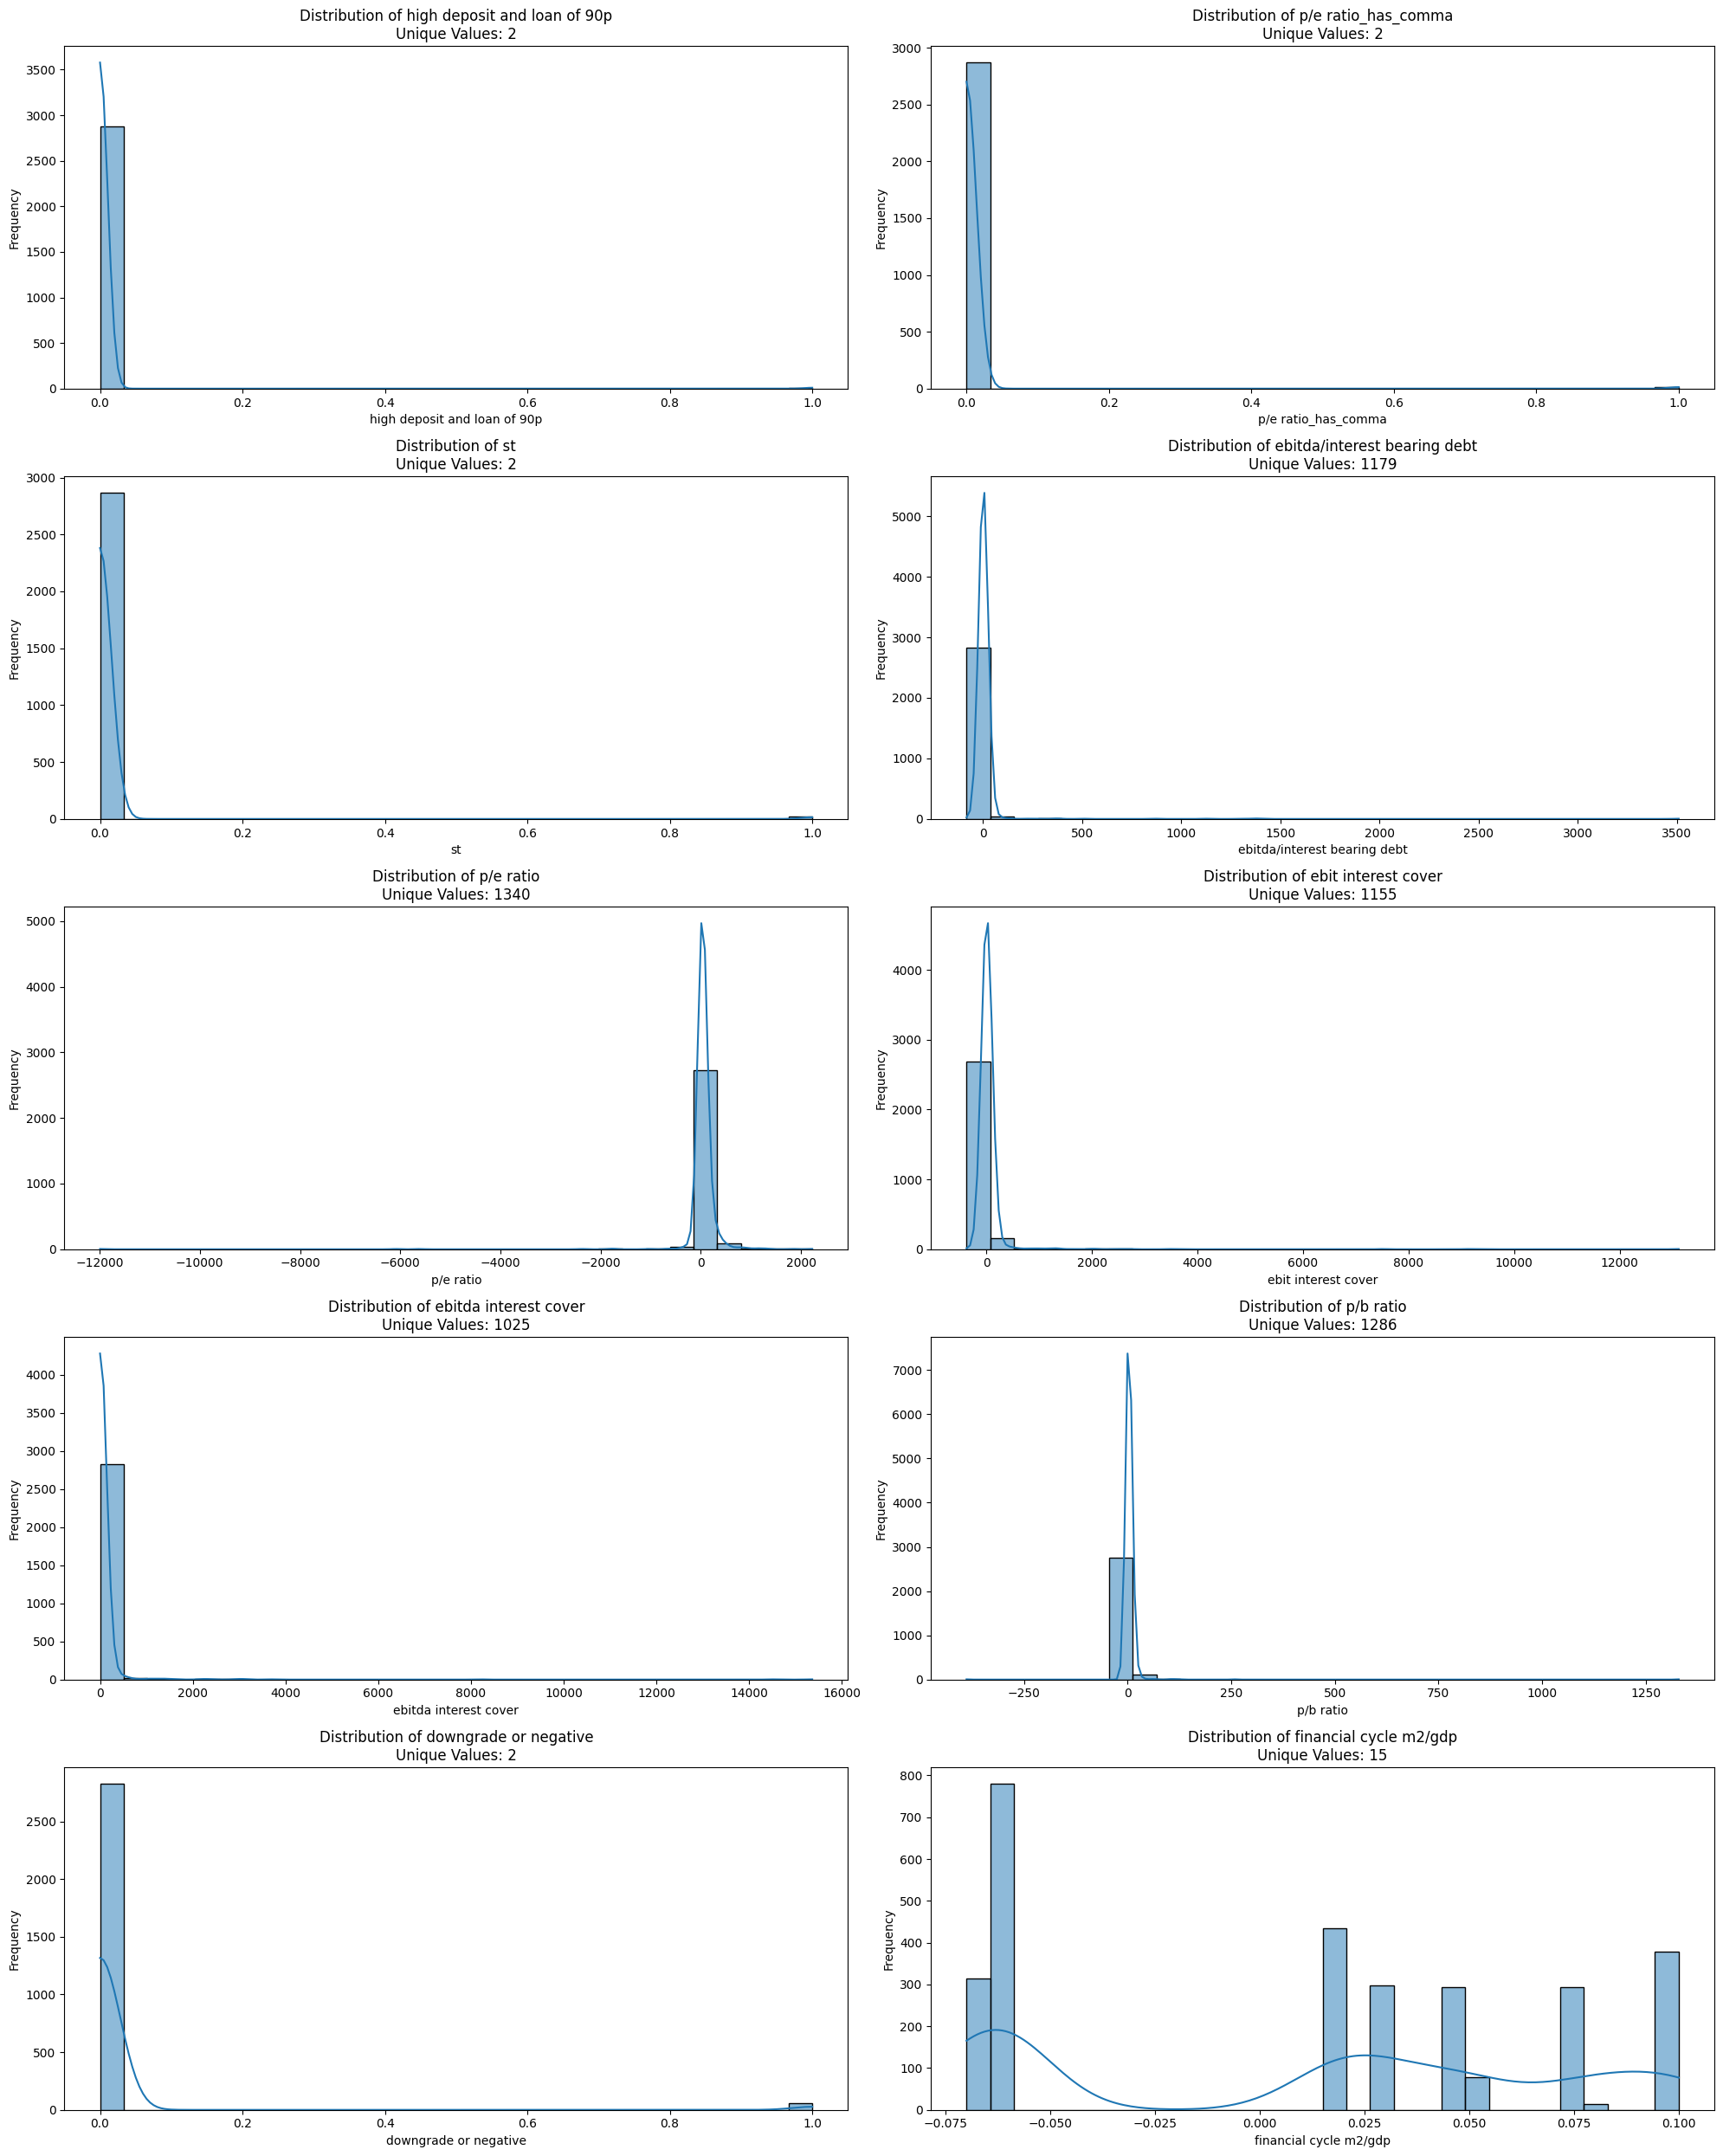

In [ ]:
# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ==================
print("\nВизуализация распределения для топ-10 признаков с наибольшим коэффициентом вариации...")

# Выбираем топ-10 признаков
top_features = variation_analysis.index[:10]

# Строим графики
plt.figure(figsize=(20, 25))
for i, feature in enumerate(top_features):
    plt.subplot(5, 2, i + 1)  # 5 строк, 2 столбца
    sns.histplot(Xtrain_final[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}\nUnique Values: {variation_analysis.loc[feature, 'Unique Values']}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# ================== АНАЛИЗ КОЭФФИЦИЕНТА ВАРИАЦИИ И КОРРЕЛЯЦИИ ==================
print("\nАнализ коэффициента вариации и корреляции для числовых признаков...")

# Определяем числовые признаки
numeric_features = [col for col in Xtrain_final.columns if Xtrain_final[col].dtype != 'bool']

# Создаем DataFrame для хранения результатов
variation_analysis = pd.DataFrame(index=numeric_features, columns=['Mean', 'Std', 'Variation', 'Unique Values', 'Correlation'])

# Вычисляем среднее, стандартное отклонение, коэффициент вариации, количество уникальных значений и корреляцию
for feature in numeric_features:
    mean_value = Xtrain_final[feature].mean()
    std_value = Xtrain_final[feature].std()
    variation = std_value / mean_value if mean_value != 0 else 0  # Защита от деления на ноль
    unique_values = Xtrain_final[feature].nunique()
    correlation = Xtrain_final[feature].corr(ytrain_extended)  # Корреляция с целевой переменной
    variation_analysis.loc[feature] = [mean_value, std_value, variation, unique_values, correlation]

# Фильтруем признаки: оставляем только те, где количество уникальных значений > 2
variation_analysis = variation_analysis[variation_analysis['Unique Values'] > 2]

# Сортируем по убыванию коэффициента вариации
variation_analysis = variation_analysis.sort_values(by='Variation', ascending=False)

# Выводим первые 10 признаков
print("Первые 10 признаков с наибольшим коэффициентом вариации:")
print(variation_analysis.head(10))


Анализ коэффициента вариации и корреляции для числовых признаков...
Первые 10 признаков с наибольшим коэффициентом вариации:
                                                 Mean         Std  Variation  \
ebitda/interest bearing debt                 9.754615  119.164613  12.216229   
p/e ratio                                   41.151896  426.328716   10.35988   
ebit interest cover                         53.780748   500.29854   9.302558   
ebitda interest cover                       71.840433  636.330952    8.85756   
p/b ratio                                    4.996093   37.631469    7.53218   
financial cycle m2/gdp                       0.009073    0.061228   6.748285   
roe                                          0.048524    0.291209   6.001336   
stock price rise and fall in the last year   0.166598     0.81082   4.866917   
ratio of prepayments to operating income     0.054013    0.258705   4.789717   
changes in operating income                   0.20633    0.690751   3.3477


Визуализация распределения для топ-10 признаков с наибольшим коэффициентом вариации...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

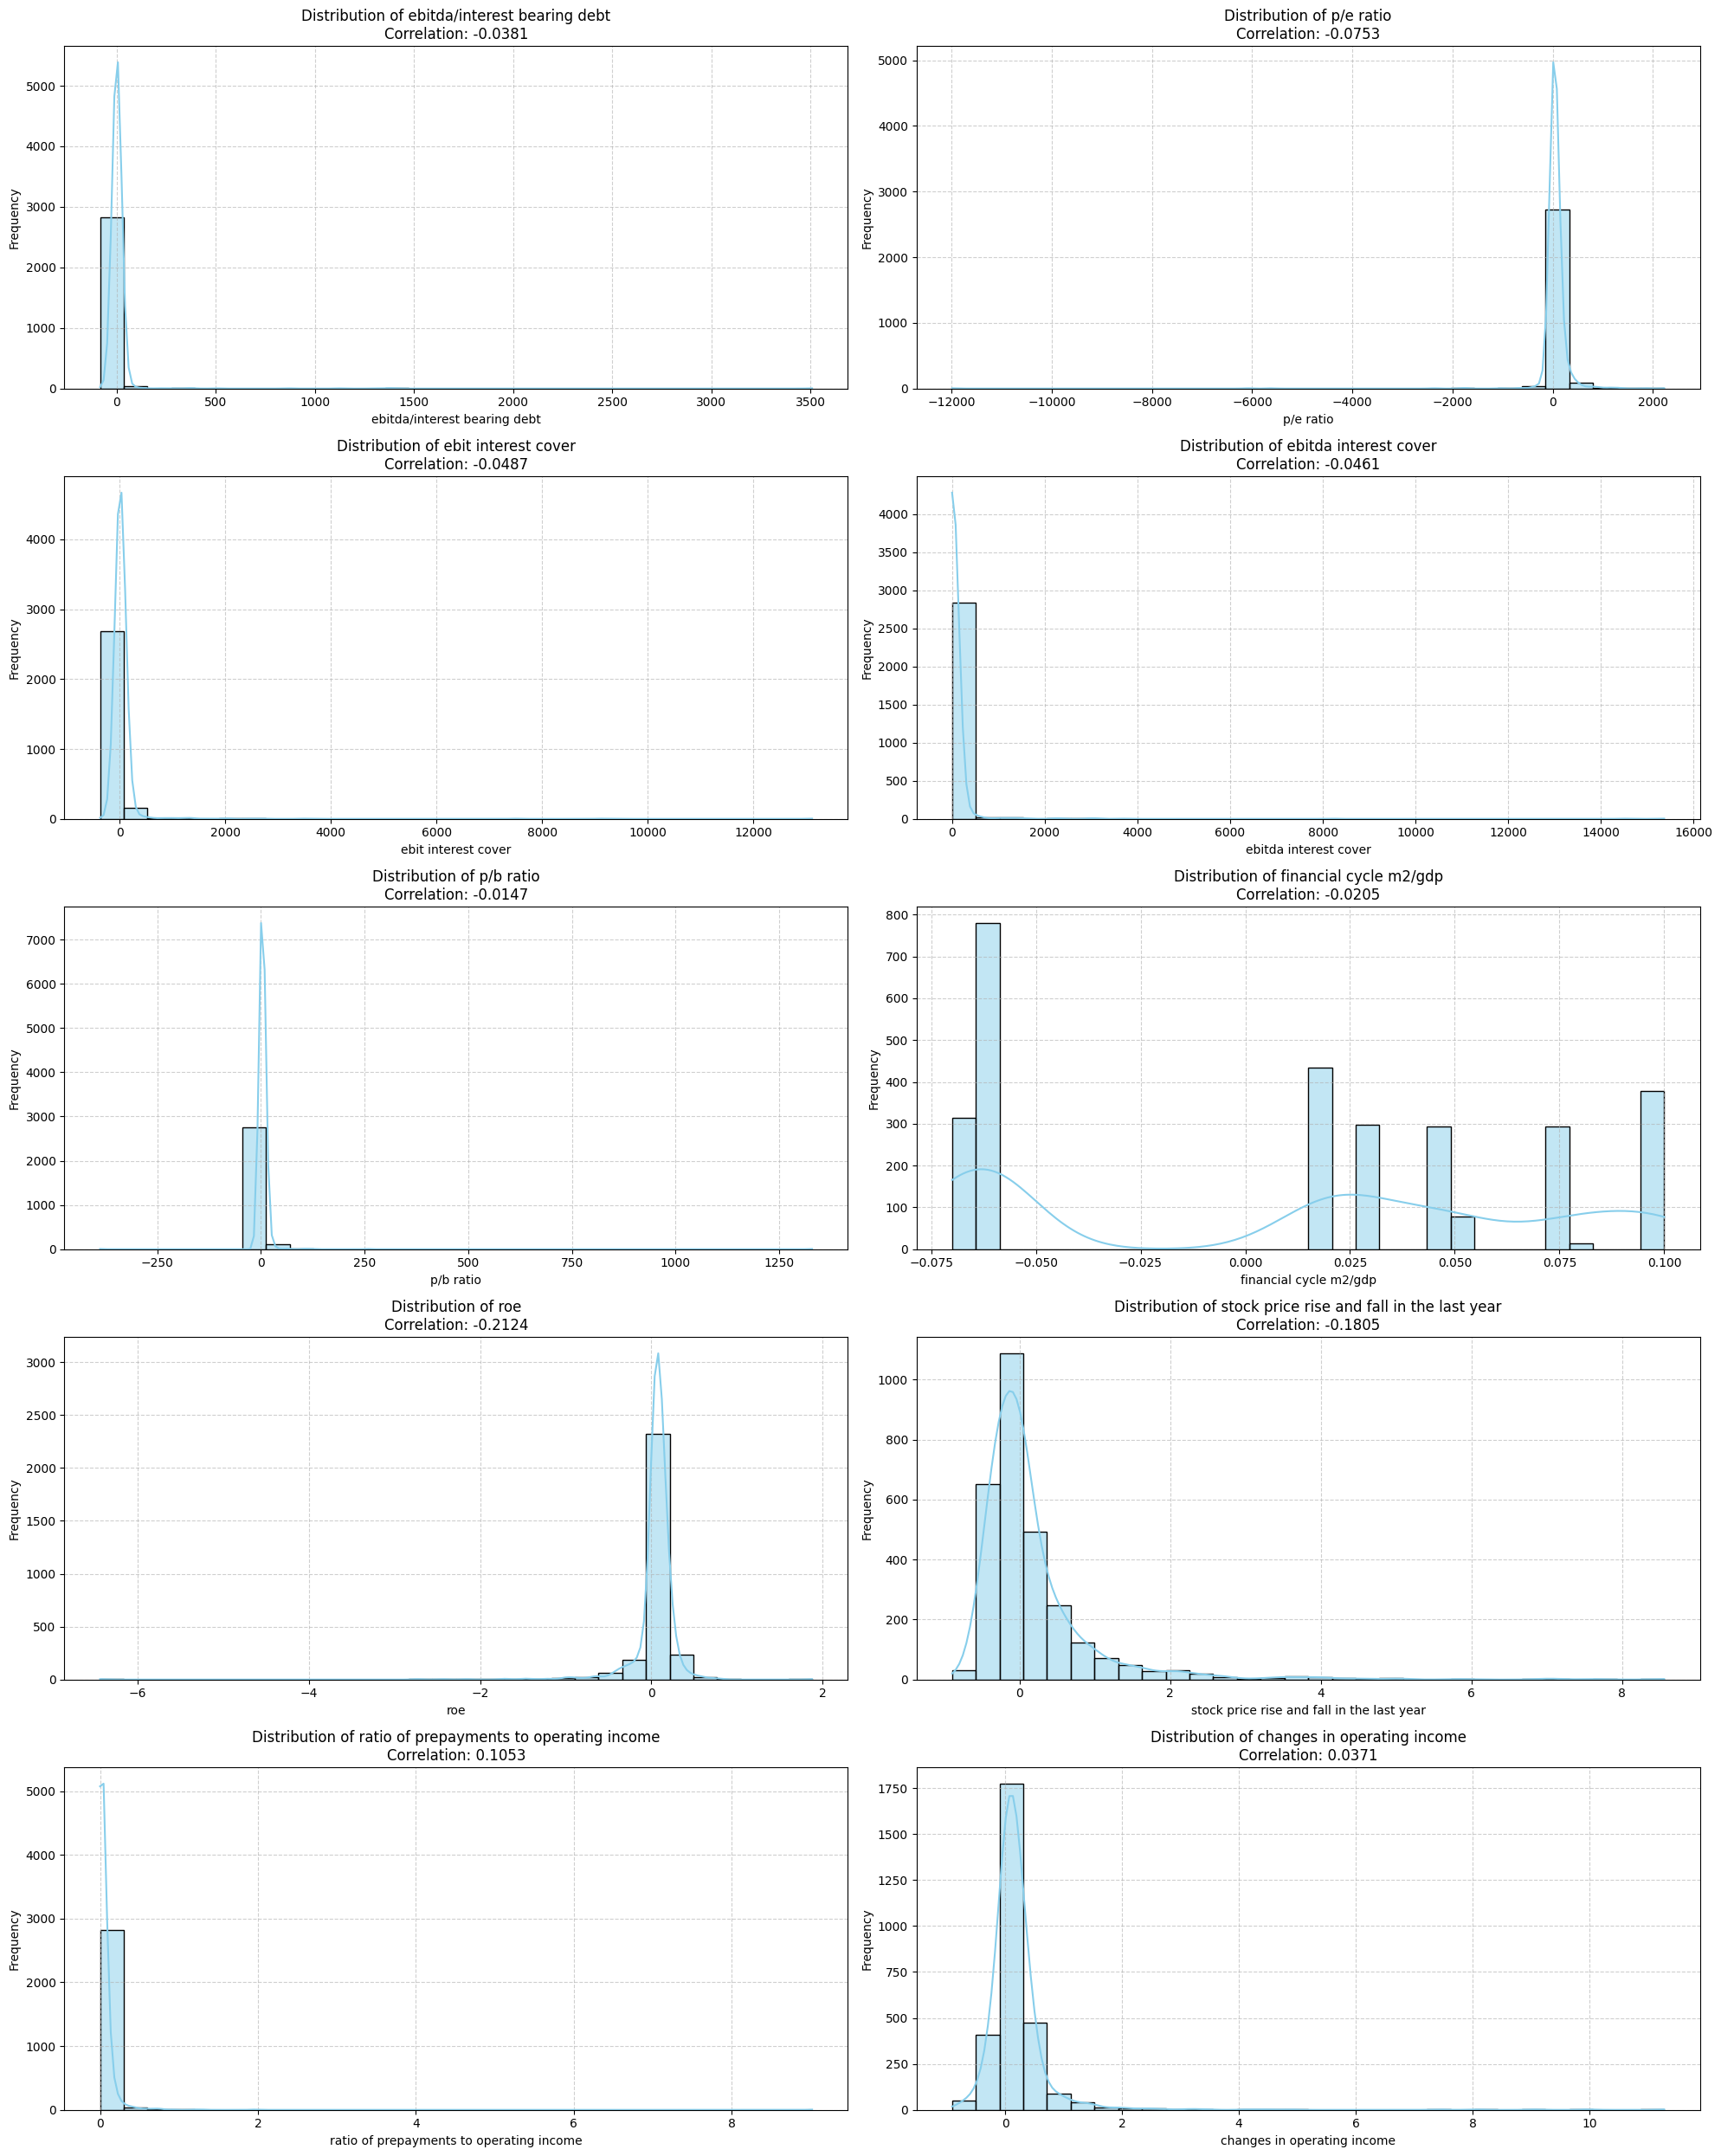

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ================== ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ==================
print("\nВизуализация распределения для топ-10 признаков с наибольшим коэффициентом вариации...")

# Выбираем топ-10 признаков
top_features = variation_analysis.index[:10]

# Строим графики
plt.figure(figsize=(20, 25))
for i, feature in enumerate(top_features):
    plt.subplot(5, 2, i + 1)  # 5 строк, 2 столбца
    sns.histplot(Xtrain_final[feature], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {feature}\nCorrelation: {variation_analysis.loc[feature, 'Correlation']:.4f}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
Xtrain_final.shape

(2884, 83)


Анализ распределения для признаков с высоким коэффициентом вариации (>7)...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


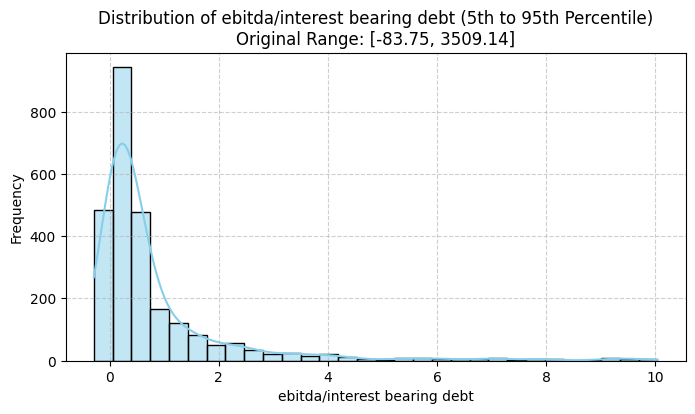

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


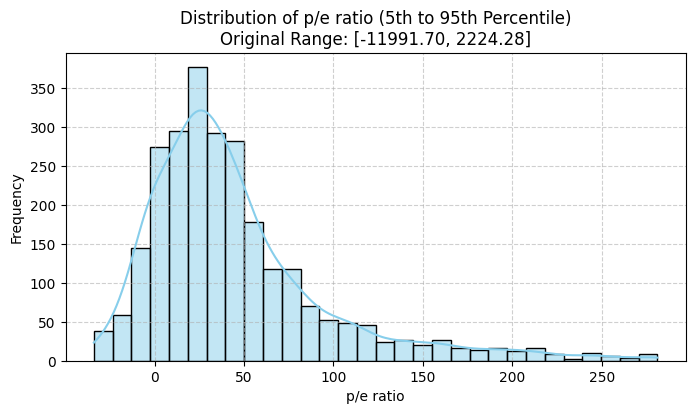

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


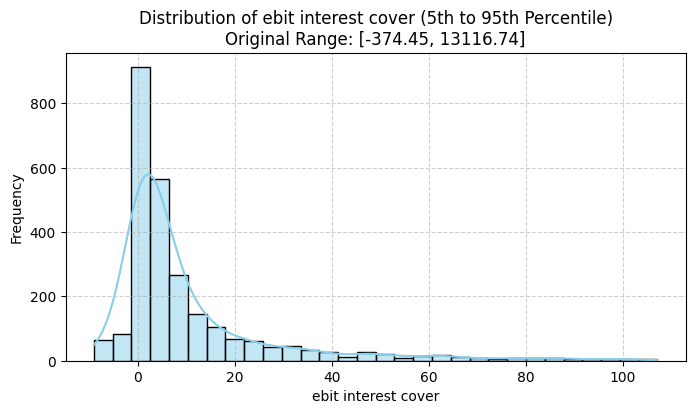

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


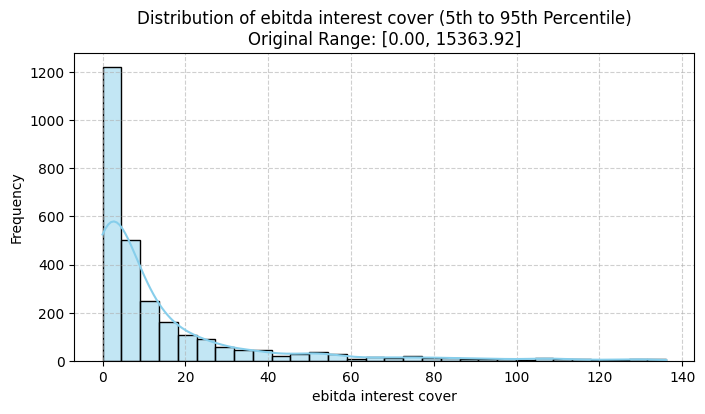

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


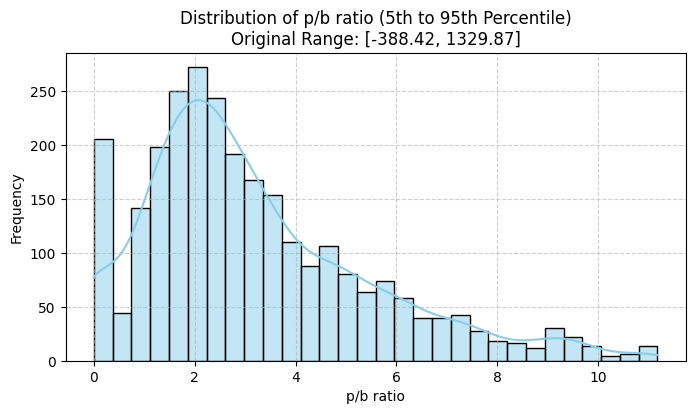

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================== АНАЛИЗ РАСПРЕДЕЛЕНИЯ БЕЗ ВЫБРОСОВ ==================
print("\nАнализ распределения для признаков с высоким коэффициентом вариации (>7)...")

# Определяем признаки с коэффициентом вариации > 7
high_variation_features = variation_analysis[variation_analysis['Variation'] > 7].index

# Создаем временную копию данных для анализа
Xtrain_temp = Xtrain_final.copy()

# Анализируем каждый признак
for feature in high_variation_features:
    # Вычисляем 5-й и 95-й процентили
    lower_bound = Xtrain_temp[feature].quantile(0.05)
    upper_bound = Xtrain_temp[feature].quantile(0.95)

    # Временно фильтруем данные (исключаем выбросы)
    filtered_data = Xtrain_temp[(Xtrain_temp[feature] >= lower_bound) & (Xtrain_temp[feature] <= upper_bound)]

    # Строим график распределения
    plt.figure(figsize=(8, 4))
    sns.histplot(filtered_data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {feature} (5th to 95th Percentile)\nOriginal Range: [{Xtrain_temp[feature].min():.2f}, {Xtrain_temp[feature].max():.2f}]")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
import pandas as pd
import numpy as np

# ================== АНАЛИЗ КОРРЕЛЯЦИИ ВЫБРОСОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ==================
print("\nАнализ корреляции выбросов с целевой переменной...")

# Определяем признаки с коэффициентом вариации > 7
high_variation_features = variation_analysis[variation_analysis['Variation'] > 7].index

# Создаем временную копию данных для анализа
Xtrain_temp = Xtrain_final.copy()

# Анализируем каждый признак
for feature in high_variation_features:
    # Вычисляем 5-й и 95-й процентили
    lower_bound = Xtrain_temp[feature].quantile(0.05)
    upper_bound = Xtrain_temp[feature].quantile(0.95)

    # Определяем выбросы (значения за пределами диапазона [5%, 95%])
    outliers_mask = (Xtrain_temp[feature] < lower_bound) | (Xtrain_temp[feature] > upper_bound)
    outliers_data = Xtrain_temp[outliers_mask]
    non_outliers_data = Xtrain_temp[~outliers_mask]

    # Корреляция выбросов и не-выбросов с целевой переменной
    correlation_outliers = outliers_data[feature].corr(ytrain_extended)
    correlation_non_outliers = non_outliers_data[feature].corr(ytrain_extended)

    # Выводим результаты
    print(f"\nПризнак: {feature}")
    print(f"Корреляция выбросов с целевой переменной: {correlation_outliers:.4f}")
    print(f"Корреляция не-выбросов с целевой переменной: {correlation_non_outliers:.4f}")
    print(f"Доля выбросов в данных: {outliers_data.shape[0] / Xtrain_temp.shape[0]:.2%}")


Анализ корреляции выбросов с целевой переменной...

Признак: ebitda/interest bearing debt
Корреляция выбросов с целевой переменной: -0.1356
Корреляция не-выбросов с целевой переменной: -0.1372
Доля выбросов в данных: 9.99%

Признак: p/e ratio
Корреляция выбросов с целевой переменной: -0.1628
Корреляция не-выбросов с целевой переменной: -0.0705
Доля выбросов в данных: 9.99%

Признак: ebit interest cover
Корреляция выбросов с целевой переменной: -0.1622
Корреляция не-выбросов с целевой переменной: -0.1011
Доля выбросов в данных: 9.99%

Признак: ebitda interest cover
Корреляция выбросов с целевой переменной: -0.0438
Корреляция не-выбросов с целевой переменной: -0.0996
Доля выбросов в данных: 4.99%

Признак: p/b ratio
Корреляция выбросов с целевой переменной: -0.0617
Корреляция не-выбросов с целевой переменной: -0.0712
Доля выбросов в данных: 5.13%


In [ ]:
# Определяем список признаков
features_to_transform = [
    'ebitda/interest bearing debt',
    'p/e ratio',
    'ebit interest cover',
    'ebitda interest cover',
    'p/b ratio',
    'financial cycle m2/gdp',
    'roe',
    'stock price rise and fall in the last year',
    'ratio of prepayments to operating income',
    'changes in operating income'
]

# Проверяем минимальные значения
for feature in features_to_transform:
    print(f"\nПризнак: {feature}")
    print(f"Минимальное значение: {Xtrain_final[feature].min()}")


Признак: ebitda/interest bearing debt
Минимальное значение: -83.74653688

Признак: p/e ratio
Минимальное значение: -11991.7005

Признак: ebit interest cover
Минимальное значение: -374.4545

Признак: ebitda interest cover
Минимальное значение: 0.0

Признак: p/b ratio
Минимальное значение: -388.42

Признак: financial cycle m2/gdp
Минимальное значение: -0.07

Признак: roe
Минимальное значение: -6.44

Признак: stock price rise and fall in the last year
Минимальное значение: -0.897933754

Признак: ratio of prepayments to operating income
Минимальное значение: 0.0

Признак: changes in operating income
Минимальное значение: -0.91


In [ ]:
import numpy as np

# Определяем список признаков
features_to_transform = [
    'ebitda/interest bearing debt',
    'p/e ratio',
    'ebit interest cover',
    'ebitda interest cover',
    'p/b ratio',
    'financial cycle m2/gdp',
    'roe',
    'stock price rise and fall in the last year',
    'ratio of prepayments to operating income',
    'changes in operating income'
]

# Создаем временную копию данных
Xtrain_temp = Xtrain_final.copy()

# Словарь для хранения корреляций
correlation_comparison = {}

# Применяем логарифмическое преобразование и анализируем
for feature in features_to_transform:
    # 1. Проверяем минимальное значение
    min_value = Xtrain_temp[feature].min()

    if min_value < 0:
        # Сдвигаем данные, чтобы избежать отрицательных значений
        Xtrain_temp[feature] = Xtrain_temp[feature] - min_value + 1e-6

    # 2. Вычисляем оригинальную корреляцию
    original_correlation = Xtrain_temp[feature].corr(ytrain_extended)

    # 3. Логарифмическое преобразование
    Xtrain_temp[f'log_{feature}'] = Xtrain_temp[feature].apply(lambda x: np.log1p(x))

    # 4. Вычисляем корреляцию после преобразования
    log_correlation = Xtrain_temp[f'log_{feature}'].corr(ytrain_extended)

    # Сохраняем результаты
    correlation_comparison[feature] = {
        'Original Correlation': original_correlation,
        'Log-Transformed Correlation': log_correlation
    }

# Выводим результаты
print("\nСравнение корреляции с целевой переменной:")
for feature, correlations in correlation_comparison.items():
    print(f"\nПризнак: {feature}")
    print(f"Корреляция оригинальных значений: {correlations['Original Correlation']:.4f}")
    print(f"Корреляция логарифмически преобразованных значений: {correlations['Log-Transformed Correlation']:.4f}")


Сравнение корреляции с целевой переменной:

Признак: ebitda/interest bearing debt
Корреляция оригинальных значений: -0.0381
Корреляция логарифмически преобразованных значений: -0.0623

Признак: p/e ratio
Корреляция оригинальных значений: -0.0753
Корреляция логарифмически преобразованных значений: -0.0611

Признак: ebit interest cover
Корреляция оригинальных значений: -0.0487
Корреляция логарифмически преобразованных значений: -0.0810

Признак: ebitda interest cover
Корреляция оригинальных значений: -0.0461
Корреляция логарифмически преобразованных значений: -0.1232

Признак: p/b ratio
Корреляция оригинальных значений: -0.0147
Корреляция логарифмически преобразованных значений: -0.0509

Признак: financial cycle m2/gdp
Корреляция оригинальных значений: -0.0205
Корреляция логарифмически преобразованных значений: -0.0202

Признак: roe
Корреляция оригинальных значений: -0.2124
Корреляция логарифмически преобразованных значений: -0.1674

Признак: stock price rise and fall in the last year
К


Графики распределения для логарифмически преобразованных признаков...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

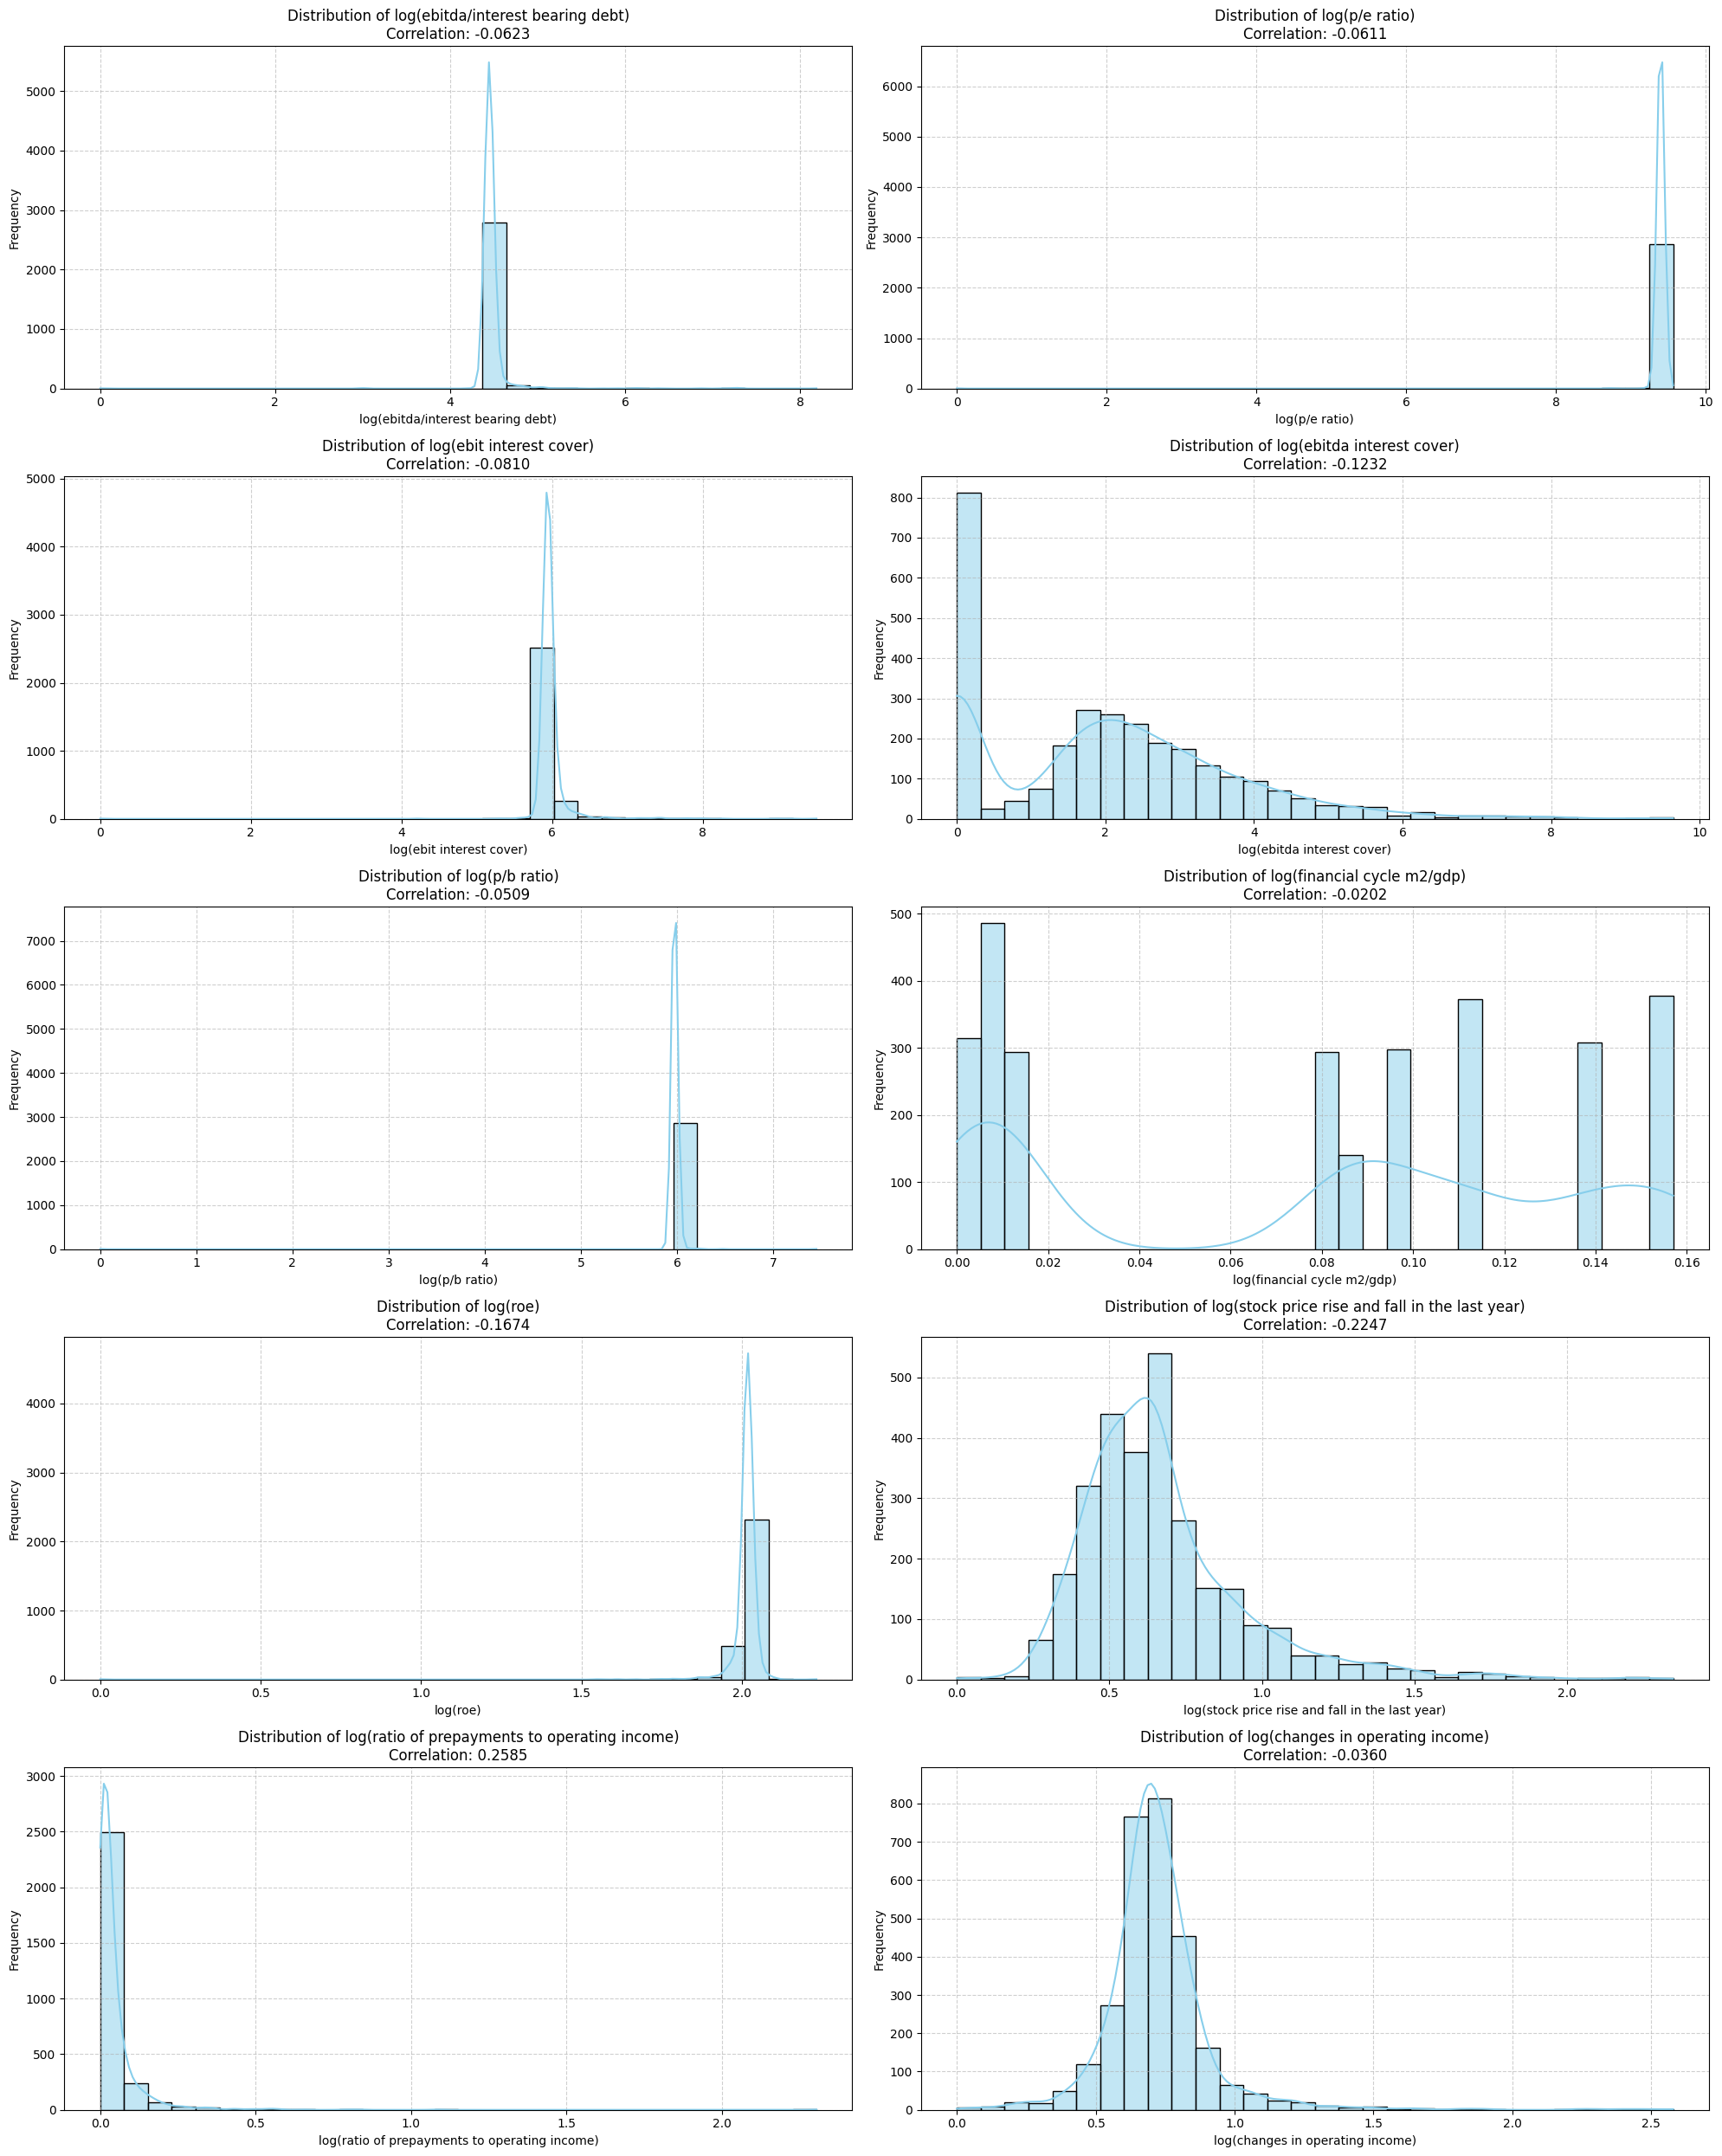

In [ ]:
# ================== ГРАФИКИ РАСПРЕДЕЛЕНИЯ ДЛЯ ЛОГАРИФМИЧЕСКИ ПРЕОБРАЗОВАННЫХ ПРИЗНАКОВ ==================
print("\nГрафики распределения для логарифмически преобразованных признаков...")

# Строим графики
plt.figure(figsize=(20, 25))
for i, feature in enumerate(features_to_transform):
    plt.subplot(5, 2, i + 1)  # 5 строк, 2 столбца
    sns.histplot(Xtrain_temp[f'log_{feature}'], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of log({feature})\nCorrelation: {correlation_comparison[feature]['Log-Transformed Correlation']:.4f}")
    plt.xlabel(f"log({feature})")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Определяем список признаков для преобразования
features_to_log_transform = [
    'p/b ratio',
    'ratio of prepayments to operating income',
    'ebit interest cover',
    'changes in operating income'
]

# Применяем сдвиг и логарифмическое преобразование
for feature in features_to_log_transform:
    # 1. Вычисляем глобальный минимум (по объединению тренировочных и тестовых данных)
    global_min = min(Xtrain_final[feature].min(), Xtest_final[feature].min())

    # 2. Применяем сдвиг к тренировочным данным
    Xtrain_final[feature] = Xtrain_final[feature] - global_min + 1e-6

    # 3. Применяем тот же сдвиг к тестовым данным
    Xtest_final[feature] = Xtest_final[feature] - global_min + 1e-6

    # 4. Применяем логарифмическое преобразование
    Xtrain_final[feature] = Xtrain_final[feature].apply(lambda x: np.log1p(x))
    Xtest_final[feature] = Xtest_final[feature].apply(lambda x: np.log1p(x))


Матрица корреляций:


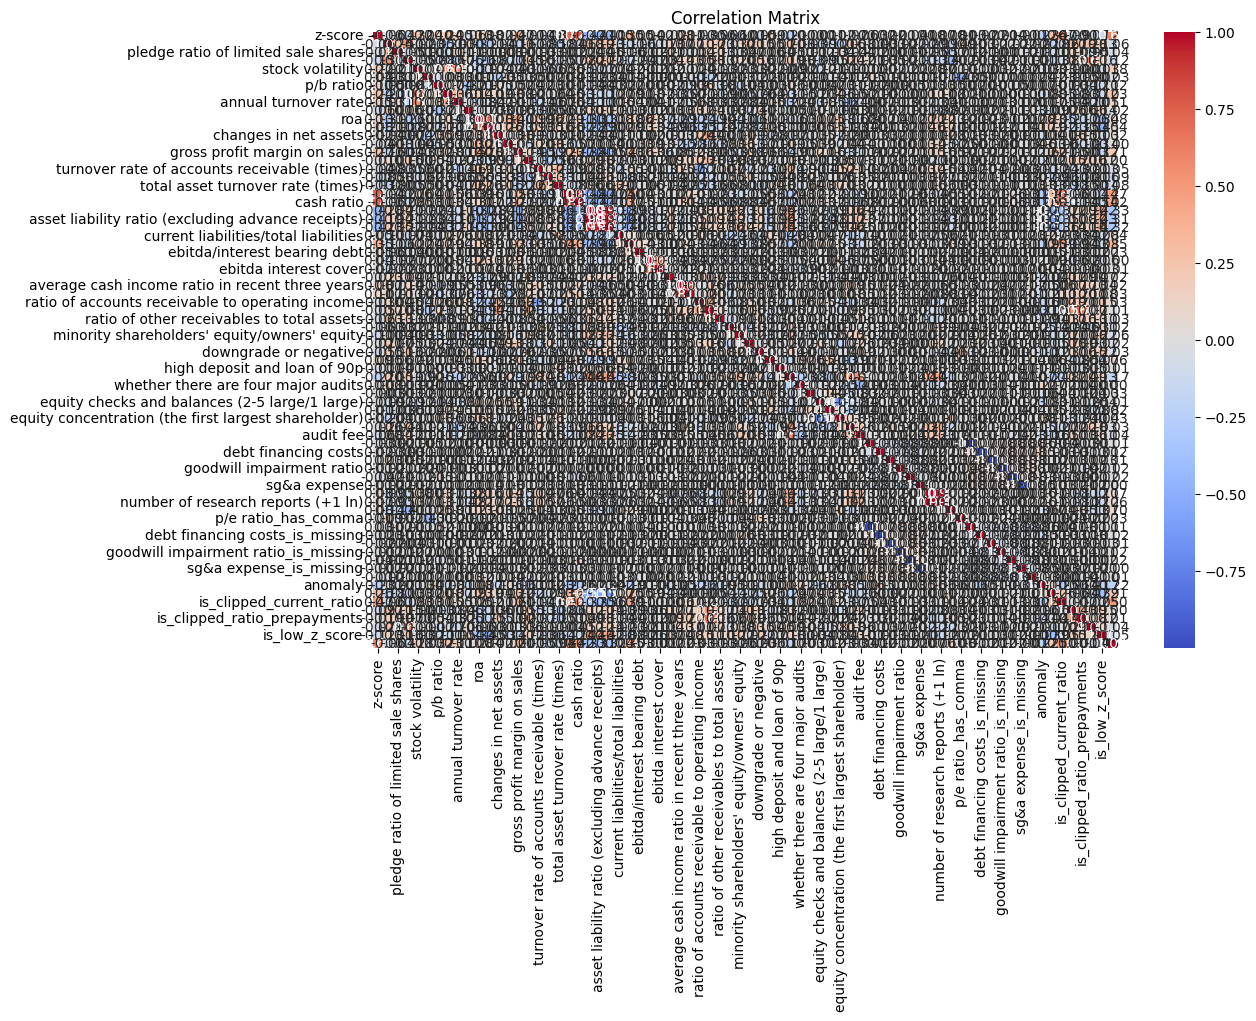


Пары признаков с высокой корреляцией (|r| > 0.8):
current ratio - cash ratio: 0.89
cash ratio - current ratio: 0.89
asset liability ratio - asset liability ratio (excluding advance receipts): 0.99
asset liability ratio - asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts): 0.95
asset liability ratio (excluding advance receipts) - asset liability ratio: 0.99
asset liability ratio (excluding advance receipts) - asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts): 0.96
asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts) - asset liability ratio: 0.95
asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance rece

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ================== 1. МАТРИЦА КОРРЕЛЯЦИЙ ==================
print("\nМатрица корреляций:")

# Выбираем только числовые признаки
numeric_features = Xtrain_final.select_dtypes(include=[np.number])

# Строим матрицу корреляций
correlation_matrix = numeric_features.corr()

# Выводим матрицу корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Находим пары признаков с высокой корреляцией
high_corr_pairs = [
    (i, j, correlation_matrix.loc[i, j])
    for i in correlation_matrix.columns
    for j in correlation_matrix.columns
    if i != j and abs(correlation_matrix.loc[i, j]) > 0.8
]
print("\nПары признаков с высокой корреляцией (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

In [ ]:
# ================== 2. VIF (VARIANCE INFLATION FACTOR) ==================
print("\nVIF для числовых признаков:")

# Добавляем константу для расчета VIF
X_with_const = numeric_features.copy()
X_with_const.insert(0, "const", 1)

# Рассчитываем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Удаляем константу из вывода
vif_data = vif_data[vif_data["Feature"] != "const"]

# Выводим результаты
print(vif_data)

# Находим признаки с высоким VIF
high_vif_features = vif_data[vif_data["VIF"] > 5]
print("\nПризнаки с высоким VIF (> 5):")
print(high_vif_features)


VIF для числовых признаков:
                                           Feature       VIF
1                                          z-score  3.939938
2   share pledge ratio of controlling shareholders  2.233965
3              pledge ratio of limited sale shares  1.403724
4                 pledge ratio of unlimited shares  2.887692
5                                 stock volatility  2.179005
..                                             ...       ...
70                   log_clipped_ratio_prepayments  1.827246
71                    is_clipped_ratio_prepayments  2.154854
72                            is_high_pledge_ratio  1.833694
73                                  is_low_z_score  1.782536
74                                 is_high_z_score  2.166802

[74 rows x 2 columns]

Признаки с высоким VIF (> 5):
                                              Feature           VIF
20                                      current ratio  6.614508e+00
21                                         cash r

In [ ]:
Xtrain_final.drop(columns=[
    'tobin q_is_missing',
    'debt financing costs_is_missing',
    'enterprise age_is_missing',
    'goodwill impairment ratio_is_missing',
    'asset quality index_is_missing',
    'sg&a expense_is_missing'
], inplace=True)
Xtest_final.drop(columns=[
    'tobin q_is_missing',
    'debt financing costs_is_missing',
    'enterprise age_is_missing',
    'goodwill impairment ratio_is_missing',
    'asset quality index_is_missing',
    'sg&a expense_is_missing'
], inplace=True)

In [ ]:
Xtrain_final.drop(columns=[
    'asset liability ratio (excluding advance receipts)',
    'asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts)',
    'number of research institutions concerned'
], inplace=True)
Xtest_final.drop(columns=[
    'asset liability ratio (excluding advance receipts)',
    'asset liability ratio (total liabilities - contract liabilities - advance receipts)/(total assets - goodwill - contract liabilities - advance receipts)',
    'number of research institutions concerned'
], inplace=True)

In [ ]:
# Вычисляем корреляцию с целевой переменной
correlation_with_target = Xtrain_final.corrwith(ytrain_extended)

# Берём модули корреляций и сортируем их от 0
correlation_by_abs = correlation_with_target.abs().sort_values()

# Выводим топ-10 признаков с корреляцией близкой к нулю
print("\nТоп-10 признаков с корреляцией близкой к нулю:")
print(correlation_by_abs.head(10))


Топ-10 признаков с корреляцией близкой к нулю:
proportion of independent directors               0.002095
equity checks and balances (2-5 large/1 large)    0.007070
number of key audit matters_-999                  0.009259
number of key audit matters_is_missing            0.009259
current ratio                                     0.009932
tobin q                                           0.010944
number of key audit matters_5                     0.012529
number of key audit matters_4                     0.012604
inventory turnover rate (times)                   0.012877
whether there are four major audits               0.013378
dtype: float64


In [ ]:
# Проверяем размеры тренировочного датасета
print("\nРазмер тренировочного датасета (Xtrain_final):")
print(f"Количество строк: {Xtrain_final.shape[0]}")
print(f"Количество признаков: {Xtrain_final.shape[1]}")

# Проверяем размеры тестового датасета
print("\nРазмер тестового датасета (Xtest_final):")
print(f"Количество строк: {Xtest_final.shape[0]}")
print(f"Количество признаков: {Xtest_final.shape[1]}")

# Проверяем, совпадают ли признаки в тренировочном и тестовом датасетах
if set(Xtrain_final.columns) == set(Xtest_final.columns):
    print("\nПризнаки в тренировочном и тестовом датасетах совпадают.")
else:
    print("\nПризнаки в тренировочном и тестовом датасетах НЕ совпадают!")
    print("Различия в признаках:")
    missing_in_test = set(Xtrain_final.columns) - set(Xtest_final.columns)
    missing_in_train = set(Xtest_final.columns) - set(Xtrain_final.columns)
    if missing_in_test:
        print(f"Признаки, отсутствующие в тестовом датасете: {missing_in_test}")
    if missing_in_train:
        print(f"Признаки, отсутствующие в тренировочном датасете: {missing_in_train}")


Размер тренировочного датасета (Xtrain_final):
Количество строк: 2884
Количество признаков: 74

Размер тестового датасета (Xtest_final):
Количество строк: 184
Количество признаков: 74

Признаки в тренировочном и тестовом датасетах совпадают.


In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Создаем копии датасетов
Xtrain_normalized = Xtrain_final.copy()
Xtest_normalized = Xtest_final.copy()

# 2. Преобразуем все данные в тип float64
Xtrain_normalized = Xtrain_normalized.astype(float)
Xtest_normalized = Xtest_normalized.astype(float)

# 3. Нормализуем данные с помощью StandardScaler
scaler = StandardScaler()

# Применяем нормализацию к тренировочному датасету
Xtrain_normalized[:] = scaler.fit_transform(Xtrain_normalized)

# Применяем ту же нормализацию к тестовому датасету
Xtest_normalized[:] = scaler.transform(Xtest_normalized)

# 4. Проверяем результаты
print("\nРазмеры после нормализации:")
print(f"Тренировочный датасет (нормализованный): {Xtrain_normalized.shape}")
print(f"Тестовый датасет (нормализованный): {Xtest_normalized.shape}")

# Выводим первые несколько строк нормализованных данных
print("\nПервые строки нормализованного тренировочного датасета:")
print(Xtrain_normalized.head())

print("\nПервые строки нормализованного тестового датасета:")
print(Xtest_normalized.head())


Размеры после нормализации:
Тренировочный датасет (нормализованный): (2884, 74)
Тестовый датасет (нормализованный): (184, 74)

Первые строки нормализованного тренировочного датасета:
    z-score  share pledge ratio of controlling shareholders  \
0 -0.034625                                       -1.073023   
1 -0.150733                                       -0.851247   
2 -0.362833                                        0.166230   
3 -0.031526                                        0.051269   
4 -0.289607                                       -0.004184   

   pledge ratio of limited sale shares  pledge ratio of unlimited shares  \
0                             0.031356                         -0.620118   
1                             0.379544                         -0.189124   
2                            -0.299122                          0.308414   
3                            -0.299122                          0.397121   
4                            -0.299122                   

In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Логистическая регрессия
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Определяем стратегию кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Вычисляем метрики на кросс-валидации
logistic_metrics = {
    'Accuracy': cross_val_score(logistic_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='accuracy').mean(),
    'Precision': cross_val_score(logistic_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(precision_score, zero_division=0)).mean(),
    'Recall': cross_val_score(logistic_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(recall_score, zero_division=0)).mean(),
    'F1-Score': cross_val_score(logistic_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(f1_score, zero_division=0)).mean(),
    'ROC-AUC': cross_val_score(logistic_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='roc_auc').mean()
}

# Обучаем модель на всех данных
logistic_model.fit(Xtrain_normalized, ytrain_extended)

# Выводим метрики
print("\nМетрики для логистической регрессии:")
for metric, value in logistic_metrics.items():
    print(f"{metric}: {value:.4f}")


Метрики для логистической регрессии:
Accuracy: 0.9157
Precision: 0.8321
Recall: 0.6843
F1-Score: 0.7500
ROC-AUC: 0.9377


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Случайный лес
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)

# Вычисляем метрики на кросс-валидации
rf_metrics = {
    'Accuracy': cross_val_score(rf_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='accuracy').mean(),
    'Precision': cross_val_score(rf_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(precision_score, zero_division=0)).mean(),
    'Recall': cross_val_score(rf_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(recall_score, zero_division=0)).mean(),
    'F1-Score': cross_val_score(rf_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(f1_score, zero_division=0)).mean(),
    'ROC-AUC': cross_val_score(rf_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='roc_auc').mean()
}

# Обучаем модель на всех данных
rf_model.fit(Xtrain_normalized, ytrain_extended)

# Выводим метрики
print("\nМетрики для случайного леса:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")


Метрики для случайного леса:
Accuracy: 0.9854
Precision: 1.0000
Recall: 0.9211
F1-Score: 0.9589
ROC-AUC: 0.9962


In [ ]:
from catboost import CatBoostClassifier

# CatBoost
catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0
)

# Вычисляем метрики на кросс-валидации
catboost_metrics = {
    'Accuracy': cross_val_score(catboost_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='accuracy').mean(),
    'Precision': cross_val_score(catboost_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(precision_score, zero_division=0)).mean(),
    'Recall': cross_val_score(catboost_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(recall_score, zero_division=0)).mean(),
    'F1-Score': cross_val_score(catboost_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(f1_score, zero_division=0)).mean(),
    'ROC-AUC': cross_val_score(catboost_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='roc_auc').mean()
}

# Обучаем модель на всех данных
catboost_model.fit(Xtrain_normalized, ytrain_extended)

# Выводим метрики
print("\nМетрики для CatBoost:")
for metric, value in catboost_metrics.items():
    print(f"{metric}: {value:.4f}")


Метрики для CatBoost:
Accuracy: 0.9972
Precision: 1.0000
Recall: 0.9849
F1-Score: 0.9923
ROC-AUC: 1.0000


In [ ]:
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Параметры для подбора
logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Обратная сила регуляризации
    'penalty': ['l1', 'l2'],  # Тип регуляризации
    'solver': ['liblinear']   # Солвер, поддерживающий L1 и L2
}

# GridSearchCV для логистической регрессии
logistic_search = GridSearchCV(
    logistic_model,
    param_grid=logistic_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
logistic_search.fit(Xtrain_normalized, ytrain_extended)
print("\nЛучшие параметры для логистической регрессии:")
print(logistic_search.best_params_)


Лучшие параметры для логистической регрессии:
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Случайный лес
rf_model = RandomForestClassifier(random_state=42)

# Параметры для подбора
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV для случайного леса
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
rf_search.fit(Xtrain_normalized, ytrain_extended)
print("\nЛучшие параметры для случайного леса:")
print(rf_search.best_params_)


Лучшие параметры для случайного леса:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


In [ ]:
from catboost import CatBoostClassifier

# CatBoost
catboost_model = CatBoostClassifier(
    random_state=42,
    verbose=0  # Отключаем вывод логов
)

# Параметры для подбора
catboost_param_grid = {
    'iterations': [300, 500, 700],  # Количество деревьев
    'learning_rate': [0.01, 0.05, 0.1],  # Скорость обучения
    'depth': [4, 6, 8],  # Глубина деревьев
    'l2_leaf_reg': [1, 3, 5]  # Регуляризация
}

# RandomizedSearchCV для CatBoost
catboost_search = RandomizedSearchCV(
    catboost_model,
    param_distributions=catboost_param_grid,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
catboost_search.fit(Xtrain_normalized, ytrain_extended)
print("\nЛучшие параметры для CatBoost:")
print(catboost_search.best_params_)


Лучшие параметры для CatBoost:
{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 4}


In [ ]:
# Обучаем модели с лучшими гиперпараметрами
best_logistic = logistic_search.best_estimator_
best_rf = rf_search.best_estimator_
best_catboost = catboost_search.best_estimator_

# Обучение на всех данных
best_logistic.fit(Xtrain_normalized, ytrain_extended)
best_rf.fit(Xtrain_normalized, ytrain_extended)
best_catboost.fit(Xtrain_normalized, ytrain_extended)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Создаем ансамбль из лучших моделей
ensemble_model = VotingClassifier(
    estimators=[
        ('logistic', best_logistic),
        ('random_forest', best_rf),
        ('catboost', best_catboost)
    ],
    voting='soft'  # Используем вероятности для голосования
)

# Обучаем ансамбль на тренировочной выборке
ensemble_model.fit(Xtrain_normalized, ytrain_extended)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('random_forest',
                              RandomForestClassifier(max_depth=30,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x79a5a346a560>)],
                 voting='soft')

In [ ]:
from sklearn.ensemble import VotingClassifier

# Создаем ансамбль из лучших моделей
ensemble_model = VotingClassifier(
    estimators=[
        ('logistic', best_logistic),
        ('random_forest', best_rf),
        ('catboost', best_catboost)
    ],
    voting='soft'  # Используем вероятности для голосования
)

# Обучаем ансамбль на тренировочной выборке
ensemble_model.fit(Xtrain_normalized, ytrain_extended)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('random_forest',
                              RandomForestClassifier(max_depth=30,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x79a5a346a560>)],
                 voting='soft')

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Определяем стратегию кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Вычисляем метрики на кросс-валидации
ensemble_metrics = {
    'Accuracy': cross_val_score(ensemble_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='accuracy').mean(),
    'Precision': cross_val_score(ensemble_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(precision_score, zero_division=0)).mean(),
    'Recall': cross_val_score(ensemble_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(recall_score, zero_division=0)).mean(),
    'F1-Score': cross_val_score(ensemble_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring=make_scorer(f1_score, zero_division=0)).mean(),
    'ROC-AUC': cross_val_score(ensemble_model, Xtrain_normalized, ytrain_extended, cv=cv, scoring='roc_auc').mean()
}

# Выводим метрики
print("\nМетрики для ансамбля (через кросс-валидацию):")
for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value:.4f}")


Метрики для ансамбля (через кросс-валидацию):
Accuracy: 0.9941
Precision: 1.0000
Recall: 0.9680
F1-Score: 0.9837
ROC-AUC: 0.9986


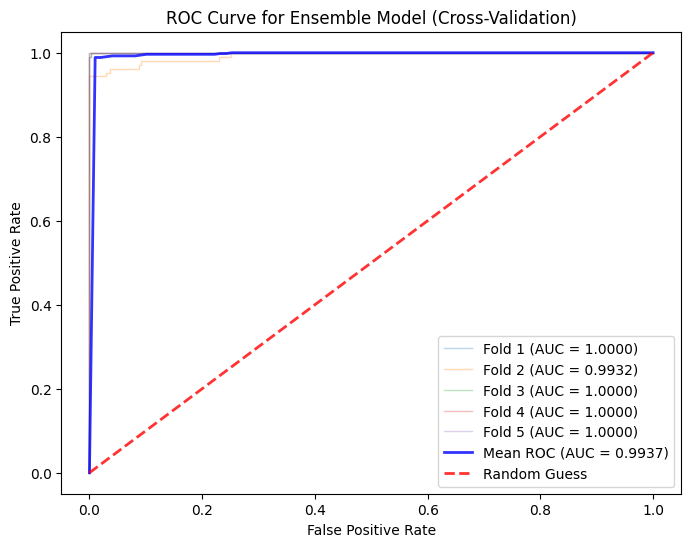

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Функция для построения ROC-кривой через кросс-валидацию
def plot_roc_cv(model, X, y, cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Разделяем данные на тренировочный и тестовый фолды
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Обучаем модель на тренировочном фолде
        model.fit(X_train, y_train)

        # Предсказываем вероятности для тестового фолда
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Вычисляем ROC-кривую и AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Рисуем ROC-кривую для текущего фолда
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {i+1} (AUC = {roc_auc:.4f})")

    # Средняя ROC-кривая
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.4f})", lw=2, alpha=0.8)

    # Случайное угадывание
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label="Random Guess", alpha=0.8)

    # Настройки графика
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve for Ensemble Model (Cross-Validation)")
    ax.legend(loc="lower right")
    plt.show()

# Построение ROC-кривой через кросс-валидацию
plot_roc_cv(ensemble_model, Xtrain_normalized, ytrain_extended, cv)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Определяем стратегию кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Вычисляем F1-score через кросс-валидацию
f1_scores = cross_val_score(
    ensemble_model,
    Xtrain_normalized,
    ytrain_extended,
    cv=cv,
    scoring=make_scorer(f1_score, zero_division=0)
)

# Выводим среднее значение F1-score
print("\nF1-Score на кросс-валидации:")
print(f"Mean F1-Score: {f1_scores.mean():.4f}")


F1-Score на кросс-валидации:
Mean F1-Score: 0.9837


In [ ]:
# Предсказания на тестовой выборке (вероятности класса 1)
test_predictions_proba = ensemble_model.predict_proba(Xtest_normalized)[:, 1]

In [ ]:
# Преобразуем вероятности в "жесткие" предсказания
test_predictions = (test_predictions_proba >= 0.5).astype(int)

In [ ]:
# Создаем DataFrame для сохранения
submission = pd.DataFrame({
    "Stock code": Xtest_normalized.index,  # Используем индекс как Stock code
    "IsDefault": test_predictions          # Жесткие метки (0 или 1)
})

# Сохраняем в файл
submission.to_csv("/kaggle/working/submission_ensemble.csv", index=False)

print("Жесткие предсказания сохранены в файл: /kaggle/working/submission_ensemble.csv")

Жесткие предсказания сохранены в файл: /kaggle/working/submission_ensemble.csv


In [ ]:
# Предсказания вероятностей для тестовой выборки от каждой модели
logistic_pred_proba = best_logistic.predict_proba(Xtest_normalized)[:, 1]
rf_pred_proba = best_rf.predict_proba(Xtest_normalized)[:, 1]
catboost_pred_proba = best_catboost.predict_proba(Xtest_normalized)[:, 1]

# Преобразуем вероятности в "жесткие" предсказания (0 или 1) с порогом 0.5
logistic_pred = (logistic_pred_proba >= 0.5).astype(int)
rf_pred = (rf_pred_proba >= 0.5).astype(int)
catboost_pred = (catboost_pred_proba >= 0.5).astype(int)

# Выводим первые несколько строк для проверки
print("Логистическая регрессия (вероятности):", logistic_pred_proba[:5])
print("Случайный лес (вероятности):", rf_pred_proba[:5])
print("CatBoost (вероятности):", catboost_pred_proba[:5])

print("\nЛогистическая регрессия (жесткие предсказания):", logistic_pred[:5])
print("Случайный лес (жесткие предсказания):", rf_pred[:5])
print("CatBoost (жесткие предсказания):", catboost_pred[:5])

Логистическая регрессия (вероятности): [0.1408251  0.10689912 0.01732211 0.0013522  0.00329754]
Случайный лес (вероятности): [0.56666667 0.53       0.78666667 0.47333333 0.28      ]
CatBoost (вероятности): [0.83816486 0.56167784 0.99688132 0.56118543 0.17907822]

Логистическая регрессия (жесткие предсказания): [0 0 0 0 0]
Случайный лес (жесткие предсказания): [1 1 1 0 0]
CatBoost (жесткие предсказания): [1 1 1 1 0]


In [ ]:
# Логистическая регрессия
submission_logistic = pd.DataFrame({
    "Stock code": Xtest_normalized.index,
    "IsDefault": logistic_pred  # Вероятности класса 1
})
submission_logistic.to_csv("/kaggle/working/submission_logistic.csv", index=False)

# Случайный лес
submission_rf = pd.DataFrame({
    "Stock code": Xtest_normalized.index,
    "IsDefault": rf_pred  # Вероятности класса 1
})
submission_rf.to_csv("/kaggle/working/submission_rf.csv", index=False)

# CatBoost
submission_catboost = pd.DataFrame({
    "Stock code": Xtest_normalized.index,
    "IsDefault": catboost_pred  # Вероятности класса 1
})
submission_catboost.to_csv("/kaggle/working/submission_catboost.csv", index=False)

print("Предсказания сохранены в файлы: submission_logistic.csv, submission_rf.csv, submission_catboost.csv")

Предсказания сохранены в файлы: submission_logistic.csv, submission_rf.csv, submission_catboost.csv


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# KNN
knn_model = KNeighborsClassifier()

# Параметры для подбора
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],          # Количество соседей
    'weights': ['uniform', 'distance'],   # Веса соседей
    'p': [1, 2]                           # Метрика расстояния (1 — манхэттен, 2 — евклидова)
}

# GridSearchCV для KNN
knn_search = GridSearchCV(
    knn_model,
    param_grid=knn_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
knn_search.fit(Xtrain_normalized, ytrain_extended)
print("\nЛучшие параметры для KNN:")
print(knn_search.best_params_)


Лучшие параметры для KNN:
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Параметры для подбора
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# RandomizedSearchCV для XGBoost
xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)
xgb_search.fit(Xtrain_normalized, ytrain_extended)
print("\nЛучшие параметры для XGBoost:")
print(xgb_search.best_params_)


Лучшие параметры для XGBoost:
{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [ ]:
# Лучшие модели после подбора гиперпараметров
best_knn = knn_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Обучаем модели на всех данных
best_knn.fit(Xtrain_normalized, ytrain_extended)
best_xgb.fit(Xtrain_normalized, ytrain_extended)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Создаем ансамбль из 5 моделей
ensemble_model = VotingClassifier(
    estimators=[
        ('logistic', best_logistic),
        ('random_forest', best_rf),
        ('catboost', best_catboost),
        ('knn', best_knn),
        ('xgboost', best_xgb)
    ],
    voting='soft'  # Используем вероятности для голосования
)

# Обучаем ансамбль на тренировочной выборке
ensemble_model.fit(Xtrain_normalized, ytrain_extended)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=0.1, max_iter=1000,
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('random_forest',
                              RandomForestClassifier(max_depth=30,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x79a5a346a560>),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=3, p=1,
                                                   weights='distance')),
                             ('xgboos...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [ ]:
# Предсказания вероятностей для тестовой выборки
test_predictions_proba = ensemble_model.predict_proba(Xtest_normalized)[:, 1]

# Преобразуем вероятности в "жесткие" предсказания (0 или 1) с порогом 0.5
test_predictions = (test_predictions_proba >= 0.5).astype(int)

# Сохраняем предсказания в файл
submission = pd.DataFrame({
    "Stock code": Xtest_normalized.index,
    "IsDefault": test_predictions  # Вероятности класса 1
})
submission.to_csv("/kaggle/working/submission_ensemble_all_models.csv", index=False)

print("Предсказания сохранены в файл: /kaggle/working/submission_ensemble_all_models.csv")

Предсказания сохранены в файл: /kaggle/working/submission_ensemble_all_models.csv


In [ ]:
# Сохраняем жесткие предсказания в файл
submission_hard = pd.DataFrame({
    "Stock code": Xtest_normalized.index,
    "IsDefault": test_predictions  # Жесткие метки (0 или 1)
})
submission_hard.to_csv("/kaggle/working/submission_ensemble_all_models_hard.csv", index=False)

print("Предсказания (жесткие метки) сохранены в файл: /kaggle/working/submission_ensemble_all_models_hard.csv")

Предсказания (жесткие метки) сохранены в файл: /kaggle/working/submission_ensemble_all_models_hard.csv


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Определяем стратегию кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Вычисляем F1-score через кросс-валидацию
f1_scores = cross_val_score(
    ensemble_model,
    Xtrain_normalized,
    ytrain_extended,
    cv=cv,
    scoring=make_scorer(f1_score, zero_division=0)
)

# Выводим среднее значение F1-score
print("\nF1-Score на кросс-валидации:")
print(f"Mean F1-Score: {f1_scores.mean():.4f}")


F1-Score на кросс-валидации:
Mean F1-Score: 0.9827
